### Dependency

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/DATA304'

/content/drive/MyDrive/DATA304


In [3]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### 0. Accelerator

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 0.5. Preprocessing

In [ ]:
import random
import numpy as np
import torch
import json
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

seed_value = 410
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

df = pd.read_csv('daangn.csv', encoding='utf-8-sig')
df = df.dropna()

df_train, df_test = train_test_split(df, test_size=309, random_state=42)
print(len(df_train), len(df_test))

def preprocess_df(df):
    df['up'] = df['Time Posted'].apply(lambda x: 1 if x.startswith('끌올') else 0)

    def get_time_in_days(s):
        number = int(''.join(filter(str.isdigit, s)))
        if '일' in s:
            return number
        elif '시간' in s:
            return number / 24.0
        else:
            return 0

    df['time'] = df['Time Posted'].apply(get_time_in_days)

    return df

df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

61000 309


In [ ]:
import json

def process_and_save_to_jsonl(df, file_name):
    with open(file_name, 'w', encoding='utf-8') as file:
        for _, row in df.iterrows():
            input_text = f"제목: {row['Title']}, \n 상품 설명: {row['Description']}"
            output_val = 1 if row['time'] >= 7 else 0
            record = {"input": input_text, "output": str(output_val)}
            file.write(json.dumps(record, ensure_ascii=False) + '\n')

process_and_save_to_jsonl(df_train, 'train.jsonl')
process_and_save_to_jsonl(df_test, 'eval.jsonl')

In [ ]:
with open('train.jsonl', 'w') as f:
    for item in train_dataset:
        f.write(json.dumps(item) + '\n')

with open('eval.jsonl', 'w') as f:
    for item in eval_dataset:
        f.write(json.dumps(item) + '\n')

# with open('temp.jsonl', 'w') as f:
#    for item in temp_dataset:
#        f.write(json.dumps(item) + '\n')

### 1. Load Dataset

In [5]:
from datasets import load_dataset
import json

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='eval.jsonl', split='train')
# temp_dataset = load_dataset('json', data_files='temp.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
def formatting_func(example):
    text = f"""너는 지금 중고거래 플랫폼을 운영하고 있는 데이터 분석가야.
아래에 입력되는 제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.

네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.

상품 설명:
{example['input']}

예측 결과: {example['output']}"""
    return text

### 2. Load Base Model

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "nlpai-lab/kullm-polyglot-12.8b-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config
)

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### 3. Tokenization

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)
# tokenized_temp_dataset = temp_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/61000 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

61309


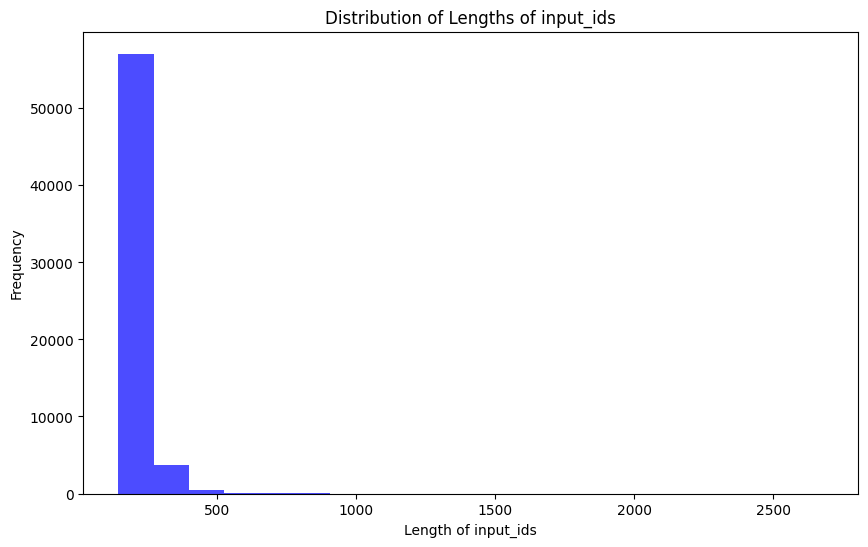

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 256

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)
# tokenized_temp_dataset = temp_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/61000 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[1049, 272, 1048, 7420, 2459, 11318, 276, 1163, 4296, 327, 272, 3293, 1496, 29667, 17, 202, 12657, 274, 9272, 605, 272, 4526, 359, 1772, 1251, 276, 7176, 1369, 307, 1772, 270, 11318, 274, 23621, 605, 283, 2402, 632, 1185, 270, 831, 393, 958, 7995, 2259, 831, 393, 4269, 7995, 3983, 310, 5424, 17, 202, 494, 539, 284, 379, 893, 6690, 1772, 270, 1400, 605, 272, 971, 274, 831, 393, 4269, 270, 8970, 295, 2259, 831, 393, 958, 270, 8970, 295, 3983, 284, 272, 388, 359, 2729, 310, 17, 202, 202, 978, 293, 12571, 1058, 423, 272, 388, 296, 1772, 270, 11318, 274, 23621, 605, 283, 2402, 632, 1185, 270, 831, 393, 958, 7995, 2259, 831, 393, 4269, 7995, 3983, 288, 1211, 489, 17, 202, 202, 3007, 1251, 29, 202, 400, 919, 29, 24838, 267, 5964, 1110, 24838, 17338, 595, 5494, 341, 2750, 15, 224, 202, 1772, 1251, 29, 24838, 267, 5964, 1110, 24838, 17338, 202, 535, 5494, 454, 2750, 202, 646, 1509, 961, 352, 202, 25022, 12380, 601, 533, 1449, 202, 22736, 12380, 5208, 4884, 380, 547, 436, 622, 827, 17, 202, 1785

61309


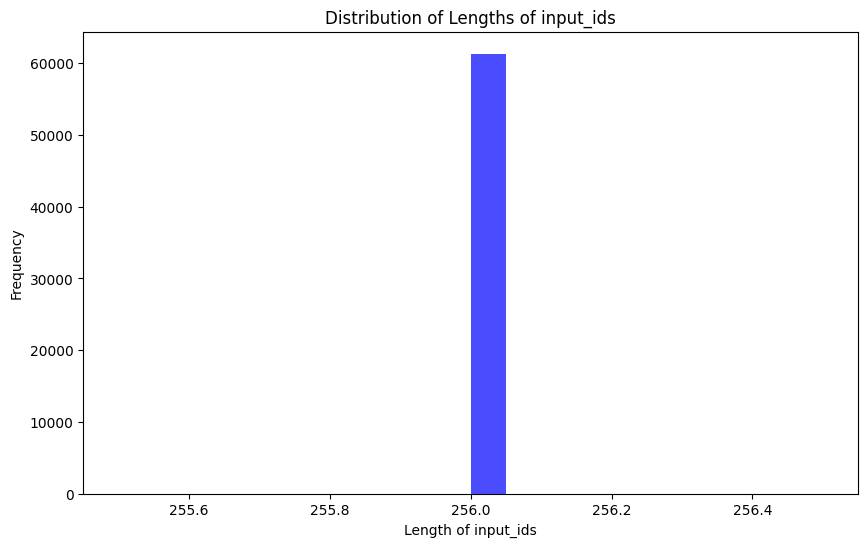

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [15]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [17]:
import jsonlines
from tqdm import tqdm
import warnings
from transformers import logging

import jsonlines
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=base_model_id)

model.eval()

def predict_with_pipe(eval_input):
    eval_prompt = f"""[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

{eval_input}
예측 결과: """
    output = pipe(eval_prompt,
                  pad_token_id=pipe.tokenizer.eos_token_id,
                  max_new_tokens=7,
                  repetition_penalty=1.1,
                  no_repeat_ngram_size=3)
    answer = output[0]["generated_text"].strip()
    print(answer)
    return answer

with jsonlines.open('eval.jsonl') as reader, jsonlines.open('predictions_12b.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']
        answer = predict_with_pipe(eval_input)
        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions_12b.jsonl")

  0%|          | 1/309 [00:03<17:01,  3.32s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 플스5 디스크 판매, 
 상품 설명: 군대 가게 되어 판매합니다
예측 결과: {"7": "1


  1%|          | 2/309 [00:07<20:45,  4.06s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 후드 목베개 2개, 
 상품 설명: 후드가 달려있는 목베게입니다.
2개, 새것입니다. 사진찍으려고 비닐포장에서 꺼냈습니다.
잘 때 주변을 가려주고 보온효과도 있어요.
사진처럼 2가지 색상으로 사용 가능한 리버시블입니다.
투썸플레이스, 스타벅스 기프티콘과 교환가능합니다.
챗으로 문의주세여
판매글 잘 읽어보시고 거래해주세요!
거래 후 단순변심으로 인한 반품환불 안됩니다.
책임감 있게 행동해주세요 :)
비대면 거래 가능합니다
문의는 문의라고 명시 후 챗 주세요!
예측 결과: {"newest":


  1%|          | 3/309 [00:11<18:53,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 다이네즈4 스트로크 롱글러브, 
 상품 설명: 4스트로크 롱 글러브 사이즈는 s 남자 작은손이 적당 합니다
예측 결과: {"title":


  1%|▏         | 4/309 [00:15<19:11,  3.77s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 로잉머신 운동기계 근력 유산소 전신운동, 
 상품 설명: 쿠팡에서 사고 한 5번정도 썼네요.
급매 입니다. 바로 가져가실분은 연락주세요.
예측 결과: https://coup


  2%|▏         | 5/309 [00:19<19:30,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이앱 칼하트 OG ACTIVE JACKET M사이즈, 
 상품 설명: 금일 수령한 아이앱 칼하트 OG ACTIVE JACKET M사이즈입니다!! 직거래는 성균관대역에서 진행합니다. 택배 거래 시 비용 5000원 추가됩니다 감사합니다!
예측 결과: 000안녕하세요~~


  2%|▏         | 6/309 [00:22<18:39,  3.69s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 모여봐요 동물의숲 칩, 
 상품 설명: 모동숲 칩입니다
구매한지 6개월도 안 되었습니다
예측 결과: {7}안녕하세요


  2%|▏         | 7/309 [00:25<18:02,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 기프티콘 팔아요!, 
 상품 설명: 카페를 잘 안가서 판매합니다
예측 결과: {"7일 미만":


  3%|▎         | 8/309 [00:29<18:51,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 듀얼소닉 프로페셔널 세트 팝니당~, 
 상품 설명: 미개봉 블루밍 수분젤3개+팩5개+충전기 구성품
풀세트로 팝니다~
face 타입; 7702샷 남음(총9000샷)
eye 타입; 57160샷 남음(총6000샷)
샷 조금 쓰긴햇지만 아직 많이 남아있어요~
궁금하신 사항잇으시면 연락주세요~!
예측 결과: {"number":


  3%|▎         | 9/309 [00:34<20:20,  4.07s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: (미개봉) 갤럭시 탭 A7 Lite 64gb Lte 팝니다, 
 상품 설명: A7 Lite 64기가 Lte 미개봉 팝니다  23년 5월 제조
23년 6월달 개통 8월달 확정기변 정상해지 제품입니다
깔끔하게 마무리 된 제품 ~ 유심, 와이파이 사용가능
직거래합니다
⛔️대량 구매 원하시는분도 대화주세요⛔️ 
4대보유중
예측 결과: 🚀지난 시간이


  3%|▎         | 10/309 [00:38<20:13,  4.06s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 로맨틱 파이어리츠 맨투맨 xl, 
 상품 설명: 접어서 옷장에 계속 보관해서 구김은 있지만 상태는 아주 좋아요 
이염 오염 하나도 없습니다
반택 가능합니다
3벌 이상 사시면 1벌당 만원에 드립니다
예측 결과:    0   1


  4%|▎         | 11/309 [00:44<23:11,  4.67s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 만삭스냅,셀프웨딩 원피스 드레스 팝니다. 1회착용. 킴스부띠끄 제품., 
 상품 설명: 올해 2월 만삭스냅 위해 구매한 원피스입니다.
가슴도 배도 전체적으로 여유있고 약간 신축성도 있어서 임산부가 입기 전혀 부담없고 
완전 화이트가 아니고 살구색이라 웜톤에게 잘 어울리게 예뻐요!
레이스도 셔링 잡혀있는것도 고급스러워요.
제가 진짜 열심히 서치해서 구한 제품이고,,
제 블로그에서도 옷 정보 물어보시는 분 엄청 많았어요.
킴스부띠끄 제품으로 정가 95,000원에 구매했고 딱 1번 착용했어요.
이제 아기가 있어 저런건 입지도 못하고 
예쁜 옷 보관만 하는게 너무 아까워서 당근하려고 해요.
셀프만삭스냅, 셀프웨딩 준비하시는 분들한테 진짜 추천드립니다!🙌🏻✨
택배비 부담하시면 택배 가능하고
아니면 문고리 거래 원합니다.
(중고거래특성상 교환,환불 안됩니다. 신중히 고민 후 연락주세요.)
예측 결과: {"7일 미만":


  4%|▍         | 12/309 [00:48<22:05,  4.46s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 듀시트라이크 - 유아 세발자전거, 
 상품 설명: JUCY TRIKE 판매합니다~
지금은 엉아가 되어서 잘 안쓰게 되어 팝니다.
자전거 벨 잘 울리구요 바퀴도 고장안났어요.
구성품은 사진을 참고하세요~
옥정입니다~
예측 결과: {"number":


  4%|▍         | 13/309 [00:52<21:09,  4.29s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 리 후드티 새상품 택⭕️, 
 상품 설명: 택 달린 새상품이에요!
사이즈미스로 팝니다
원가 79000 현재 단종
예측 결과: 👉�


  5%|▍         | 14/309 [00:56<20:28,  4.16s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 듀랑고 캐빈, 
 상품 설명: 듀랑고 캐빈입니다.
캐빈으로 1박씩 캠핑4번 다녀와봤는데 무게 때문에 작은텐트로 바꾸려고 내놓습니다.
예측 결과:  0.7일  0


  5%|▍         | 15/309 [00:59<19:06,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 주방놀이 세트 팔아요, 
 상품 설명: 주방놀이 소품 일괄 판매.
사용감 있어요.
예측 결과: {"number":


  5%|▌         | 16/309 [01:05<20:57,  4.29s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 도요 베이트릴 팝니다.(우핸들), 
 상품 설명: 도요 우라노 dlc(7점대)15만원(라인 5만원짜리 1호합사)   우라노 g3 인쇼어(5점대)10만원  (라인 저가형 1호 합사) 라그나(7점대)6만원 팝니다(라인 저가형1호 합사)
핸들은 전부 130mm 에바 카본핸틀이며 순정핸들 다 가지고 있습니다.
우라노dlc는 보증서 미사용이며 남어지는 a/s기간 끝나기전에 점검보내고 베어링교체하고 세척했습니다. 일괄구매시 만원빼드리고 jof합사1호 새거 하나 같이드려요
예측 결과: {}, {1}


  6%|▌         | 17/309 [01:08<19:21,  3.98s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 보수볼 하프짐볼 돔볼, 
 상품 설명: 보수볼 61cm 판매합니다
예측 결과: {0}, {1


  6%|▌         | 18/309 [01:11<18:14,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 와이드앵글 골프웨어 치마, 
 상품 설명: 와이드 앵글 치마
자세한 치수는 사진 확인해주세요
예측 결과: {"7일 미만":


  6%|▌         | 19/309 [01:14<17:27,  3.61s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 오프숄더 골지 니트 브이넥 어깨 트임 (오트베이지), 
 상품 설명: 착용X
예측 결과: {"7일 미만":


  6%|▋         | 20/309 [01:18<16:51,  3.50s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 폴로 니트집업, 
 상품 설명: 주니어 라지입니다 여성 55까지 맞아요
예측 결과: {"7일"},


  7%|▋         | 21/309 [01:22<18:15,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 무늬싱고니움, 
 상품 설명: 무늬싱고니움입니다.
커피컵에 심겨져 있습니다.
분갈이 하며 컷팅한 바텀 개체예요.
때문에 뿌리 걱정은 없으실 거예요.
반반무늬 잎 아주 예쁜아이예요.
앞으로도 빛 잘 보여주셔야 추후 잎도 예쁘게 나옵니다.
살짝 상한 잎이 하나 있는데, 마지막 사진 참고 부탁드려요.
무늬종 중에서도 정말로 키우기 쉬운 식물입니다.
목감아트하우스27 직거래 가능합니다.
목감동 일대 거래 장소 조정 가능해요.
예측 결과:  1. 상품이 업로드된 후


  7%|▋         | 22/309 [01:25<17:26,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 커스텀 키보드, 
 상품 설명: 편집할때 원하는 대로 키입력해서 쓰는키보드입니다
예측 결과: {"7일 미만":


  7%|▋         | 23/309 [01:29<16:49,  3.53s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 전기장판, 
 상품 설명: 180.135
상태좋아요
예측 결과: {"7일 미만":


  8%|▊         | 24/309 [01:32<16:24,  3.45s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: [M.XL]스투시 월드투어 후드 피그먼트 블랙, 
 상품 설명: 국내새제품입니다 서울장안동입니다
예측 결과: 000000000It


  8%|▊         | 25/309 [01:35<16:05,  3.40s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 노카라자켓, 
 상품 설명: 55싸이즈 입니다
요즘입기 딱 좋아요
예측 결과: {"name": "


  8%|▊         | 26/309 [01:38<15:54,  3.37s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 식품건조기, 
 상품 설명: 2회 사용~~
중고라 사용감은 있으나 사용하시는데 문제 없습니다
예측 결과: {} ​​2


  9%|▊         | 27/309 [01:42<15:44,  3.35s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 도자기필통, 
 상품 설명: 유명작가 작품도자기
필통입니다
작가이름이 생각안나네요
예측 결과: {7일 미만},


  9%|▉         | 28/309 [01:46<16:29,  3.52s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 새상품 로카 양털후리스, 
 상품 설명: 새상품 로카 양털후리스예요
흰색이고요 사이즈 90이예요 
공용사이즈로 나와서 넉넉해요.
호계도서관 직거래, 반값택배(+1,800원)
일반택배(+2,500원)도 가능해요
예측 결과: {"number":


  9%|▉         | 29/309 [01:50<17:00,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 란가구 미끄럼틀, 
 상품 설명: 란가구 미끄럼틀이에요.
부피가 있어서 가지러오셔야합니다:)
분해해드려요.
새상품은 아니니 예민맘은 피해주세요🙏🏻🙏🏻🙏🏻
예측 결과:  1안녕하세요~~


 10%|▉         | 30/309 [01:53<17:18,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 브라운브레스 후드티(네이비), 
 상품 설명: 사고 진짜 두 번 입었습니다 상태 좋고 무신사에서 79,000원에 구매했습니다 사이즈 m입니다 오버핏이라 평소에 l입는 분들도 충분히 맞으세요
예측 결과: if (currentT


 10%|█         | 31/309 [01:57<17:33,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 받침없는동화시리즈 1~5권, 
 상품 설명: 미취학 아이들 받침없는 쉬운 단어로 스스로 책읽기 연습하는 책입니다 저희 아이도 이 책 읽고 한글 깨우쳤어요
사용감은 있으나 읽히는데 전혀 지장은 없어요
예측 결과: {"7일 미만":


 10%|█         | 32/309 [02:01<17:42,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 갤럭시 워치5 투톤 스포츠 스트랩, 
 상품 설명: 제품. 갤럭시 워치5 투톤 스포츠 스트랩
사이즈. M/L
상태. 미개봉 새제품
강동역 3번 출구 직거래 희망합니다.
택배 거래 시 구매자 부담입니다.
예측 결과: {"title":


 11%|█         | 33/309 [02:05<17:46,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 체크자켓 봄 가을용 77~88, 
 상품 설명: 한 두번입고 드라이 해놓은 자켓  새거나 다름없어요 구김가지않는 원단에 입으면 넘고급져요 맞으시는분 득템하세요 반품x
예측 결과:  0, 1, 2, 3


 11%|█         | 34/309 [02:09<16:58,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 루크 백과사전, 
 상품 설명: 자세한 설명과 삽화가 있어 아이들이 책을 보며 배우는 내용이 많습니다.
예측 결과: {"time": "


 11%|█▏        | 35/309 [02:13<17:10,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 힙시트아기띠, 
 상품 설명: 편하게 할 수있는 아기띠입니다
힙시트는 붙였다 뗐다 할수 있어요
부담없이 막 쓰기 좋아요
새아기띠 생겨서 내놓습니다
예측 결과: {"7일 미만":


 12%|█▏        | 36/309 [02:16<17:16,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 한성컴퓨터 vm100 버티컬마우스(새상품), 
 상품 설명: 선물받은건데 한번도 사용 안 한 새상품입니다
손목 건강에 좋은 마우스입니다
예측 결과: {"number":


 12%|█▏        | 37/309 [02:20<17:29,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 몬스타엑스 인형, 
 상품 설명: 택제거 O
외출 3~4회
목욕 X
급전이 필요해서 급하게 올립니다!
3.5에서 3.2로 가격 인하했고
더 내릴 생각은 없어요 :( 
거래는 반택 혹은 끼택으로 합니다!
직거래도 괜찮으시다면 가능합니당
상태 좋아요!
편하게 연락 주세요~
인증 가능합니다!
예측 결과:    1) 0:7


 12%|█▏        | 38/309 [02:24<17:29,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스포애니 야탑 ~25.02 운동복 락커포함 양도, 
 상품 설명: 잘 안가게되어 양도 합니다
전지점 사용가능한걸로 알고있어요
양도비는 제가 부담하겠습니다!
예측 결과:    0 (7일 미만


 13%|█▎        | 39/309 [02:28<16:39,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 귀마개, 
 상품 설명: 에스투 방한귀마개 간편하고  편해요 편하게 연락주세요 주안남초등학교 정문에서 직거래원해요
예측 결과: {"time": "


 13%|█▎        | 40/309 [02:32<17:41,  3.95s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰 15 프로맥스 네츄럴티타늄 1tb 자급제 미개봉 팝니다, 
 상품 설명: 오래 걸릴 줄 알고 빨리 오는 거 받으려고 했는데 같은 날에 배송이 왔어요 ㅠ 사진처럼 취소 거부라 반품 배송비 물기 싫어서 팝니다
정가에서 5% 할인 받은 금액 그대로요!
15 프로맥스 1tb고 미개봉입니다.
직거래만 가능하고 환불 불가예요!!
힐스테이트 리버시티 1단지 직거래합니다
예측 결과:    0   1


 13%|█▎        | 41/309 [02:37<19:25,  4.35s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여성코트 (새제품), 
 상품 설명: 비싸게 주고 샀는데 모셔만 놓고 있어서
그냥 당근에 내놔요 😭
리스트 제품이고
색상은 은은한베이지와핑크 그 사이에요 !
사진으로 안 담기는게 아쉽네요 
코트 끈이 아직 밀봉돼있는걸보니
진짜 새제품이네요 ,, 
두께감은 봄 , 가을 용 자켓? 수준의 코트인데
팔 부분이 얇게 나와서 편하게 입으시려면
정 55 까지만 추천 드릴께요 ⭐️
✅️ 비대면거래, 환불 X
✅️ 가격조정은 판매목록 2개 이상 구매 시 가능
✅️ 당근페이로만 거래해요 !!!! (계좌, 현금x)
🌈 임의 가격내림은 없으며, 한 달 내 판매 안될 시 처분
예측 결과: 📝 판매 완료까지 예상


 14%|█▎        | 42/309 [02:41<18:42,  4.21s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 🔷️남자 데님 흑청바지🔷️, 
 상품 설명: 남자 데님 블랙 청바지 새상품판매합니다~
사이즈 30 
부담없이 입어보시고 구매가능합니다!^^
예측 결과: {}, {1}


 14%|█▍        | 43/309 [02:45<18:13,  4.11s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 꼬꼬맘, 
 상품 설명: 작년에 새 것 구매해서 사용했고
사용감 없지않으나 깨끗한 편입니다
호루라기 눈은 구매했을 때부터 그랬는데 그냥 썼네요
오션시티입니다
예측 결과:  0.5/1.0


 14%|█▍        | 44/309 [02:48<17:03,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 마임맨, 라프라스 키링 - 미사용, 
 상품 설명: 미사용 키링
개당 4,000원 입니다
예측 결과: {"7일 미만":


 15%|█▍        | 45/309 [02:52<17:01,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰 11 팔아요 64, 
 상품 설명: 수리, as이력없고 4년전구입해서 2년전에 폰바꾸고 사용안했어요
상태좋음 64G
예측 결과:  0/1It w


 15%|█▍        | 46/309 [02:56<16:58,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 라탄가방, 
 상품 설명: 라탄스타일 가방!!
좋은가격에 득템하세요
예민하신분은 피해주세요
택배 불가 
교환 환불 불가
비대면 가능
예측 결과:  0.001 0.01


 15%|█▌        | 47/309 [03:00<16:10,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰 13미니 케이스, 
 상품 설명: Y2k 느낌의 실버 폰케이스입니다
한번도 착용하지 않은 새제품입니다
예측 결과: {"news":


 16%|█▌        | 48/309 [03:03<16:18,  3.75s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 고양이 캐리어, 
 상품 설명: 고양이 1살 되기전 예방접종시기에 이용했었는데 판매해요~ 캐리어안이 포근해요 편하게 있을수 있어요 ㅎ
예측 결과: {} ​안녕하


 16%|█▌        | 49/309 [03:07<16:28,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 닌텐도 스위치 구형 팝니다( 커펌 ×), 
 상품 설명: 닌텐도 스위치 구형(베터리 업그레이드 ×)
풀박스 다 있습니다.
본체 뒷부분에 세워놓는 부분만 없습니다.
오래된 제품이라 먼지등은 감안해주세요
가격 제안 받습니다
예측 결과: {"number":


 16%|█▌        | 50/309 [03:11<15:46,  3.66s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 네셔널 지오그래픽 남자 운동화, 
 상품 설명: 세탁 완료한 남자 280  운동화 입니다
밑창만 살짝 닳고  다른 부분은 괜찮아요
예측 결과:  0, 1, 2, 3


 17%|█▋        | 51/309 [03:15<16:00,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: Apple 애플워치 SE 2세대 GPS 44mm AL, 
 상품 설명: 배터리 성능 최대치 100%
생활기스 없음
풀박스
(22년 9월 출하된 제품)
곡정초 직거래
예측 결과: {}, {2}


 17%|█▋        | 52/309 [03:18<16:08,  3.77s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: [290] 나이키 조던1 하이 택시, 
 상품 설명: 솔닷에서 구매한 제품입니다
딱 1회 착용하였습니다
직거래는 팔달초 앞에서 할게요
예측 결과: https://www.


 17%|█▋        | 53/309 [03:22<16:13,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 슈퍼싱글 토퍼, 
 상품 설명: 양면으로 사용할 수 있는 토퍼입니다. 엄청 푹신하고 부드러워요. 한번 세탁후 보관중입니다. 집에 손님올때 쓰려고 했는데 안 쓸것같아서 내놓습니다.
예측 결과:  0/1안녕하세요


 17%|█▋        | 54/309 [03:27<17:09,  4.04s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 진성 JS-1 디스펜서 새제품, 
 상품 설명: 진성 JS-1 디스펜서 22년식 새제품 판매합니다
보호필름지도 제거 안한 새제품이고 구성은 본품만 있습니다
택배거래도 가능하나 부피와 무게가있어 직거래 희망합니다
채팅주세요~
☆지역위치때문에 채팅이 안되실경우 오카방으로 연락주세요
 (운영 정책에 의한 URL 자동 숨김)  
※4가지 이상 구매시 반값택배무료☆
※거래 후 취소 불가/환불 불가
※직거래, GS반값택배, CU끼리택배, 일반택배 가능
예측 결과: {"number":


 18%|█▊        | 55/309 [03:31<17:45,  4.19s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 베베드피노 집업 사이즈100, 
 상품 설명: 요즘계절에 입기 좋은 베베드피노 집업 팔아요.
59,000원주고 구매해서 여자아이혼자 깨끗하게 입었습니다
옷 상세사진 첨부하였습니다.
마지막사진에 보시면 미세한 얼룩이 있어 올려두었으니 참고부탁드려요(잘 안보여서 신경안쓰셔도 될것같아요) .
기흥역 근처 아파트 직거래 또는 비대면거래 희망합니다.
감사합니다^^
예측 결과: {"number":


 18%|█▊        | 56/309 [03:35<17:18,  4.11s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 단가라 스트라이프 집업 니트 미니 원피스, 
 상품 설명: 올해 3월? 정도에 샀고 몇 번 안 입었지만 싸게 내놓습니다!
참고 사이트 :  (운영 정책에 의한 URL 자동 숨김)
예측 결과: https://www.


 18%|█▊        | 57/309 [03:40<17:46,  4.23s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구몬학습 이야기수학 A단계 전52권+18권추가드림, 
 상품 설명: *전52권 누락없음.
* 2A. B. C단계 18권 추가로 드립니다.
*겉표지 이름스티커와  수업활용했어요.
내용 좋으니까 감안하시고 선택하세요.
중고특성상 반품 교환 환불 안됩니다.
 예민맘은 패스해주세요.
가장먼저 오신분께 드립니다.
문고리 거래입니다.
예측 결과: \n"7일 미만"


 19%|█▉        | 58/309 [03:43<16:30,  3.95s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 패팅조끼, 
 상품 설명: 사이즈가 작아져서 판매 합니다.
사이즈95
예측 결과: {0}(7일 미만


 19%|█▉        | 59/309 [03:47<16:21,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 핑크판도라 제라늄, 
 상품 설명: 너무매력있는~
봐도봐도 이뿐아이같아요~
하실분만 쳇주세요
반품×
예측 결과: {"7일 미만":


 19%|█▉        | 60/309 [03:51<16:20,  3.94s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 에어팟 1세대 팝니다, 
 상품 설명: 파손부위없고 상태좋습니다
화면과 같이 완충가능하며,
이어폰 왼쪽은 간헐적으로 연결이 끊기나
오른쪽은 정상연결됩니다
완충 기준 15분 사용시 이어폰 배터리 20프로 소진되어 80프로 뜨는것 확인하였습니다.
단순 사무업무시, 본체 충전시키면서 핸즈프리로 한쪽만 끼고 업무하실분에게 추천드립니다.
예측 결과:  0: 7일 이하 | 1


 20%|█▉        | 61/309 [03:54<15:30,  3.75s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 유메르 클래식 캐시미어코트, 
 상품 설명: 유메르 캐시미어 포함된
코트판매 합니다.
부드럽고 가볍습니다
예측 결과: {}.
{} =


 20%|██        | 62/309 [03:59<16:27,  4.00s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: (새상품) 울100% 밍크 벙거지 가을모자 겨울모자 중년모자, 
 상품 설명: 울100% 소재로 정말 고급지고 예뻐요
백화점가면 비싸게 파는 퀄리티에요!
이제 앞으로 날씨가 많이 추워질텐데
따뜻하게 가을, 겨울 준비하세요
따로 포장 살짝 해주시면
엄마,할머니 등 어르신께 선물하기도 좋습니다 ^^
* 직거래는 강동구에서 가능합니다
* 택배거래도 가능합니다
집으로 받는 일반택배 +3200원부터
집근처 편의점으로 받는 반값택배 +1800원부터
예측 결과: {0}(7일 미만


 20%|██        | 63/309 [04:02<15:30,  3.78s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 검정구두 (새상품), 
 상품 설명: 약간 작게 나왔어요
예측 결과: {"7일 미만":


 21%|██        | 64/309 [04:06<15:38,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 땡땡 반팔 니트, 
 상품 설명: 저거 되게 이쁘고 전 월미도 갈때나 바다 놀러 갈때 치마에 입고 되게 많이 놀았던 기억이 있는데 되게 사진도 잘 나오고 이뻐요ㅠㅜ
패딩이랑 다른 옷이나 물건 같이 사시는 분께 이 옷 그냥 드리겠습니다 얼른 연락 주세요ㅠㅠ
예측 결과: {"number":


 21%|██        | 65/309 [04:10<15:40,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 러브캣 가방, 
 상품 설명: 제주도 면세점에서 구입했어요
몇번 안들어서 상태좋고 깨끗해요
새거아니지만 , 새거 느낌같은~~~
보고 결정하셔두 되요~^^
예측 결과: {"name": "


 21%|██▏       | 66/309 [04:14<15:39,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구찌박스.쇼핑백.일주일전구매, 
 상품 설명: 일주일전 현대에서 가방구매후받은
구찌박스랑쇼핑백입니다.
싸이즈사진참고하셔서 연락주세요~!
예측 결과: 000안녕하세요~~


 22%|██▏       | 67/309 [04:18<15:40,  3.89s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 게이밍 본체 컴퓨터 판매합니다 (i5 6600 gtx1070), 
 상품 설명: cpu:i5 6600
메인보드:h110m-hdv
램: 단일 16g
ssd:삼성 250g
그래픽카드:gtx1070
네고불가능하며 쿨거 바래요~~
예측 결과:    0   1


 22%|██▏       | 68/309 [04:22<15:36,  3.89s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 비앙코 디푸로 블랜더 볼2개, 
 상품 설명: 비앙코 디푸로 블랜더 볼2개
2021년 구입한 제품으로 사용 적음
볼상태 및 블랜더 상태 좋습니다
예측 결과: {} ​​[


 22%|██▏       | 69/309 [04:26<16:19,  4.08s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 🩵겨울왕국 엘사 공주드레스 풀세트!!!(생일잔치1회착용) 코스튬, 
 상품 설명: S사이즈(95-105cm추천)
생일잔치 한번 입은 엘사드레스에요:)
치마가 너무 풍성해서 진짜 공주..같아요👸🏻🩵
엘사에 빠진 공주님들 풀세트 얼른 데려가세요:)
드레스 가격에 왕관 목걸이 요술봉 같이 드려요
예측 결과: {"size":


 23%|██▎       | 70/309 [04:30<16:06,  4.04s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 갤럭시 점프팝니다, 
 상품 설명: 갤럭시 점프입니다
상태는 좋은데 액정 금있습니다,뒤판 깔끔하구요
잔상 없구요
밧데리오래갑니다
128기가 
4기가램
쓰시기엔 불편 없는폰입니다
최초통화일 2021.06.28
예측 결과: {0}(7일 미만


 23%|██▎       | 71/309 [04:33<15:09,  3.82s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 기저귀 교환대 판매요, 
 상품 설명: 아기 기저귀 교환대입니다
상태 깨끗합니다.
예측 결과: {"7일 미만":


 23%|██▎       | 72/309 [04:37<15:11,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 어르신 유모차, 
 상품 설명: 1번 사용하고 집에서 보관 중이라
상태 좋습니다
그래도 예민하신분은 패스 해 주세요
빠른방문순
한숲5단지
예측 결과: {} ​​


 24%|██▎       | 73/309 [04:41<15:10,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 올화이트 수납형 슈퍼싱글 침대 구해요., 
 상품 설명: 올 화이트로 된 사진의 형태의 슈퍼싱글 침대 구하고 있습니다. 연락 부탁드려요.
예측 결과: {"title":


 24%|██▍       | 74/309 [04:45<15:16,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 텐씨 아틱 그레이 V2 컬티즘 한정, 
 상품 설명: 가격 인하 하였습니다.
텐씨 아틱 그레이 컬러 컬티즘 한정판입니다.
오케이몰이나 다른 샵에서 판매하는 제품과 다릅니다.
(목 부분 후크 아닌 단추,지퍼 2way)
52사이즈 (105-110) 
수트케이스 등 구성품 풀.
문의 주세요.
예측 결과: 000안녕하세요~~


 24%|██▍       | 75/309 [04:49<14:30,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 유모차, 
 상품 설명: 유모차 하자 없고 깨끗합니다
예측 결과: {"title":


 25%|██▍       | 76/309 [04:52<13:56,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 전기 열선기 판매합니다, 
 상품 설명: 전기 열선기 판매합니다
예측 결과: {"7일 미만":


 25%|██▍       | 77/309 [04:55<13:32,  3.50s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 안전철봉, 
 상품 설명: 아이워너흠집방지안전철봉
미개봉(미사용)
예측 결과: {"7일 미만":


 25%|██▌       | 78/309 [04:59<13:57,  3.62s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 미개봉 유기농힙분유 판매합니다, 
 상품 설명: 개당 판매금액이구요  
800g 두통 미개봉 상품 입니다~
3개에 13만원 조금 안되게 구매했네요
신생아 때문에 가지러 오셔야해요
예측 결과:    0   1


 26%|██▌       | 79/309 [05:02<13:32,  3.53s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 찻잔 2인조 세트, 
 상품 설명: 선물 받고 보관만하고 한번도 사용한적이 없어요 ~모두해서 2만원입니다
예측 결과: {}, {1}


 26%|██▌       | 80/309 [05:06<13:11,  3.46s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 안전화, 
 상품 설명: 새상품입니다
예측 결과: {"7일 미만":


 26%|██▌       | 81/309 [05:09<12:58,  3.41s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 노스페이스키즈 베스트, 
 상품 설명: 상태 좋아요.
노스페이스 퀴즈
14-16사이즈
Large사이즈
예측 결과: 0000000000001(


 27%|██▋       | 82/309 [05:12<12:47,  3.38s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: no.123  그림판매, 
 상품 설명: 풍경화입니다 경매형태로판매중입니다
예측 결과: $0.002/7


 27%|██▋       | 83/309 [05:16<13:26,  3.57s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 최신제품) 본네 로즈힙쓰리셀 3CELL 2팩 (14포×2팩), 
 상품 설명: 핀란드산 로즈힙 본네 쓰리셀 액상포
14개 팩 × 2팩입니다. 콜라겐 (이탈리아산) 엘라스틴(프랑스산) 
독일 본네 사 제조
   ☆ 유통기한  25년 5월25일
   ☆ 4팩 구매시 네고가능
예측 결과:  1. 상품이 업로드된 후


 27%|██▋       | 84/309 [05:20<13:44,  3.67s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 뉴발란스 기능성 바지, 
 상품 설명: 허리 :32
상태 :우수
거래는 반값택배 선호하고 직거래시 선입금 받고 비대면 거래 합니다.
예측 결과: {"number":


 28%|██▊       | 85/309 [05:24<13:58,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 상태좋음)여성 원피스 사이즈55~66, 
 상품 설명: 한두번 입고 입을일없어서 보관만했구요
사이즈55~66추천
두개다재질좋고 각5천원입니다^^
💥직거래,반값가능
예측 결과: 📌 여성 원피스의 경우


 28%|██▊       | 86/309 [05:27<13:26,  3.62s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캉캉 치마바지 새상품, 
 상품 설명: 배송 받자마자 저한테 너무 짧아서 팔아요!
아예 새상품입니다!
예측 결과: {"7일 미만":


 28%|██▊       | 87/309 [05:31<13:44,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 나무호야불조심호롱, 
 상품 설명: 인테리어소품 으로 최고입니다..게스트하우스소품 으로 요리조리 디피해보아요..
불조심호롱..
나무등..
주문은365일24시간 채팅주세요 ^^*
예측 결과: {"7일 미만":


 28%|██▊       | 88/309 [05:35<13:58,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: [이사 예정] 2인 소파 & 스툴 팝니다, 
 상품 설명: 이사를 앞두고 있어 소파를 판매합니다.
1. 실제 사용 기간: 2년
2. 특이사항: 사용감 조금 있습니다.
3. 제품 URL:  (운영 정책에 의한 URL 자동 숨김) 
4. 직접 수령하시면 좋겠습니다. (엘레베이터 있음)
예측 결과:    1. 실제 운영 기간


 29%|██▉       | 89/309 [05:39<14:03,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캠핑용 케이블릴 20m, 
 상품 설명: 캠핑용 케이블릴  판매합니다
평일 저녁 7시  이후 거래 가능하십니다~~~ 
중고물품이라 반품, 환불 안되오니 참고해주세요~~~ 
가지러 오셔아해요~~~
예측 결과:  0, 1, 2, 3


 29%|██▉       | 90/309 [05:43<14:09,  3.88s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스노우라인 프라임디럭스 텐트, 
 상품 설명: 스노우라인 프라임디럭스 입니다.
전실도 넓고 개방감이좋아서 정말 텐트중에서 젤 만족했던 텐트입니다
색깔도 깔끔해서 캠핑 입문하시는 분들한테도 좋을꺼같습니다~
처음샀을때 박스까지 그대로 있습니다.
이사문제로 급 처분하려합니다.
예측 결과: {1}, {2


 29%|██▉       | 91/309 [05:47<13:27,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 제라늄, 
 상품 설명: 더이너스티다지
사이즈커요~~~
예측 결과: {"number":


 30%|██▉       | 92/309 [05:51<13:42,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰13미니 화이트 128기가 풀박 배터리90퍼 팝니다, 
 상품 설명: 23년 1월14일 구매
엄청 깨끗하게 써서 생활기스도 없어요
보다시피 배터리 성능 90프로구요!
충전케이블까지 샀던거 그대로 풀박스로 드립니당
핸드폰 구매할 때 받고 뜯지도 않은 고속충전기도 같이 드려요
직거래 인천시청역, 길병원 인근에서 가능해요
예측 결과: {"number":


 30%|███       | 93/309 [05:55<14:30,  4.03s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 룰루레몬 예쁜 나염 레깅스, 
 상품 설명: 강사라 레깅스가 너무많고 골고루 입어서
실착 두세번밖에 안돼요^^
실물은 색상이 더 예쁘고 얌전한 컬러예요
특히 레드는 사진처럼 찐하지않고 예쁜레드예요🙈
기본 레깅스가 많으시다면 추천드려요!
다른 룰루보다 좀더 부드러운 느낌입니다
싸이즈는 4예요❤️
각각 3만원 입니다.
중고다보니 반품안돼용~
꼭 하실분만 연락주세요
예측 결과: 🔻아래와 같이


 30%|███       | 94/309 [06:00<15:44,  4.39s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 떡메 7종 소분 | 총 185장 (떡메 2개분량), 
 상품 설명: 💚💚💚상품소개💚💚💚
⏺️떡메 7종 소분 판매합니다.
⏺️적은 수량이 아닌
최소 18장에서 최대 39장까지 판매하고 있어요.
⏺️자세한 두께와 수량 사진에 적어두었습니다.
⏺️다 모으면 떡메 한 개 이상 분량이 나와요! 
일괄판매!
🚨🚨🚨
일반 우편 가능하지만 분실시 책임지지 않아요.
(우편비 별도)
문고리 거래 가능합니다(가장 희망)
직거래는 아래 위치에서 희망해요.
교환, 반품x
예측 결과: https://bit


 31%|███       | 95/309 [06:04<15:07,  4.24s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰7 128GB, 
 상품 설명: 동생이 별로 사용안한 핸드폰입니다
128G 배터리성능 보시면 94%입니다 
진짜 집에 놔두고 다니다시피 했습니다
예측 결과: {0}(7일 미만


 31%|███       | 96/309 [06:10<16:14,  4.58s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 보테가베네타 아르코 미디엄 버터탠저린, 
 상품 설명: 22년 4월27일 하남스타필드 보테가베네타에서 구매영수증과 보증서 있음
기저귀가방으로 사용함
10회미만 사용
안에 이너백 따로 구매 하여서
정말 깨끗해요~
겉에 가죽 조금 손상된부분 사진 있으니 참고해주세요!
핸들 밑판 안감 다 깨끗합니다.
당시 337만원에 구매 현재 공홈 474만원
기저귀가방 이것저것 다 비교해보고
제일 가볍고 들고 다니기 편한거로 구매했어서
만족하며 들었어요~
버터 탠저린 색상은 시즌으로 나와서
더이상은 안나와요~
더스트백있고 박스는 훼손되어서
다른 사이즈 필요하심 드려요~
그리고 가방하시면 보테가베네타에서 vip한테만 나가는 선물도 (컵) 같이 드려요! 새상품입니다~
사이즈와 공홈 가격도 확인해주세요~
예측 결과: {{submitt


 31%|███▏      | 97/309 [06:14<16:10,  4.58s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 겨울 눈꽃 유아 헤어핀 머리핀, 
 상품 설명: 이 컬러만으로도 겨울왕국이 떠오르는 겨울 눈꽃 머리핀입니다🤍
은빛 눈가루가 반짝여 실물이 훨씬 예뻐요.
리본 사이즈는 지름 6cm이고, 집게 사이즈는 5cm입니다.
무니켈 KC 인증 집게핀과 무독성 글루로 만들어져 유아, 어린이에게도 추천해요.
*편의점 택배, 반값 택배 가능
*저녁 8시 이후 직거래 가능합니다.
예측 결과:  1. 상품이 7 일 이내


 32%|███▏      | 98/309 [06:18<15:23,  4.38s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 오스본구스롱조끼 득탬하세요, 
 상품 설명: 새것입니다
날씬55 입으셔야해요
마지막사진은 밍크목도리( 3만)
엄마주려구샀는데~작다궁
중앙동 근처거래
반값택배 가능
예측 결과: {"name": "


 32%|███▏      | 99/309 [06:22<14:49,  4.24s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 10cm인형옷, 
 상품 설명: 직접뜬 인형옷판매합니다
백설공주옷 넘귀여워요~
4번째사진 파란부분 본드가묻어서 저렴하게 판매합니다
예측 결과:  0 1 2 3 4 5 6


 32%|███▏      | 100/309 [06:25<13:46,  3.96s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 순천만 국제정원 박람회 티켓 2장, 
 상품 설명: 2023 순천만 국제정원 박람회 티켓2장 입니다
예측 결과: {"title":


 33%|███▎      | 101/309 [06:29<13:41,  3.95s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 안장팝니다, 
 상품 설명: 안장팝니다
돈 급하게필요해서 ㅃㄹ사주세요
하자는 좀까진거밖에없어요
마지막사진 보면 싯포랑 연결되는곳이 좀 휘었어요
브렌드는 잘모르겠어요
예측 결과:  0안녕하세요~~


 33%|███▎      | 102/309 [06:33<13:32,  3.92s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰 14 프로맥스 256 블랙 판매, 
 상품 설명: 아이폰 14 프로맥스 256 블랙 판매합니다
파손 감안해서 싸게 올립니다
기계는 정상 작동 이상없습니다
예측 결과: {}, {1}


 33%|███▎      | 103/309 [06:36<12:50,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 점퍼, 
 상품 설명: 사서  한번입고 안입었어요 
양면이라 지금입기좋아요
사이즈 130
예측 결과:    0  0안녕


 34%|███▎      | 104/309 [06:40<12:20,  3.61s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 리바이스 양털가죽자켓, 
 상품 설명: 사이즈 M
가슴 58
총장 66
상태좋습니다~
예측 결과: {0}, {1


 34%|███▍      | 105/309 [06:43<11:56,  3.51s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 미용실온수기, 
 상품 설명: 미용실 온수기 개봉동 직거래 교환불 안되요
예측 결과: {"7일 미만":


 34%|███▍      | 106/309 [06:46<11:42,  3.46s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 나이키 반팔티 s, 
 상품 설명: 아울렛 구매 정품입니다
색상이 안맞아 세탁만 하고 보관중입니다
나이키 핑크 s
예측 결과: {"7일"} [


 35%|███▍      | 107/309 [06:50<12:10,  3.62s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 타미 여성 뮬 운동화 팔아오, 
 상품 설명: 사이즈 240입니다^^
저는 높은굽 운동화는 안신어지더라구요
지금도 인터넷에서 판매중입니다!
2번 신었고 실사는 관심있으신분들 요청하시면
보내드릴게요.
교환 환불 어려워요~~신중한 구매 부탁드려요!^^
예측 결과: {"number":


 35%|███▍      | 108/309 [06:54<11:47,  3.52s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: [34] 모디파이드 디스트레스 청바지, 
 상품 설명: 무신사에서 구매한 제품입니다.
예측 결과: {"7": "1


 35%|███▌      | 109/309 [06:58<12:11,  3.66s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여성 자켓 판매합니다., 
 상품 설명: 55사이즈 엣지 여성 자켓입니다.
검정색은 거의 새거나 다름없고요.
갈색도 사용감 많이 없고, 벨트 포함입니다.
두께는 초봄, 초가을 용으로 두껍지는 않습니다.
핏은 기본핏입니다.
두개 함께하시면 3만원에 드려요
예측 결과: {"number":


 36%|███▌      | 110/309 [07:01<11:47,  3.56s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 뿌링클 세트 기프티콘 원가 2만원, 
 상품 설명: 유효기간 2024년 9월 29일
예측 결과: 000000000 00 00 00


 36%|███▌      | 111/309 [07:05<12:03,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 브라이튼 이민가방, 
 상품 설명: 브라이튼 특대 3단 확장형 이민가방입니다. 
한두번 해외 나갈때 사용하였습니다.
예측 결과: {{submitt


 36%|███▌      | 112/309 [07:09<12:17,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 벽걸이 에어컨 팝니다(실외기 없습니다), 
 상품 설명: 18년6월제조 SQ07P8JWAJ 벽걸이 에어컨팝니다
벽걸이 에어컨+리모컨만 있습니다 실외기는 없습니다
공기청정 모드 있고 LG어플제어 가능합니다
미사용 탈취필터 서비스로 드립니다
단대오거리역 부근입니다
예측 결과: {"7일 미만":


 37%|███▋      | 113/309 [07:13<12:21,  3.78s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 컴활2급(필기+실기+기출) 수험서 판매합니다, 
 상품 설명: 5월쯤 2만원에 구매하고 합격후 재판매합니다!!!
예측 결과: computercraf


 37%|███▋      | 114/309 [07:16<11:50,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 글라스락 베이비 이유식용기 270ml 새상품, 
 상품 설명: 새상품 일괄 판매합니다
예측 결과: {"7일 미만":


 37%|███▋      | 115/309 [07:20<11:59,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 션리 x바이크 실내 사이클 판매합니다, 
 상품 설명: 직접 와서 가져가실분만 연락주세요
지역은 한남동입니다
쿨거래시 3만에 드립니다
예측 결과: {"time": "


 38%|███▊      | 116/309 [07:23<11:32,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스타벅스가방, 
 상품 설명: 깨끗한편이고 몇번들고다니다가
보관중입니다~
예측 결과: {7일 미만},


 38%|███▊      | 117/309 [07:26<11:11,  3.50s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 미녀와야수 티팟, 
 상품 설명: 진열용으로 사용했어요.
예측 결과:  0, 1, 2, 3


 38%|███▊      | 118/309 [07:30<10:56,  3.43s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 앤티크 램프, 
 상품 설명: 인테리어 소품으로 너무 예뻐요~
예측 결과:    0 (7일 미만


 39%|███▊      | 119/309 [07:33<10:46,  3.40s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캉골 크로스백, 
 상품 설명: 깨끗합니다 
사이즈 
가로25센치
높이20센치
택배거래만합니다!!
예측 결과:  0 1 2 3 4 5 6


 39%|███▉      | 120/309 [07:38<11:51,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 바이시클 카드(마술용,포커용), 
 상품 설명: 파란색은 사용감 많아서 1000원에 판매하구요
빨간색은 3000원
흰색(아크 엔젤)은 5000원
검은색(킬러비)는 10000에 판매합니다
4개 다 구매시 15000원에 업어가세요~
시세 보고 가격 맞춘거에요
파란색과 빨간색 빼고는
모두 사용한적 거의 없고 
새상품이나 마찬가지 입니다
보호 케이스도 같이 드려요~
얼른 사가세요~
택배 거래시 택배비 2000원
예측 결과: {{\begin{


 39%|███▉      | 121/309 [07:41<11:20,  3.62s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 남아청바지, 
 상품 설명: 2벌110사이즈예요
상태아주좋아요
예측 결과:    0 1It


 39%|███▉      | 122/309 [07:45<11:33,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 사로지오어쿠스트기타 120M, 
 상품 설명: 새거사서 아들이 배우다가
외국을 간다고해서 저렴하게 
내놋습니다 얼마사용하지않었
습니다 상태양호합니다 
가방도 갓이드려요 연락주세요 
가격 내림
예측 결과: {}, {1}


 40%|███▉      | 123/309 [07:48<11:07,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 화초, 
 상품 설명: 스투키빼고ᆢ화분받침까지 깡그리
예측 결과: 00000000000000000


 40%|████      | 124/309 [07:52<11:23,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 티슈케이스 파우치 풋케어 4개, 
 상품 설명: 곽티슈 파우치2개 사용감 이염 있습니다
파우치 풋파일 새상품 입니다
4개입니다 
구입후 교환반품되지않습니다 
신중히 생각해보시고 연락부탁드립니다
택배거래
예측 결과: {{submitt


 40%|████      | 125/309 [07:57<12:08,  3.96s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 타미힐피거 자켓, 
 상품 설명: 어깨 40
가슴 45
기장 50
소매 60
입니다
직접 잰 거라 약간의 오차 있을 수 있어요 ~
📦 직거래는 돈암풍림아파트, 상황에 따라 미아리고개, 성신여대역 1번출구 가능하셔요 / 택배거래는 GS반값택배 CU끼리택배, 일반택배
❌ 교환, 환불 불가입니다
🤍 여러개 구매하시면 네고해드려요!
예측 결과: 👉�


 41%|████      | 126/309 [08:00<11:27,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 블랙야크 트래킹화, 
 상품 설명: 새 상품 남성 265 싸이즈
예측 결과: {0}, {1


 41%|████      | 127/309 [08:04<11:31,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 메종키츠네 가디건, 
 상품 설명: 메종키츠네 가디건 XL사이즈 블랙컬러 판매합니다.
드라이 맡겨서  23.10.18 수령했으니 바로 입으시면 됩니다.
상태좋아요
예측 결과:  0 (7일 미만)


 41%|████▏     | 128/309 [08:07<11:01,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 카시오 공학용 계산기 fx-350es plus, 
 상품 설명: 거의 사용안하고 보관만해서 내부상태 최상입니다
예측 결과: {"7일 미만":


 42%|████▏     | 129/309 [08:11<11:13,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 야자수 밴딩 스커트, 
 상품 설명: 구매 후 피팅만 해보고 한 번도 밖에 안 입고 나갓어용
허리가 밴딩으로 되어 잇어서 되게 편해요
총장 - 41
( 제가 줄자로 직접 잰거라 정확하지 않을 수 잇습니다 )
박촌역 4번출구 직거래만☘️
예측 결과: 🌴�


 42%|████▏     | 130/309 [08:14<10:44,  3.60s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 받침대, 
 상품 설명: 새상품입니다
필요한분 톡주세요
예측 결과: {"7일 미만":


 42%|████▏     | 131/309 [08:18<10:58,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여아 시크릿쥬쥬 원피스(로엠걸즈 130사이즈), 
 상품 설명: 아이가 원피스를 싫어해서 새옷 샀는데 옷장에 고이 보관만 해둔 옷입니다
5세부터 6세까지 입을 수 있는 사이즈에요
신도림 태영아파트입니다
예측 결과: {"time": "


 43%|████▎     | 132/309 [08:22<10:34,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 리어스 a라인 스커트, 
 상품 설명: 상태 매우 최상입니다
이것도 허리 안 맞아서 팔아요ㅠ.ㅠ
예측 결과: {"7일 미만":


 43%|████▎     | 133/309 [08:26<10:46,  3.67s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 핸폰가방겸크로스, 
 상품 설명: 올봄구매해서한두번사용
새거나다름없읍니다
 ***-****-**** 정도싸이즈
예측 결과: {}, {7}


 43%|████▎     | 134/309 [08:29<10:53,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 메소드 레몬민트 주방세제, 
 상품 설명: 엘지생활건강입니다~ 거래장소는수원시영통구법조로145~이의고등학교정문앞버스정류장입니다^^
예측 결과: {}, },.


 44%|████▎     | 135/309 [08:34<11:31,  3.97s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 서피스랩탑 스튜디오, 슬림펜2 판매합니다., 
 상품 설명: i7-11370H
16g ram
512g ssd 
Rtx 3050ti 4g
액정보호필름 및 외부 보호필름  붙여 두었습니다.
(하판에 필름을 잘 못 붙여 주름이 져 있네요)
외관 상 눈에 띄는 흠집은 없습니다.
보증은 만료되었으며 본체는 풀박이나 슬림펜2는 박스 없습니다.
예측 결과:  1. 판매 완료 2. 7


 44%|████▍     | 136/309 [08:37<10:52,  3.77s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아동 휠라 190, 
 상품 설명: 아동 190사이즈 
상태는 때탐 살작있고  겉은 깨끗해요 
상태 좋아요
예측 결과:  0/1안녕하세요


 44%|████▍     | 137/309 [08:41<10:56,  3.82s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 강아지패딩, 
 상품 설명: 상태좋은 겨울패딩이예요
안에는 융기모로되어져있어
엄청 따뜻할것같아요
길이:29
넓이 :49(완전펼친상태입니다)
사이즈:M
예측 결과:    0 (7일 미만


 45%|████▍     | 138/309 [08:46<11:34,  4.06s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 유아 운동화 140, 
 상품 설명: 신은감있어서 세탁은하셔야되구요.^^
지저분한부분은 닦아놓았어요~
개당도판매하지만 4켤레 전부드릴께요.
(개당은 쳇으로 가격문의해주세요!)
1. 구매하실분만 연락부탁드립니다.
(찔러보기 비매너 무응답 하지마세요.)

2. 중고거래이다보니 예민하신분 피해주세요.
3. 교환•환불•택배 안됩니다.
4. 비대면 문고리거래만 원합니다.
예측 결과:    [예측하는 방법


 45%|████▍     | 139/309 [08:49<10:50,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 리복런닝화, 
 상품 설명: 사이즈265새상품 박스없음
예측 결과:  1It was a


 45%|████▌     | 140/309 [08:54<11:59,  4.25s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 산리오,시나모롤,쿠루미 종이 스퀴시 만들기세트(미사용), 
 상품 설명: 산리오 종이 스퀴시 만들기세트 시나모롤 쿠로미 마이멜로디 헬로키티 아이스크림🍦 베이커리🥐
종이 스퀴시 만드는게 유행이어서
집에서 열심히 프린해줬는데
이렇게 좋은게 나와서
얼른 구매했네요~~
너무 많이 샀다는~😅
그래서 미사용분 당근합니다 🥕
내부에 딸이 꺼내썼을까봐서
확인차 열어보기만 했습니다~
미사용 확인 완료했습니다 ~~
1셋트 9,000
3set 있습니다 ~
묶음 구매시 네고가능합니다 👌🥕
예측 결과: 📝 상품이 업로드된


 46%|████▌     | 141/309 [08:58<11:37,  4.15s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 샤넬 향수, 
 상품 설명: 오늘 받은 새상품 입니다~!
시향만 해보고 제 취향이 아니여서 판매해요!
택배 거래만 합니다~!!
🩷새상품이라 선물하기에도 좋아요!!🩷
⭐️택배비 포함 된 가격입니다!
예측 결과: 👉�


 46%|████▌     | 142/309 [09:02<11:21,  4.08s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: VDL 브들 아이 메이크업 화장품 아이 프라이머 새상품, 
 상품 설명: 사진에 나온 것처럼 스티커도 뜯지 않은 제품입니다!
편하게 문의 주세요☺️ 직거래는 오목천역-고색역-수원역까지 가능합니다!! 배송도 가능!!
예측 결과: 👉�


 46%|████▋     | 143/309 [09:06<11:10,  4.04s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 퓨마 축구화 fg/ag, 
 상품 설명: 모델: 퓨마 퓨쳐 넷핏 5.1 fg/ag
사이즈: 280 입니다!
착용횟수: 3번
파손: 봉화구장에서 1번 착용을 했어서 때가 탔습니다. 파손은 전혀 없습니다ㅎ
예측 결과: if(timeinfo


 47%|████▋     | 144/309 [09:09<10:29,  3.82s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 까사미아침대커버, 
 상품 설명: 슈퍼상글 침대커버 까사미아
반품불가
예측 결과: 000000000 00 00 00


 47%|████▋     | 145/309 [09:13<10:30,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: k2 등산가방, 
 상품 설명: 진짜 새상품입니다.
디자인 깔끔하게 나왔습니다.
용량도 꽤 넉넉하고요.
방수 커버도 있어서 비오는 날 최고의 제품입니다.
편하게 연락주세요.
포장지가 없어서 쇼핑백에 넣어 드릴게요!
예측 결과: {"number":


 47%|████▋     | 146/309 [09:17<10:29,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스위치 소닉오리진스 플러스 팝니다, 
 상품 설명: 소닉 오리진스 플러스 칩 팝니다
코드는 미사용 한거 같은데
정확히 기억은 안 나네요
동봉 합니다
예측 결과:  0  1It w


 48%|████▊     | 147/309 [09:21<09:58,  3.69s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: @켈러웨이 모자@, 
 상품 설명: 새재품입니다
가을에 어울리는 모자입니다
예측 결과: {0}, {1


 48%|████▊     | 148/309 [09:24<09:36,  3.58s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 샌들, 
 상품 설명: 새것
사이즈 230~235정도
송정동 이천시내 직거래
편하게 챗주세요
예측 결과: {"7일 미만":


 48%|████▊     | 149/309 [09:28<09:49,  3.68s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 토리 유아책상, 
 상품 설명: 유아책상이에요
사진에 보시는 그대로이고 위에 아크릴판을 씌워사용해서 상태가 나쁘지는 않습니다
의자는 사용감이 있어보이네요..
사용감 부피 감안하시고 구입부탁드려요^^
750mm 450mm
예측 결과: {"7일 미만":


 49%|████▊     | 150/309 [09:33<11:01,  4.16s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아워,에이마켓,바나나제이(m) 외투, 
 상품 설명: 바나나제이 뽀글이만 M 사이즈고, 다 L 사이즈 입니다.
같은 시기에 입혀서 팔길이 외에 사이즈 차이는 크지 않은 것 같습니다.
바나나제이 소재 특성상 안쪽에 보풀이 약간 있습니다. (개별 10,000원)
아워는 누빔 조끼,코트 세트입니다. 개별(20,000원)
에이마켓 흰자켓은 면바지 청바지 다 잘어울리고 예쁘고 지금 철에 입히기 좋습니다. 개별(10,000)
일괄로 하시면 3만원에 드립니다.
새 옷이 아니라서 사용감은 있을 수 있습니다.
특별히 신경쓰시는 부분이 있다면 챗으로 문의주시면 추가로 사진 보내드리거나, 설명해 드리겠습니다. :-)
예측 결과:  1. 바나나제이는 판매 기간


 49%|████▉     | 151/309 [09:38<11:16,  4.28s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: PS4 PRO 1TB + 듀얼쇼크 2개 + CD 18개, 
 상품 설명: - PLAYSTATION 4 / PRO  1TB 본체와
  풀박스 및 설명서, 
  HDMI 케이블, 듀얼쇼크 충전 케이블, 
 수직 거치대등  포함.
- DUAL SHOCK 2개
- 게임 CD 18개(미개봉 5개 포함)
소하1동, 소하휴먼시아 7단지 직거래합니다. 
감사합니다.
예측 결과:    [참조]


 49%|████▉     | 152/309 [09:41<10:53,  4.16s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 코브라 드라이버 렌치, 
 상품 설명: 미사용품 입니다 
코브라 드라이버 뿐만 아니라 슬리브 타입의 모든 드라이버와 우드 사용가능한 토크렌치 입니다
예측 결과: {} ​​[


 50%|████▉     | 153/309 [09:45<10:08,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스파오 데일리지 와이드진 34, 
 상품 설명: 몇번 안입었어요
사이즈 34
예측 결과: {0}(7일 미만


 50%|████▉     | 154/309 [09:49<10:04,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 조키입니다 100-  110, 
 상품 설명: 실사잘보세요필요하신분
  ***-****-**** 실사잘보고 톡주세요
  나는잘모라요. 물건은 괜찬습니다
예측 결과:  0 (7일 미만)


 50%|█████     | 155/309 [09:53<10:37,  4.14s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 자라 버킷햇 s 사이즈, 
 상품 설명: 1회착용
☁️️상품할인❌, 택포❌
☁️찔러보기는 사절/ 차단합니다 
☁️중고거래 특성상 교환,환불 불가하니 신중하게 구매해주세요!
[택배비]
☁️반택 가능 : 바지, 치마, 블라우스 등
☁️반택 불가(일택으로 발송) : 아우터 , 2개이상 구매 등
- 반값택배(gs) : +2,200원
- 일반택배: 경기권 +3200, 타권 +4,000, 제주권 +6400
예측 결과: 👉7일 이상


 50%|█████     | 156/309 [09:57<10:21,  4.06s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 업소용 스텐 잡업대 3가지 일괄 팝니다, 
 상품 설명: 사진에 보이는 수치그대로이고
3가지 일괄해서 팝니다
관양동이구요
직접 가져가셔야합니다
예측 결과:  0 1 2 3 4 5 6


 51%|█████     | 157/309 [10:01<09:41,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 메가커피, 
 상품 설명: 아이스아메리카노
예측 결과:  1It was a


 51%|█████     | 158/309 [10:04<09:41,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: Memo Sabrina Pants 메모 사브리나 팬츠 S 미착용 새상품, 
 상품 설명: Memo Sabrina Pants 메모 사브리나 팬츠 
S 사이즈미착용 새상품입니다
현재 138,000원에 판매 중입니다
예측 결과:  0  1안녕하세요


 51%|█████▏    | 159/309 [10:08<09:38,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 게이밍의자 사무실의자 중역의자, 
 상품 설명: 튼튼한 하부에 방석 팔걸이  등받이 올리폼 이쁜 격있는 디자인 입니다
배달 가능 합니다
예측 결과: {} } {예상


 52%|█████▏    | 160/309 [10:12<09:35,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 엘르골프 캐시미어100%, 
 상품 설명: 사이즈는 105로표기되어있지만 남여공용 95~100 몇번안입은 옷입니다
예측 결과:  1) 7일 이하 2)


 52%|█████▏    | 161/309 [10:16<09:31,  3.86s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 화장대 팝니다, 
 상품 설명: 부암역 8번출구에서 거래합니다 차 들고오셔야 들고갈수일습니다!! 3만원 연락주세요
예측 결과:  0.7일 이상 소요 예상


 52%|█████▏    | 162/309 [10:19<09:02,  3.69s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 한그릇 뚝딱 이유식, 
 상품 설명: .
예측 결과: .. [출력하기(예


 53%|█████▎    | 163/309 [10:23<09:08,  3.76s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 강아지 울타리, 강아지 팬스, 
 상품 설명: 강아지 울타리 16개 일괄 판매합니다
애기가 많이 커서 이제 필요없어서 팔아용 ㅎㅎ
1개당 35*39 이고 16개 조립해서 쓰심되요~
예측 결과: {"7일 미만":


 53%|█████▎    | 164/309 [10:27<09:13,  3.82s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 겨울아기 에뜨와 배넷수트 3벌 베네베네 턱받이 오가닉맘 모자 등, 
 상품 설명: 태어나자마자 입히고 1~2개월까지 잘입힐 수트들이요~
압소바이염있는데 덤으로 생각하세요~
다른글에있는 헤어밴드,양말함께하시면 일괄 15천원에드려요
예측 결과: 000000000 00 00 00


 53%|█████▎    | 165/309 [10:30<08:45,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 옥토넛 장난감, 
 상품 설명: 사용감 없고
정품입니다
예측 결과: {"7일 미만":


 54%|█████▎    | 166/309 [10:34<08:54,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 목단꽃 장식도자기, 
 상품 설명: 높이27cm, 입구지름15.5cm,
몸통둘레87cm
상태최상.
중고라서 물건에 큰 하자 없으면 교환, 환불은 어려운 점 이해 부탁드려요~ 
직거래만 가능해요~
예측 결과:  1) 7일 이하 2)


 54%|█████▍    | 167/309 [10:38<08:32,  3.61s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 바지걸이 35개 반값택배 가능, 
 상품 설명: 바지걸이 판매합니다~
반값택배도 가능합니다
거의 안써서 깨끗합니다.
예측 결과: {"7일"}


 54%|█████▍    | 168/309 [10:41<08:15,  3.51s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 25로 픽시 구합니다, 
 상품 설명: 20정도로 구합니다
예측 결과: {"7": "1


 55%|█████▍    | 169/309 [10:45<08:29,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 나이키 브라질리아 더플백 DM3977-010, 
 상품 설명: 직거래시에는 광양시 발섬2길 9로 오시면 됩니다.
궁금하신 사항은 문의주세요!
무작정 할인 해달라고 하시면 대답 안 하겠습니다. 죄송해요!
예측 결과:  0 (7일 미만)


 55%|█████▌    | 170/309 [10:49<08:36,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 헤지스 오리털 패딩조끼 85사이즈, 
 상품 설명: 완전 새거라 보시면 됩니다
오리털 이고
후드 탈부착 가능 합니다
사이즈 85 입니다
예측 결과: {"title":


 55%|█████▌    | 171/309 [10:52<08:16,  3.60s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 장미허브, 
 상품 설명: 장미허브가 10개이상 분양해요  물자주안줘두되구 실내에서두 잘자랍니다~
예측 결과:    0  0I


 56%|█████▌    | 172/309 [10:55<08:01,  3.51s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 조말론 향수, 
 상품 설명: 조말론 향수  블랙베리 앤 베이 
선물 받았는데 사용하지않아
판매 합니다
예측 결과:  0/1안녕하세요


 56%|█████▌    | 173/309 [10:59<08:12,  3.62s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 버커루 자켓, 
 상품 설명: 사이즈 미스로 방출합니다 
표기는 xl 인데 L 입으시는분들 맞을듯합니다
예측 결과: {"number":


 56%|█████▋    | 174/309 [11:04<08:50,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: theory 띠어리 남성 점퍼M, 
 상품 설명: 띠어리 남성 점퍼입니다 M 사이즈
색상은 네이비. 바람막이 재질입니다
목부분에 모자가 숨겨져있어서 활용도 높습니다 (사진참조) 
봄가을 입기 좋아요. 
구매한지는 좀 됐지만 많이 안입고 보관만 해와서 상태 깨끗합니다
팔이 긴 디자인이어서 팔길이 수선한 이력 있어요. 
그래서 저렴하게 올립니다
개인실측이라 오차있을수있어요
팔길이 측정은 사진 참고해주세요
총길이 약70cm 
팔길이 약60cm
대흥역 직거래 원해요
택배비 부담시 반값택배가능해요
예측 결과: ordered 날짜: 2021년


 57%|█████▋    | 175/309 [11:09<09:38,  4.32s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 남자아기옷 80~90, 
 상품 설명: 남자 아기옷 일괄 판매해요
한두번 입었나 몇번 못입어서 상태 아주 좋아요.
백화 가서 사고 선물 받은 옷들이에요.
모두 비싸게 산 옷이에요.
몇몇 옷은 다림질만 하심 되세요.
첫번째줄 두 제품 밍크뮤 제품이에요.
두번째줄은 두 제품 각각 쇼콜라, 블루독 제품이에요
사이즈는 마지막줄 왼쪽에 노란옷(블루독)만 90이고 나머지는 80이에요.
마지막줄 오른쪽 옷(블루독)은 상태 좋은데 아기가 택 불편해해서 택 떼져있어요.
패딩만 모이몰른(80)이에요.
일괄 7만원에 팔아요. 에눌 안돼요.
예측 결과: {0}, {1


 57%|█████▋    | 176/309 [11:14<09:42,  4.38s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 에어팟2세대 유닛 팝니다, 
 상품 설명: 오른쪽 3개
왼쪽 2개 있어요
상태는 그냥 보통이고
배터리 잔량 이런건 잘 모릅니다ㅠㅠ
그래서 싸게 올린거구요
감안하실분만 거래부탁드려요~
아 듣는건 문제 없습니다!
개당 15000원 거래합니다.
왼쪽하나 남았고
오른쪽 세개 남았어요 먼저 거래하시는 분께
고르게 해드립니다~
예측 결과: {1}(7일)


 57%|█████▋    | 177/309 [11:18<09:20,  4.25s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 에뜨와 바디수트 모자 세트, 
 상품 설명: 에뜨와 바디수트 모자 세트입니다.
사이즈는 12m 입니다.
올 봄에 구매했는데 그땐 옷이 너무 커서 두번 입히고 세탁해서 보관하고, 이번에 다시 입혀보니 너무 작아서 판매합니다.
비대면 문고리거래 입니당
예측 결과: 000(7일 미만)


 58%|█████▊    | 178/309 [11:21<08:38,  3.96s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 사리엘 인형, 
 상품 설명: 새제품
2019년형
예측 결과: {7일} {1


 58%|█████▊    | 179/309 [11:25<08:31,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 지벤 안전화  265  새상품, 
 상품 설명: 박스 택 그대로 새상품
265사이즈
겨울용 발목까지 잡아주는 길이입니다
예측 결과:  0  1It w


 58%|█████▊    | 180/309 [11:29<08:27,  3.94s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 미니히터, 
 상품 설명: 구매한지는 몇년되어 오래되었지만, 사용한적은 이번에 테스트하면서 뜯었습니다. 창고정리하다보니 깊숙한곳에 있어서 박스는 좀 찌그러졌구요~
상태는 연식 오래된 것만 빼면 새거랑 같습니다.
틀어보니 금새 따뜻해지네요~
예측 결과:  1. 판매 완료까지 7일


 59%|█████▊    | 181/309 [11:33<08:22,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아쿠쉬네트코리아 정품 SM8 58도 웨지, 
 상품 설명: 아쿠쉬네트코리아 정품이구요
52도 타이틀리스트 SM8 웨지입니다
최근에 그립 교체함.
(클럽 115,000원+그립15,000원)
총 130,000원
예측 결과: {"number":


 59%|█████▉    | 182/309 [11:36<07:54,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 필립스모터스 차량용 공기청정기, 
 상품 설명: 선물받고 안쓴 새제품입니다.
예측 결과: {"number":


 59%|█████▉    | 183/309 [11:40<07:57,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 105) 지이크 구스다운 패딩 코트 자켓, 
 상품 설명: 가슴 57 총장 87 어깨 47
사이즈 105
마지막 사진 부분 가죽패치였는데 가죽 떨어져서 때버렸습니다
그 외 상태 깨끗해요
구스이고 빵빵합니다
예측 결과: 000(7일 미만) 0


 60%|█████▉    | 184/309 [11:43<07:34,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구호 캐시미어 코트 55-마른66, 
 상품 설명: 구호 캐시미어 코트 55-마른66
예측 결과: 000안녕하세요~~


 60%|█████▉    | 185/309 [11:47<07:39,  3.71s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캔들워머&캔들, 
 상품 설명: 캔들워머, 우드윅 캔들 함께 내놓아요.
다른 캔들 워머가 있어서 하나는 판매합니다.
반품불가, 문고리 거래.
예측 결과:  0/1, 1/2


 60%|██████    | 186/309 [11:50<07:21,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 에이블리 밍크 퍼 레더 자켓 블랙, 
 상품 설명: 벨트 있어서 핏도 예쁘게 잡아주고 특히 엄청 따뜻해요ㅠ
예측 결과: {"title":


 61%|██████    | 187/309 [11:54<07:07,  3.50s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 이케아 밀대, 
 상품 설명: 새상품입니다 연락주세요!
쿨거래시 4000원 갑니다!
예측 결과: {"7일 미만":


 61%|██████    | 188/309 [11:58<07:21,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 영창피아노무료, 
 상품 설명: 97년산 깔끔하고 이담한. 사이즈입니다 가정에서 사용하여  생활기스도 전혀없습니다 피아논. 무료지만 운반조율비는 당연히 부 담하셔야 됩니다  얼베없는 2층이상 운빈비도 믾이들고 비용도 비싸서 사양합니다 의자포함입니다. 위 내용   잘 읽어  보시고 꼭 하실분만 챗 주세요
예측 결과:    0   1


 61%|██████    | 189/309 [12:02<07:27,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 티파니앤코 큐빅목걸이, 
 상품 설명: 티파니앤코 큐빅 라인 새상품
귀걸이 세트하면 4만원에 드려요!
재고 있을때 빠른 문의 주세요.
서지컬 제품이라 변색이 적고 알레르기도 없어요
퀄리티 잘나온 상품입니다
예측 결과: {"7일 미만":


 61%|██████▏   | 190/309 [12:06<07:33,  3.81s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: DRT 라이저잭 2.5OZ #1(스펙터), #5(이케하라스페셜) 2개 묶음 팝니다., 
 상품 설명: - TEST 1회 사용 5분컷 사실상 새거
제가 판매하는 빅베 일괄 구매시 80 >>> 75만 서비스 드림(미국산빅베 1개, 편납, 스냅, 뎁스 빅베 태클박스 등)
예측 결과: {"type":


 62%|██████▏   | 191/309 [12:09<07:11,  3.66s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 보리수 씨앗 목걸이 염주, 
 상품 설명: 패션 목걸이 자동차 걸이 장식품 으로 다 가능한 보리수 씨앗입니다 (새상품)
예측 결과: {"name": "


 62%|██████▏   | 192/309 [12:12<06:54,  3.55s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 크리스마스카드, 
 상품 설명: 크리스마스 카드 정리합니다
7개 천원에 정리합니더
예측 결과: {"number":


 62%|██████▏   | 193/309 [12:15<06:42,  3.47s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 엑스킹 로이머신 신형파라욤, 
 상품 설명: 수봉공원근처 가지러오실분
예측 결과: {}(7일 이상)


 63%|██████▎   | 194/309 [12:19<06:32,  3.42s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 비박스 스텐 빨대+리필 여분, 
 상품 설명: 박스채 새상품
위례 문고리 거래
예측 결과: {"7일 미만":


 63%|██████▎   | 195/309 [12:23<06:46,  3.57s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 델레스트글린다 고티카멀티그린백>4만원, 
 상품 설명: 2022년 11월 제작된제품으로 작년 크리스마스때 구입해서 지인 결혼식에 한번 돌잔치때 한번 들었어요, 상태 최고예요,여배우 필수템 델레스트글린다백 데려가세요
예측 결과: {"time": 0


 63%|██████▎   | 196/309 [12:27<06:53,  3.66s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 청자켓. 블라우스, 
 상품 설명: 한번도 입지 않도 장농에 걸려있던거예요
3개모두 만원 놓아요
55반~66초 맞을듯해요
예측 결과: {"7일 미만":


 64%|██████▍   | 197/309 [12:30<06:38,  3.56s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 플라스틱 국자 2개 거의새거팝니다, 
 상품 설명: 플라스틱 국자 2개 거의새거팝니다
2개 1500원
예측 결과: {"7일 미만":


 64%|██████▍   | 198/309 [12:33<06:27,  3.49s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: why책 다섯권, 
 상품 설명: 낱권으로 구입해서 읽혔던 와이책 다섯권 일괄 만원에 판매합니다
예측 결과: {"7일 미만":


 64%|██████▍   | 199/309 [12:37<06:36,  3.61s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 빈화분팝니다., 
 상품 설명: 가로26cm,세로30cm이며금가거나깨진곳없이깨끗합니다.바퀴달린화분받침대같이드립니다~
예측 결과:  0It was a


 65%|██████▍   | 200/309 [12:40<06:22,  3.51s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 마사지건, 
 상품 설명: 한번 시동 걸어보고 미사용입니다!
예측 결과: {"7일 미만":


 65%|██████▌   | 201/309 [12:44<06:12,  3.45s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 새상품, 
 상품 설명: 보관만 하다가 보내요~ㅜㅜ
아시는분 가져 가세요 ^^
예측 결과: {"7일 미만":


 65%|██████▌   | 202/309 [12:47<06:04,  3.40s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아디다스 슈퍼스타 260, 
 상품 설명: 아디다스 슈퍼스타 운동화 팔아요~ 260 입니다~ 택배 거래 원해요~ 연락주세요
예측 결과: {"title":


 66%|██████▌   | 203/309 [12:51<06:19,  3.58s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스포츠 토시.넥워모 세트 (그린), 
 상품 설명: 새상품
■직거래  (분당동)
• 지역난방공사  버스정류장
• 태현공원          버스정류장
※ 왕십리역~정자역(하루전 예약시)
■택배
GS25반값택배 1,800원
일반택배 3,500원
예측 결과: {"name": "


 66%|██████▌   | 204/309 [12:54<06:06,  3.49s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구두 240, 
 상품 설명: 구두 240
예측 결과: {}, {1}


 66%|██████▋   | 205/309 [12:58<06:17,  3.63s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스코틀랜드100프로캐시미어 니트(105), 
 상품 설명: 스코트랜드산의 캐시미어100프로 니트입니다
105사이즈 잘맞으며 컨디션 좋습니다
오염 올풀림 필링없이 좋은 컨디션입니다
드라이 완료해서 바로 착용가능합니다
택배거래시 택배비 부담되고 반값가능해요. 중고특성상 환불어려우니 신중한 결정 부탁드려요 . 역삼동에서 직거래 가능해요
예측 결과: 000000000, 000


 67%|██████▋   | 206/309 [13:02<06:22,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여아 두돌 전까지 옷, 
 상품 설명: 12-18m 짜리도 하나 껴있는데 보통 거의 18m-24m옷이네요
미국 구매여서 거의 갭,자라 
제니앤잭,짐보리입니다
일괄로 가져가세요~
문고리합니다
예측 결과: {"7일 미만":


 67%|██████▋   | 207/309 [13:06<06:24,  3.77s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 3자어항 조명왕제품 판매합니다~~(고급형)어항❌, 
 상품 설명: 물생활 앙하게되어 저렴하게 판매합니다!
조명 엄청 좋아요~~
예측 결과: {"7": "1


 67%|██████▋   | 208/309 [13:10<06:24,  3.81s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 개념쎈 6-1, 
 상품 설명: 1단원은 다 풀었고,2단원 3장 풀었습니다.
표지 살짝 구겨짐 있습니다.
필요하신분 연락 주세요.
예측 결과:  0  1안녕하세요


 68%|██████▊   | 209/309 [13:14<06:23,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구찌정품스네이크지갑팝니다, 
 상품 설명: 제프로필에들어가시면이써요 돈급해서파는거라
싸게올려요
예측 결과: {}, {\n


 68%|██████▊   | 210/309 [13:18<06:21,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 다얼유 EK807G 키보드 판매, 
 상품 설명: 다얼유 EK807G 갈축 키보드 판매합니다.
텐리스키에 갈축이고 2.4G 동글 무선 키보드 입니다.
연락주세요.
예측 결과: {"title":


 68%|██████▊   | 211/309 [13:22<06:39,  4.08s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: * 꺌랑 메리제인 키즈 190 (1회 현관 시착용), 
 상품 설명: 아이와 함께 신으려고 두켤래 구입했으나 사이즈 미스네요🥲
새거 하나는 지인주고 
한번 시착용 했던 터라 계속 보관하고있다가
사이즈를 넘겼네요 ㅠ
더스트백 넣고 상자 보관했는데 원래 그랬던건지~ 기억이 가물하지만 동그란 점이 있기에 일단 사진 찍어놨습니다 ~ 
🪄확인하시고 저렴하게 구입해서 신겨보세요 ᰔ
예측 결과: 📍꺌랑 키즈


 69%|██████▊   | 212/309 [13:26<06:12,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 브런치메이커, 
 상품 설명: 딱한번사용했어요
예측 결과: { 0:7일 미만,


 69%|██████▉   | 213/309 [13:30<06:12,  3.88s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아기 바디수트&보넷 80사이즈, 
 상품 설명: 아기 바디수트&보넷 세트 S(80)사이즈
집에서 촬영용으로 두어번 입은게 다입니다.
겉쪽 벨벳느낌이고 안쪽도 매끈한게 부드럽습니다.
비대면 문고리거래, 당근페이 희망합니다
후평3동이에요
예측 결과: {0}, {1


 69%|██████▉   | 214/309 [13:33<05:51,  3.70s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 회색 가디건, 
 상품 설명: 거래는 와주셔야해요!
예측 결과:  1안녕하세요. 오늘


 70%|██████▉   | 215/309 [13:38<06:32,  4.17s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: KCC 센스타일 바닥재 폭 184mm x 길이 950mm x 두께 3mm, KCC112WD, 
 상품 설명: 바닥 마루 수리 용으로 구매해서 3장 사용했어요.
오공 본드 (6,900원) 남은거랑 같이 드릴게요.
컬러 링크에서 체크하세요. 
마루에 부착했는데 생각보다 퀄리티 좋아요.
제가 들기에는 생각보다 무거워서 차나 카트 챙겨오세요!
상세 설명은 쿠팡 링크: 37,900원 판매 중
KCC 센스타일 바닥재 폭 184mm x 길이 950mm x 두께 3mm
 (운영 정책에 의한 URL 자동 숨김) 
방배카페거리 서호김밥 앞 픽업
환불불가
픽업 위치: 서울 서초구 방배중앙로 141-1
 (운영 정책에 의한 URL 자동 숨김)
예측 결과: https://coup


 70%|██████▉   | 216/309 [13:42<06:19,  4.08s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 까이유6권.CD1장, 
 상품 설명: 까이유6권.음원CD1장.
페이퍼백인점 감안해서  깨끗하고 볼만합니다.
예측 결과:  0/1. 1.7


 70%|███████   | 217/309 [13:46<06:10,  4.03s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 소라 스모킹 블라우스, 
 상품 설명: 보세 FREE
옷 실측사이즈는 문의주세요
1번 입고 1번 세탁했습니다
교환X,환불X,네고X
(택배는편의점택배이용)
예측 결과: {"number":


 71%|███████   | 218/309 [13:50<06:04,  4.01s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 헤지스 130 원피스, 
 상품 설명: 130 사이즈지만 옷이 작게 나온 것 같아 
120 입는 아이에게 맞을 듯 삽니다.
전체적인 사용감 있고 다추 채우는 곳이 약간 울어 
단추가 풀려요.
7세 졸업 사진 찍기에 예쁠 것 같아요.
예측 결과:    1. 판매 완료 2


 71%|███████   | 219/309 [13:53<05:41,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여성 연청 청바지, 
 상품 설명: 신축성 좋아요
봄 가을 계절감입니다
예측 결과: {"number":


 71%|███████   | 220/309 [13:57<05:39,  3.81s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 헤지스레이디스 셔츠, 
 상품 설명: 택만 떼고 보관만 한 셔츠입니다
사이즈 66
직거래 잠실역
(환불 불가입니다)
예측 결과: {"name": "


 72%|███████▏  | 221/309 [14:00<05:21,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 니트 원피스, 
 상품 설명: 상태 깨끗해요 한두번입은것같아요
예측 결과:    0   1


 72%|███████▏  | 222/309 [14:04<05:23,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캘러웨이 다골 s샤프트 apex 4-p, 
 상품 설명: 캘러웨이 apex 4-p 
다골 s샤프트 팝니다
예측 결과:  0  1  2  3


 72%|███████▏  | 223/309 [14:07<05:09,  3.60s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 온앤온 기본자켓, 
 상품 설명: 여유있는 55사이즈. 기본 자켓
20만원대 구매했어요. 상태 좋습니다
예측 결과: {}, {1}


 72%|███████▏  | 224/309 [14:12<05:32,  3.91s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: (새상품)디그리 방수 드라이백 20L, 
 상품 설명: 🛣 (새상품)디그리 방수 드라이백 🛣
-사이즈 : 20L
-색상 : 블랙 
한번도 사용안한 물품 팝니다.
새상품o 
가방 상태 좋아요.
사진에 보이는 대로 입니다.
❎ 예민하신분은 No ❎
교환❌  환불❌
🚚GS반값택배 가능
🚚CJ대한통운 일반택배 가능
(비용은 본인 부담)
📦직거래는 도화동 e편한세상 5단지 정문에서 가능
예측 결과: overall 0.5/


 73%|███████▎  | 225/309 [14:16<05:30,  3.94s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 머렐 기모 맨투맨 XL, 
 상품 설명: 머렐 빈티지 기모 맨투맨
나염 스타일로 예뻐요 :)
사이즈 프리
남성 XL까지
여성도 가능
상태 거의새것
목뒤 택만 잘림
두께 보통~두툼
재질 면/기모
비침 없음
어깨 64
가슴 63
소매 60
기장 74
교환/환불 불가
택배가능
예측 결과:    1. 머렐 맨


 73%|███████▎  | 226/309 [14:20<05:26,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: [245]나이키 x사카이 베이퍼와플 블랙, 
 상품 설명: 나이키 사카이 베이퍼와플 블랙
245
단시간 착용
크림발 나코탭 입니다!
(번개케어 정품검수 받아놨습니다.)
예측 결과: {"7일"},


 73%|███████▎  | 227/309 [14:24<05:21,  3.92s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여아 맨투맨 5호, 
 상품 설명: 상태최고입니다 ㅠㅠ
아이가 급성장...ㅠㅠ
반값택배가능합니다 
개인간의 거래로 교환반품은 정중히 사양합니다
예측 결과:    0   1


 74%|███████▍  | 228/309 [14:28<05:17,  3.92s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 고전문구)토마스필통, 
 상품 설명: 앞부분이 깨져서 싸게 올려요 사용하는데는
지장없으실께에용ㅠㅠ
칠성시장문구골목에서 힘들게구한거에요
흑흑흑
예측 결과: {"7일 미만":


 74%|███████▍  | 229/309 [14:31<04:58,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 강아지 붕대신발, 
 상품 설명: 총 7개입니댜 색은 네이비색이고 높이 8cm 입니다
예측 결과: {"title":


 74%|███████▍  | 230/309 [14:35<04:59,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 순성 캐리 신생아 바구니 카시트 (상태 최상), 
 상품 설명: 새상품 구매하여 사용하였고
신생아 시기엔 바구니카시트 매우 유용하닙다.강추합니다.
예측 결과:  0, 1, 2, 3


 75%|███████▍  | 231/309 [14:38<04:43,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 뉴발란스 패딩, 
 상품 설명: 뉴발란스 남성 패딩점퍼 판매합니다 
사이즈    m
예측 결과: {"7일 미만":


 75%|███████▌  | 232/309 [14:44<05:17,  4.13s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 럭키슈에뜨 원피스, 
 상품 설명: 럭키슈에뜨 롱 원피스에요.
원피스인데 바바리 자켓 느낌으로 열고 입으시는것도 가능해요.
옆에 끈은 늘어뜨려도되고 묶으셔도 다양하게 연출 가능해요.
사이즈 36이지만 여기옷 크게 나와 66,77입으시는분 모두 맞아요.
총장 132cm
*소모적인 질문❌
*교환환불 ❌
*네고❌(받을가격만 제시했습니다 )
*질문 후 잠수타기❌
*만나서 결정❌
*물건 올리기전 자세히 보고 사진 찍고 있습니다. 그러나 제가 미처 발견하지 못한 이염이 있을수도 있어요
*직거래시 청담 사거리 근처 아파트/
택배시 구매자 부담
예측 결과: 👉�


 75%|███████▌  | 233/309 [14:48<05:22,  4.24s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 조이 아이스테이지스 아이소픽스 카시트, 
 상품 설명: 조이 카시트입니다.
앞뒤 보기 가능하며 차양막 부속품도 있습니다.
시트 세탁은 하셔서 사용을 하셔야 합니다.
목 흔들림 고정이 잘 되어 잘 사용했습니다~
- 중고상품이니 사용흔적에 예민하신 분은 피해주세요.
- 환불, 반품 불가이니 신중히 구매 부탁드려요.
- 직거래 원합니다.
예측 결과: {"number":


 76%|███████▌  | 234/309 [14:52<05:10,  4.14s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: Skiniron-맛사지기계, 
 상품 설명: 뷰티 디바이스가 너무 많아 정리합니다 
커서 하기가 편하고 좋아요 
충전기는 일반 충전기 꽂으시면 되세요~
예측 결과: {"7일 미만":


 76%|███████▌  | 235/309 [14:56<05:00,  4.06s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 바나바나 가방, 
 상품 설명: 사용감은 있으나 대체적으로 깨끗해서 
가볍게 매고 다니기 좋은 가방이에요 
짐정리 겸 해서 정리해요~
예측 결과: {"7일 미만":


 76%|███████▋  | 236/309 [15:00<04:53,  4.02s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 이케아 원형거울, 
 상품 설명: 지름 50cm 입니다 
고급져요, 
매장인테리어용으로 사용 했습니다
사용감 거의 없어요. 
거래위치는 강서구 마곡중학교 인근입니다. 
평일저녁7시이후, 주말 약속 잡고 거래 가능합니다.
예측 결과: {"name": "


 77%|███████▋  | 237/309 [15:03<04:33,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 베네통 145 티, 
 상품 설명: 상태 좋습니다
예측 결과:  1It was a


 77%|███████▋  | 238/309 [15:07<04:32,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 코오롱스포츠 홑겹바람막이 105호, 
 상품 설명: 코오롱스포츠
홑겹바람막이  
텍없는 미착용 새제품입니다
봄 여름 가을 입기좋습니다
사이즈 105호 그린색  색상 이뻐요
예측 결과: {"title":


 77%|███████▋  | 239/309 [15:10<04:16,  3.67s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 오리털 반패딩, 
 상품 설명: 상태  깨끗      엄청따듯
예측 결과:  0 1 2 3 4 5 6


 78%|███████▊  | 240/309 [15:14<04:18,  3.75s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 루즈베고니아, 
 상품 설명: 루즈베고니아에요 
보시다시피 목대 잘올라왔구요 
햇볕 많이 보여주시면 무늬도 나와요!! 
너무 커져서 공간 문제로
판매합니다!! 
크기는 콜라로 가늠하세요!
예측 결과: {"7일 미만":


 78%|███████▊  | 241/309 [15:18<04:18,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이폰 11프로 팔아요, 
 상품 설명: 아이폰 11프로 64GB 
저번주에 당근에서 350,000원에 구매했는데 필요없게 되어 재당근합니다~ 
기스없고 상태 정말 좋아요 
필요하신 분 연락주세요~
예측 결과: {"7일 미만":


 78%|███████▊  | 242/309 [15:25<05:11,  4.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 카피 니치향수 5ml 여러개, 
 상품 설명: 무드랩 이라는 카피향수 판매처에서 구매한 카피 니치향수 여러가지입니다
제가 마음에 드는 향을 찾고싶어서 설명을 읽어보고 제 취향에 맞을거같은 5ml 향수들을 여러개 구매해서 시향해본 후 대용량으로 재구매해서 사용중인 상태입니다  그래서 대부분 한두번 분사해본 후 보관해놓은 상태라 실사용에도 문제없습니다! 저같이 본인에게 맞는 향을 찾고싶은 분께 추천드려요 사이트에서 구매하면 개당 3,900원이라 한번에 여러개 구매하면 부담될 수 있는 가격대입니다 저에게 저렴하게 구매하세요! 지속력도 좋고 향 퀄리티도 좋아서 비싼 니치향수 부담되시는분들께 가볍게 사용하실 수 있는 향수로 추천드립니다 총 23개의 향수고 그 중 맨 윗줄에 있는 16가지는 한 두번 분사해본 거의 새제품이고 우측하단에 세가지는 절반정도 사용한 상태입니다 좌측하단에 네가지는 샘플로 받은건데 5가지이상 구매하시는분께 하나씩 드리겠습니다! 개당구매하시면 개당 2천원이고 일괄구매하시면 3만원에 드리겠습니다 라벨에 붙어있는 향수네임 네이버에 검색하시면 향 설명 나오니 보시고 관심있으시면 연락주세요~!
예측 결과: {{"category


 79%|███████▊  | 243/309 [15:29<04:51,  4.42s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아띠빠스 아기신발135, 
 상품 설명: 보시다시피
깨끗해요 아기걸음마가 탄탄하지못한거같아서 집이랑 집 신발장 연습용으로 신기는용으로 썼어요
예측 결과: 000000000 000000


 79%|███████▉  | 244/309 [15:33<04:39,  4.30s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 1.5) 스타벅스 사이드테이블 3색상보유 팬플레이트 헬리녹스 캠핑추천, 
 상품 설명: 스타벅스 헬리녹스 사이드테이블 
미개봉 새제품 판매합니다
그린 
오렌지 
아이보리 
색상별 재고 여유 있습니다
팬플래이트도 있습니다
거래완료 아니면 판매중입니다
초지중학교 / 고잔역 근처에서 직거래 가능합니다
예측 결과: {"number" =


 79%|███████▉  | 245/309 [15:37<04:26,  4.17s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 실리트 압력솥 3리터, 
 상품 설명: 압력패킹 거의 새거입니다
인덕션 사용가능하며
손잡이 상태 좋아요
필요하신분 연락주세요
예측 결과:  0, 1, 2, 3


 80%|███████▉  | 246/309 [15:40<04:18,  4.10s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: BESTIBELLI 원피스, 
 상품 설명: 아는 사람한테 살이져서 못 입는다고 받았는데 저도 안 입을 것 같아서 내놔요~!
사이즈는 s-m 같아요!
치마는 길지 않고 무릎 정도 같아요!!
예측 결과:  0 (7일 미만)


 80%|███████▉  | 247/309 [15:45<04:23,  4.25s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 롤베이비 원형러그 특대형 아이보리 🤍, 
 상품 설명: 올해 6월말 구매했구요
백일정도까지만 썼던거같아요
지금은 세탁 후 보관중이에요 ㅎㅎ
하자없구 특대형이라 애기 사진찍기 너무좋아요
출산준비물로 강추합니다🤭🤍
상태좋지만 예민한 분들은 새거사세요
중고특성상 교환환불안돼요
애기가있어 비대면 문고리거래만 합니다
(장소 대봉서한포레스트)
당근페이 받고 정확한 주소 알려드려요~!🙏🏻
예측 결과: 📌상품이 플랫폼에서


 80%|████████  | 248/309 [15:48<04:01,  3.97s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 위생깔개매트, 
 상품 설명: 애완동물 위생시트 10매  입니다.
필요하신 분.
예측 결과: {"number":


 81%|████████  | 249/309 [15:52<03:56,  3.94s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여성자켓, 
 상품 설명: 몇번 안입은 것입니다
모직제품에 정장풍 박시스타일 마이
사이즈 90
길이 70센티 정도
구매후 반품이나 환불 안됩니다
예측 결과: {}, {1}


 81%|████████  | 250/309 [15:56<03:53,  3.95s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 마쥬 야상자켓, 
 상품 설명: 마쥬 야상자켓 
36사이즈
가슴단면51/총장 82
올리브그린색상 
뽀글이 내피는 단추로 탈부착됩니다 
가을과 겨울까지 모두 입기에 좋아요
얼룩이나 하자없이 좋은 상태입니다 
배송비 포함 4만원입니다.
※부피가 커서 반값택배는 어렵습니다
예측 결과: {0}, {1


 81%|████████  | 251/309 [16:01<04:00,  4.15s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 로렌조 올리브오일 & 말레티레랴니 아르젠토 30년산 발사믹 선물세트, 
 상품 설명: [새상품] 로렌조 올리브오일+말레티레랴니 아르젠토 30년산 발사믹
선물세트 입니다.
말레티레랴니 아르젠토 30년산은 잘 구하기 힘든 발사믹 식초입니다
샐러드, 파스타, 리조또, 스테이크, 해산물에 뿌려서 드시면 느끼함과 기름짐을 잡아줍니다
인터넷 최저가 확인 후 저렴하게 내놓습니다.
직거래 원합니다
예측 결과: {"time": "


 82%|████████▏ | 252/309 [16:04<03:42,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 마사지기계, 
 상품 설명: 가로60센치 세로150  목  허리까지 마사지할수있습니다  두번사용해서  상태양호합니다
예측 결과:  0 (7일 미만)


 82%|████████▏ | 253/309 [16:07<03:28,  3.72s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 구두,하이힐,플랫 팔아요, 
 상품 설명: 관심있으신분 사진 보내드려요
 ***-****-**** 즈
예측 결과: {"7일 미만":


 82%|████████▏ | 254/309 [16:11<03:17,  3.59s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 코베아폴딩 케비넷 팝니다, 
 상품 설명: 한번사용한 폴딩 케비넷 팝니다
예측 결과: {"7일 미만":


 83%|████████▎ | 255/309 [16:15<03:19,  3.69s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 실내를 우아하게 꾸며주는 나비란!, 
 상품 설명: 실내를 꾸며주는 나비란!
헹거로 키우면 멋지고 창가에 두면 더욱 아름다워요
가격:5000,3000씩 해요
예측 결과: {0},{1}


 83%|████████▎ | 256/309 [16:18<03:09,  3.57s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 신세계상품권 20만원권, 19만원에 팝니다, 
 상품 설명: 19만원에 팝니다 흥정 ㄴ ㄴ
예측 결과: 000000000 00 00 00


 83%|████████▎ | 257/309 [16:22<03:10,  3.67s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 네파 구스 패딩팝니다., 
 상품 설명: 사용감 전혀 없는 구스다운 패딩팝니다. 
여성분도 가능하고 남저 초등학상 고학년도 가능할거 같습니다. 
이번 겨울 따뜻하게 보내세요.
예측 결과:    0   1


 83%|████████▎ | 258/309 [16:26<03:10,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아이언세트, 
 상품 설명: 테일러메이드 아이언세트판매합니다.
5,6,7,8,9,p,s
사진참고하세요.
백도함께드려요.
저녁7시이후거래가능합니다.
예측 결과:  1 2 3 4 5 6 7


 84%|████████▍ | 259/309 [16:30<03:08,  3.78s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 아디다스 아동 바람막이 자켓 사이즈 120, 
 상품 설명: 상태 깨끗합니다. 
감전동 새벽시장 근처입니다.
중고거래 특성상 반품은 어렵습니다.
예측 결과:  1) 상품이 업로드된 후


 84%|████████▍ | 260/309 [16:34<03:06,  3.81s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 게이밍 컴퓨터 본체 모니터 팝니다, 
 상품 설명: 사양은 사진 보시면 되구요
600w 무소음 파워 들어가 있구요
게임도 잘됩니다
케이스도 아주 깔끔한 게이밍용 케이스입니다
필요하신분 연락주세요
예측 결과:  0, 1, 2, 3


 84%|████████▍ | 261/309 [16:37<03:04,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 버니의 세계책방, 
 상품 설명: 버니의 세계책방 45권이랑 사운드북 있어요. 책에 스티커작업은 되어있고요~
책은 훼손되거나  낙서는 없고 깨끗한 편이지만 사용감은 있어요~
예측 결과:  0/7일, 1/


 85%|████████▍ | 262/309 [16:41<03:01,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: P790 아이언 모듀스105R 4~P 7아이언, 
 상품 설명: 4~P 7아이언 팔아요~
모듀스 105R 해외직구 상품 입니다.
PXG로 기변하면서 내놓습니다
이 채로 계속 싱글만 했네요 ㅎㅎ
예측 결과: {"name": "


 85%|████████▌ | 263/309 [16:46<03:07,  4.07s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 필라테스 위드 피지오 양도합니다., 
 상품 설명: 위치: 경기 고양시 덕양구 통일로 1060-4 4층 402호 필라테스위드피지오
서울에서 자취를 하게 되어 12/31 까지 사용 가능한 38회 남은 회원권 양도합니다.
1:4 그룹 필라테스이고 모두 실력 좋으신 분들이라 짧은 기간임에도 효과 많이 봤습니다.
궁금하신 사항은 편하게 연락주세요!
예측 결과:    [0],


 85%|████████▌ | 264/309 [16:49<02:52,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 카시오계산기, 
 상품 설명: 보이는상태 그대로 판매합니다~
상계주공3단지 문고리 직거래합니다.
예측 결과: {} ​​[


 86%|████████▌ | 265/309 [16:54<03:06,  4.25s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 새제품))니트카라 티, 
 상품 설명: 브이넥 카라 니트티입니다
안에 흰 나시티에 걸쳐입으시면 이뻐요
소매부분 길게 떨어지고 팔부분 이쁘게 빠졌습니다
55~마른66 사이즈 정도 추천드려요
🩷사이즈실측원하시면 쳇주세요
🩷쿨거래.우선거래,가능하신분 먼저 거래해요
🩷반택 ❌️, 무리한에눌❌️
🩷늦은시간 쳇가능해요 최대한 답변빨리드리도록 노력할게요
🩷현금거래시 잔돈없어용. 계좌가능합니다
🩷중고거래 특성 반품,환불 안되요
예측 결과: 📍상품이 플랫폼에서


 86%|████████▌ | 266/309 [16:58<02:58,  4.14s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 새거)나이키조던운동화 290, 
 상품 설명: 신발 정리 중이예요.
290 사이즈 입니다
라플 당첨된 제품이예요
유광이라 포인트로 신기 좋을것 같아요
예측 결과: 000001 | 07일


 86%|████████▋ | 267/309 [17:02<02:43,  3.89s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 흔들의자팝니다, 
 상품 설명: 약간의 오염이 있어 싸게팝니다
가지러 오셔야 되요
예측 결과: {}, {1}


 87%|████████▋ | 268/309 [17:06<02:39,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 헤드앤숄더 비듬 가려움 완화 샴푸(1개 남음), 
 상품 설명: 헤드앤숄더 비듬 가려움 완화 샴푸 2개 있습니다.
해외배송상품 입니다.
개당 가격이며, 새상품 입니다.
석남동 센스빌 입니다.
예측 결과: {"7"},


 87%|████████▋ | 269/309 [17:09<02:36,  3.91s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 티젠 콤부차, 
 상품 설명: 유자 7개
레몬 9개
파인애플 9개
일괄 판매합니다.
직거래 ⭕️ (상갈동 공영주차장)
문고리거래 ⭕️ (입금 먼저 받습니다)
택배 ❌
문고리 가능하신분 우선 판매합니다.
예측 결과: {"7일 미만":


 87%|████████▋ | 270/309 [17:13<02:33,  3.93s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 실바니안 #2954, 
 상품 설명: 실바니안 페밀리 베이비룸 세트 입니다.
구성도 알차고 작은 디테일까지 살아있어 보고 있으면 너무 귀여워요.
아이들도 아가방 꾸미며 놀때 많이 좋아했어요.
요즘 품절된 곳이많아 구하기 힘든 세트예요.
구성품 거의다 있고, 상태 좋아요.
예측 결과:  1. 상품이 7 일 미만


 88%|████████▊ | 271/309 [17:18<02:36,  4.12s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 닌텐도 일본 3ds,ds칩 22개 일괄 판매 나루토,원피스,드래곤볼,커비,몬스터 헌터 ,마리오 등, 
 상품 설명: 닌텐도 일본 3ds,ds칩 22개 일괄로 판매합니다. 마지막으로 사용하였을때는 모두 작동하였습니다. 작동되는지 원하시면 보여드리겠습니다. 나루토,원피스,몬헌,드래곤볼 등 다양하게 있어요. 직거래는 구산역에서만 하고 택배거래도 가능합니다.
예측 결과: {"7일 미만":


 88%|████████▊ | 272/309 [17:21<02:23,  3.88s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 브레짜 분유제조기, 
 상품 설명: 1년 사용했습니다
현재도 사용중이라 오실때 소독하고 깨끗하게 전달하겠습니다
예측 결과: {"7일"}


 88%|████████▊ | 273/309 [17:25<02:21,  3.92s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 언더아머 커리10 / 275 / 상태A+ 팝니다. 박스X, 
 상품 설명: 언더아머 커리10 / 275 / 상태A+ 팝니다. 박스X
신발장 정리하면서 안신는 제품이라 판매합니다.
상태는 A+급 이고  사진참고하시면 되겠습니다.
직거래 삼송역 1번 출구/경복궁 사직파출소 근처
택배거래 배송비 별도
예측 결과: underarmour curry


 89%|████████▊ | 274/309 [17:29<02:10,  3.74s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 짱구는 못말려 캐리어, 
 상품 설명: 새상품 이에요
사이즈 33×26×17
튼튼하고 이뻐요
예측 결과: {} ​​2


 89%|████████▉ | 275/309 [17:33<02:09,  3.80s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 패딩, 
 상품 설명: 패딩
44-55사이즈
새상품
가지러 오셔야 하고, 비대면 거래합니다.
비대면이라 예약 시 선입금, 에눌문의X
(당근페이나 계좌로 입금하시면 됩니다.)
중고 특성상 교환,환불 불가합니다.
문의주세요!😊
예측 결과: {"number":


 89%|████████▉ | 276/309 [17:36<02:00,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 벨스타프 라이더 자켓 40, 55-66 실버, 
 상품 설명: 벨스타프 라이더 자켓 40, 55-66 실버
예측 결과: 000안녕하세요~~


 90%|████████▉ | 277/309 [17:39<01:53,  3.54s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 실내자전거, 
 상품 설명: 실내자전거  깨끗합니다
예측 결과:  0 1 2 3 4 5 6


 90%|████████▉ | 278/309 [17:43<01:52,  3.64s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 말랑하니 샤워캡, 
 상품 설명: 저희아기는 다른 샤워캡만 쓴다해서 이건 사용 많이 못했네요ㅠㅠ
씨유반값 가능합니다.
예측 결과: {"number":


 90%|█████████ | 279/309 [17:47<01:51,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 현대오피스 열제본기, 
 상품 설명: 21년 구매
사용 5회 미만
현재 새제품 쿠팡 기준 88000원입니다. 
표지도 함께 드려요
흠집도 없음
먼지는 닦아드림
박스 따로 없어서 들고가셔야 합니다
예측 결과: {"number":


 91%|█████████ | 280/309 [17:51<01:55,  3.97s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스와들업, 
 상품 설명: 흰색 m사이즈 매쉬
가운데분홍색 s사이즈 매쉬
오른쪽 분홍색 s사이즈 면
입니다 
S사이즈는 조리원나와서 바로 쓰면 좋아요~ 엠사이즈는 조금 더 크고요
저희애는 스와들업 없어도 잘자서 몇번 안입혔어요
오염 전혀 없습니다 
개당 칠천원씩 일괄로는 이만원에 팝니다
정촌 또는 혁신에서 거래가능합니다
예측 결과: {"number":


 91%|█████████ | 281/309 [17:59<02:19,  4.96s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 할리데이비슨 FATBOB114(FXFBS), 
 상품 설명: 2018년 12월출고 된 무광그레이(국방색?)
 Harley Davision FATBOB114 완전무사고,무슬립, 무꿍으로  지하주차장에 비한방울 맞히지 않은 관리 잘 되고, 길 잘 들인 1인신조 차입니다.
구월동에서 보실 수 있습니다.
옵션만 350만원 이상 들어간 차입니다. 
- 순정 엔진가드
- 멤피스쉐이드 윈드쉴드
   탈부착 가능) 
- 멤피스쉐이드 너클가드
  (바람막아 손 안시림)
- 반스하인스 머플러
  (구변완료) 필터포함
   순정머플러 드림.
- 순정깜박이 연장킷(순정품드림)
- 할리순정 핸들그립
- 30W 안개등
   (왼쪽깜박이스위치 on/off)
- 순정 등받이(탈부착가능)
- 이노브(2CH)블랙박스
- 배터리 충전, 열선짹
   열선시트(완전따뜻함)
- 반스하인스 Fualpak
- 리모컨 2개
- 보조가죽가방
- 보조브레이크(LED)
- 휴대폰무선충전기
- TPMS(외장형)
- LED 무드조명
(색상무한변경,조도변경가능,
  야간운행시 내 존재를 알림
으로 안전라이딩에 절대적) 
 설치 등 누유1도 없으며             퓨얼팩 맵핑(후적없음)되서 토크빨 죽이는 차로 가져가서 타시면 됩니다.
예측 결과:   0.7일 이하 예상


 91%|█████████▏| 282/309 [18:02<02:00,  4.47s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 크로마키천 2m*3m 새것, 
 상품 설명: 새거에용
예측 결과: {"number":


 92%|█████████▏| 283/309 [18:05<01:47,  4.12s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여학생 블라우스 2장, 
 상품 설명: 여학생  블라우스 44~55 사이즈입니다.
거의 안 입어서 상태 좋습니다.
예측 결과:    0(판매되는


 92%|█████████▏| 284/309 [18:09<01:41,  4.05s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 호환레고 레핀 부가티 시론, 
 상품 설명: 호환레고 
먼지 좀 있고 누락 없을듯 한데 보장할 수 없습니다. 참고...
예측 결과: {"type":


 92%|█████████▏| 285/309 [18:13<01:31,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 디스커버리 운동화 250, 
 상품 설명: 착용감은 좀있어요
세탁해서 신으시면 될거같아요
반값택배 가능요~
예측 결과: {"number":


 93%|█████████▎| 286/309 [18:16<01:28,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 헤네스 브룬 870팝니다, 
 상품 설명: 오래되었고 밧대리교체 필요합니다.
유선무선다되고 테블릿 있습니다
바퀴4개커버 + 본체 커버도 드립니다. 청소안해놨음
예측 결과:    0/7


 93%|█████████▎| 287/309 [18:21<01:29,  4.07s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 진동알람 스마트밴드, 
 상품 설명: 시계기능과  6단계 알람기능만 있는 스마트 밴드로
휴대폰 충전기로 충전해서 쓰는 제품입니다
알람을 6단계까지 설정할 수 있고
강력한 진동으로 깨워주기 때문에
숙소에 같은 동료를 깨우지 않고
혼자 조용히 근무 나가는 것이 가능합니다
숙소 생활하시는 분들에게 추천드립니다
구입 후 2일 사용 후 보관 중입니다
숙소 혼자쓰게 되서요
예측 결과:  1.7일 동안 판매되


 93%|█████████▎| 288/309 [18:25<01:24,  4.03s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: Wilson 윌슨 해머 6.2 스트레치 테니스라켓, 
 상품 설명: Wilson 윌슨 해머 6.2 스트레치
사진을 보고 판단해 주세요
GS25편의점 면목공원점 앞에서 거래합니다.
중량교 근처 
.
예측 결과: {"number":


 94%|█████████▎| 289/309 [18:28<01:16,  3.81s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 새상품바스락츄리닝셋트, 
 상품 설명: 사놓고안입은새상품입니다
예측 결과: {}, {\n


 94%|█████████▍| 290/309 [18:32<01:09,  3.65s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 유로판매, 
 상품 설명: 57유로 있어요
네이버 시세로 판매해요
예측 결과: {"number":


 94%|█████████▍| 291/309 [18:35<01:07,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 벤제프 85, 
 상품 설명: 벤제프 
85 사이즈
한두번 입고 옷장에 방치되고 있어서 처분
당근페이 받아요
입금 순서대로 거래합니다
입금후 자세한 주소 알려드려요
반품ㆍ환불 불가합니다
예측 결과: {} ​위의 예시


 94%|█████████▍| 292/309 [18:40<01:07,  3.98s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 배드민턴 채, 
 상품 설명: ✔️배드민턴 채
✔️상태
사진 보시는거와 같이 새상품이지만 이름이 적혀있는 부분 참고해주세요!
✔️한세트당 가격이 만원입니다(두세트 다 구매하시면 셔틀콕(7개) 같이 드릴게요)
✔️배드민턴 운동을 하고 싶은데 채 가격이 부담스럽다!!! 또는 피크닉이나 놀러가서 간단하게 배드민턴을 치고 싶으신 분 추천드립니다~
예측 결과: 👉�


 95%|█████████▍| 293/309 [18:45<01:06,  4.16s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 캠핑용 코펠 세트, 
 상품 설명: 캠핑용 코펠입니다.
대,중,소 + 가방 세트이고
그릇같은 건 없습니다.
제조사에서는
6~7인용으로 판매하던데...
개인적인 느낌으로는
4~5인용으로 적절한 것 같습니다
적당한 사용감 있으나
특별하게 문제될 부분은 없는 것 같습니다.
저렴하게 내 놓는 거니
민감하신 분은 사양합니다
예측 결과: {"number":


 95%|█████████▌| 294/309 [18:49<01:01,  4.08s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 핸드폰, 
 상품 설명: SM-S916N
3월에 구입한 제품입니다
아이가 핸드폰만 봐서 정리합니다
상태가 좋습니다
연락 주세요
예측 결과: {"7일": 0


 95%|█████████▌| 295/309 [18:52<00:53,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 블랙 데님, 
 상품 설명: 3번 정도 입음, 허리 30 정도 키 170초반 스트레이트 핏
예측 결과: {"7": 0}


 96%|█████████▌| 296/309 [18:56<00:50,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 프라다 테수토 백(정품), 
 상품 설명: 빈티지샵에서 구매했어요.
휘뚤마뚤 다 잘어울립니다! 
로고는 큐빅이에요 참고해주세요!
환불불가입니다. 
자세한 사진 원하시면 연락주세요.
예측 결과: {"number":


 96%|█████████▌| 297/309 [19:00<00:46,  3.90s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 쉬즈미스 캐시미어 여성 울 코트 55(새상품), 
 상품 설명: 쉬즈미스 캐시미어 울 코트 
다크레드 55사이즈
택달린 새상품입니다 
정가 428,000
-직거래는 대치동 한티역/선릉역/은마사거리 가능
-택배는 일반택배,반값택배 모두 가능
-중고거래 특성상 교환 환불 불가합니다
예측 결과: {"name": "


 96%|█████████▋| 298/309 [19:04<00:42,  3.91s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 흔한남매 1권, 
 상품 설명: 표지에 글씨 같은 게 찍혀있어서 원가 11,000원인데 6,000원에 팔아요
그 외에는 아주 깨끗합니다
1번밖에 안 읽었어요
거래는 직거래, 비대면 가능합니다
택배는 안 돼요
예측 결과:  0/1안녕하세요


 97%|█████████▋| 299/309 [19:07<00:37,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 미니 캐리어 가방, 
 상품 설명: 가로세로 30 22
바퀴는 없어요 그냥 캐리어 모양입니다
비대면 거래 가지러 오셔야 합니다
예측 결과: 000 00 00 00 0 0 0


 97%|█████████▋| 300/309 [19:10<00:32,  3.61s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 일식조리기능사(데바,사시미), 
 상품 설명: 일식조리기능사 학원 다니면서 구매한 칼 판매합니다.
예측 결과: {"7일 미만":


 97%|█████████▋| 301/309 [19:15<00:31,  3.91s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: nobsound 스피커(S급), 
 상품 설명: 구매시기 5개월 사용감 거의 없는 상품입니다
스탠드 포함 스피커 두개 55만원에 구입했습니다
집에서 틀려고샀는데 인테리어를 바꾸면서 어울리지않아 내놓습니다
스텐드 포함하시면 개당 6만원, 총 32만원에 판매합니다(개당 18만원에 구입)
직접 보시고 확인후 가져가셔도 됩니다
중저음 6.5인치 스피커
3인치 하이보이스 스피커
100w+100w
320x200x220(높이x넓이x길이)
예측 결과: {{number}}


 98%|█████████▊| 302/309 [19:19<00:27,  3.91s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 더로랑 슬리퍼 235, 
 상품 설명: 아주 예쁜데 굽을 요새 안신어서 다 내놓아요
신현리 정자동 직거래 가능이요
이사정리중이에요
다양한 다른 상품도 보세요
예측 결과:  0안녕하세요~~


 98%|█████████▊| 303/309 [19:22<00:22,  3.73s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 탱크스자켓, 
 상품 설명: 사이즈77
카멜색상
깨끗합니다
예측 결과: {0}, {1


 98%|█████████▊| 304/309 [19:26<00:18,  3.79s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 여성 옷, 
 상품 설명: 롱 원피스에요^^시원해보이면서 여성여성합니다~
사고서 입어보고는 길이가 저에겐 좀 길어서 방치해뒀어요^^ㅎ
새옷이나 다름없지요^^
저렴하게 판매합니다~~
예측 결과:  1.7일 이하(판매


 99%|█████████▊| 305/309 [19:30<00:15,  3.83s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 폴로 키즈 반팔 3T, 
 상품 설명: 몇번 안입혀 깨끗해요
카라티를 잘 안입어서 두어번입혔어요
폴로매장에서 구매했고 작아져서 저렴히 내놓습니다.
사이즈 조언 어렵습니다.
문고리거래. 반품불가
예측 결과:  1.7 2.4 4


 99%|█████████▉| 306/309 [19:34<00:11,  3.85s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: LG 24인치 모니터, 
 상품 설명: 구성품 : 모니터 본품, HDMI 선, 전원 어댑터
제조시기 21년 10월
구입시기 22년 초입니다.
거의 사용안했습니다.
직거래 가능합니다.감사합니다
예측 결과:    0 (7일 미만


 99%|█████████▉| 307/309 [19:38<00:07,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 3단 서랍장, 
 상품 설명: 흠집이나 기스는 별도로 없고 작은 tv받쳐놓는 용도로 사용했었습니다.
★제가 출퇴근이 들쑥날쑥해서 날짜 협의가 필요합니다.
예측 결과: {"7일 미만":


100%|█████████▉| 308/309 [19:42<00:03,  3.87s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 건드 노래하는 까꿍인형, 
 상품 설명: 구매하고 보관만오래했어요.
깨끗하지만 사용감있어요
낙서흠집 전혀없어요~
예측 결과:  0 1 2 3 4 5 6


100%|██████████| 309/309 [19:45<00:00,  3.84s/it]

[예측하기]
제목과 상품 설명을 참고해서 이 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측해 줘.
간단하게 생각하면 상품이 판매되는 데에 7일 미만이 걸릴지 또는 7일 이상이 걸릴지 예측하는 것과 비슷해.
네가 출력해야 하는 것은 상품이 플랫폼에 업로드되고 나서 지난 시간이 7일 이상일지 또는 7일 미만일지 예측한 결과야.
상품이 판매되는 데에 7일 미만이 걸릴 것 같으면 '0'이라고 답하면 되고 7일 이상이 걸릴 것 같으면 '1'이라고 답하면 돼.

제목: 스마트티비 미러링 케이블, 
 상품 설명: 애들이 사용하지않아 판매합니다
실사용 한두번정도 한거 같습니다
예측 결과: 000000000안녕하
Predictions have been written to predictions_12b.jsonl


### 4. Set Up LoRA

In [45]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [46]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [47]:
print(model)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 5120)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-39): 40 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear4bit(in_features=5120, out_features=15360, bias=True)
          (dense): Linear4bit(in_features=5120, out_features=5120, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear4bit(in_features=5120, out_features=20480, bias=True)
          (dense_4h_to_h): Linear4bit(in_features=20480, out_features=

In [48]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
        "embed_out"
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

model = accelerator.prepare_model(model)

trainable params: 105984000 || all params: 6708131840 || trainable%: 1.579933169590179


See how the model looks different now, with the LoRA adapters added:

In [49]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(30080, 5120)
        (emb_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-39): 40 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_dropout): Dropout(p=0.0, inplace=False)
            (post_mlp_dropout): Dropout(p=0.0, inplace=False)
            (attention): GPTNeoXAttention(
              (rotary_emb): GPTNeoXRotaryEmbedding()
              (query_key_value): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=15360, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [20]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [21]:
!pip install -q wandb -U

import wandb, os

# !wandb login --relogin

wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 5. Run Training

In [50]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [19]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [52]:
import transformers
from datetime import datetime

project = "baseline-finetune"
base_model_name = "kullm-polyglot-12.8b-v2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

In [53]:
from transformers import AdamW, get_linear_schedule_with_warmup

num_epochs = 1
batch_size = 16
gradient_accumulation_steps = 16
total_steps = len(tokenized_train_dataset) // (batch_size * gradient_accumulation_steps) * num_epochs

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        max_steps=total_steps,
        learning_rate=2e-5,
        bf16=True, # V100: False, A100: True
        optim="paged_adamw_8bit",
        gradient_accumulation_steps=gradient_accumulation_steps,
        weight_decay=0.1,
        lr_scheduler_type='linear',
        warmup_steps=0,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=10,
        save_total_limit=3,
        evaluation_strategy="steps",
        eval_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer,
        mlm=False
    ),
)

model.config.use_cache = False
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
10,No log,2.464612
20,No log,1.677489
30,No log,1.183327
40,No log,0.962000
50,No log,0.891803
60,No log,0.855547
70,No log,0.828658
80,No log,0.807851
90,No log,0.793774
100,No log,0.785867


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=238, training_loss=1.0017153956309086, metrics={'train_runtime': 12588.942, 'train_samples_per_second': 4.84, 'train_steps_per_second': 0.019, 'total_flos': 1.202158680586322e+18, 'train_loss': 1.0017153956309086, 'epoch': 1.0})

### 6. Try the Trained Model

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "nlpai-lab/kullm-polyglot-12.8b-v2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [9]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "kullm-polyglot-12.8b-v2-baseline-finetune/checkpoint-230")

In [41]:
def predict_with_pipe(eval_input):
    eval_prompt = f"""제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

{eval_input}
예측 결과: """
    output = pipe(eval_prompt,
                  max_new_tokens=7,
                  # repetition_penalty=1.2,
                  no_repeat_ngram_size=5,
                  pad_token_id=pipe.tokenizer.eos_token_id)
    answer = output[0]["generated_text"].strip()
    print(answer)
    return answer

In [42]:
import jsonlines
from tqdm import tqdm
import warnings
from transformers import logging

import jsonlines
from transformers import pipeline

pipe = pipeline("text-generation", model=ft_model, tokenizer=base_model_id)

ft_model.eval()

with jsonlines.open('eval.jsonl') as reader, jsonlines.open('predictions_12b_trained_pt_2shot.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']
        answer = predict_with_pipe(eval_input)
        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions.jsonl")

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PhiForCa

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 플스5 디스크 판매, 
 상품 설명: 군대 가게 되어 판매합니다
예측 결과:  0

제제 제목:


  1%|          | 2/309 [00:09<24:57,  4.88s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 후드 목베개 2개, 
 상품 설명: 후드가 달려있는 목베게입니다.
2개, 새것입니다. 사진찍으려고 비닐포장에서 꺼냈습니다.
잘 때 주변을 가려주고 보온효과도 있어요.
사진처럼 2가지 색상으로 사용 가능한 리버시블입니다.
투썸플레이스, 스타벅스 기프티콘과 교환가능합니다.
챗으로 문의주세여
판매글 잘 읽어보시고 거래해주세요!
거래 후 단순변심으로 인한 반품환불 안됩니다.
책임감 있게 행동해주세요 :)
비대면 거래 가능합니다
문의는 문의라고 명시 후 챗 주세요!
예측 결과: 

제목 : �


  1%|          | 3/309 [00:13<23:09,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 다이네즈4 스트로크 롱글러브, 
 상품 설명: 4스트로크 롱 글러브 사이즈는 s 남자 작은손이 적당 합니다
예측 결과:  1

제제 제목:


  1%|▏         | 4/309 [00:18<23:32,  4.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 로잉머신 운동기계 근력 유산소 전신운동, 
 상품 설명: 쿠팡에서 사고 한 5번정도 썼네요.
급매 입니다. 바로 가져가실분은 연락주세요.
예측 결과: 

제목 : 삼성 갤럭시


  2%|▏         | 5/309 [00:23<23:47,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이앱 칼하트 OG ACTIVE JACKET M사이즈, 
 상품 설명: 금일 수령한 아이앱 칼하트 OG ACTIVE JACKET M사이즈입니다!! 직거래는 성균관대역에서 진행합니다. 택배 거래 시 비용 5000원 추가됩니다 감사합니다!
예측 결과: 

제목 : 삼성 갤럭시


  2%|▏         | 6/309 [00:27<22:53,  4.53s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 모여봐요 동물의숲 칩, 
 상품 설명: 모동숲 칩입니다
구매한지 6개월도 안 되었습니다
예측 결과: 

제목 : 닌텐


  2%|▏         | 7/309 [00:31<22:20,  4.44s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 기프티콘 팔아요!, 
 상품 설명: 카페를 잘 안가서 판매합니다
예측 결과:  1

제제 제목:


  3%|▎         | 8/309 [00:37<24:06,  4.81s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 듀얼소닉 프로페셔널 세트 팝니당~, 
 상품 설명: 미개봉 블루밍 수분젤3개+팩5개+충전기 구성품
풀세트로 팝니다~
face 타입; 7702샷 남음(총9000샷)
eye 타입; 57160샷 남음(총6000샷)
샷 조금 쓰긴햇지만 아직 많이 남아있어요~
궁금하신 사항잇으시면 연락주세요~!
예측 결과: 

제목 : �


  3%|▎         | 9/309 [00:42<25:10,  5.04s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: (미개봉) 갤럭시 탭 A7 Lite 64gb Lte 팝니다, 
 상품 설명: A7 Lite 64기가 Lte 미개봉 팝니다  23년 5월 제조
23년 6월달 개통 8월달 확정기변 정상해지 제품입니다
깔끔하게 마무리 된 제품 ~ 유심, 와이파이 사용가능
직거래합니다
⛔️대량 구매 원하시는분도 대화주세요⛔️ 
4대보유중
예측 결과:  1

제제목:


  3%|▎         | 10/309 [00:47<24:46,  4.97s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 로맨틱 파이어리츠 맨투맨 xl, 
 상품 설명: 접어서 옷장에 계속 보관해서 구김은 있지만 상태는 아주 좋아요 
이염 오염 하나도 없습니다
반택 가능합니다
3벌 이상 사시면 1벌당 만원에 드립니다
예측 결과: 

제목 : �


  4%|▎         | 11/309 [00:54<27:46,  5.59s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 만삭스냅,셀프웨딩 원피스 드레스 팝니다. 1회착용. 킴스부띠끄 제품., 
 상품 설명: 올해 2월 만삭스냅 위해 구매한 원피스입니다.
가슴도 배도 전체적으로 여유있고 약간 신축성도 있어서 임산부가 입기 전혀 부담없고 
완전 화이트가 아니고 살구색이라 웜톤에게 잘 어울리게 예뻐요!
레이스도 셔링 잡혀있는것도 고급스러워요.
제가 진짜 열심히 서치해서 구한 제품이고,,
제 블로그에서도 옷 정보 물어보시는 분 엄청 많았어요.
킴스부띠끄 제품으로 정가 95,000원에 구매했고 딱 1번 착용했어요.
이제 아기가 있어 저런건 입지도 못하고 
예쁜 옷 보관만 하는게 너무 아까워서 당근하려고 해요.
셀프만삭스냅, 셀프웨딩 준비하시는 분들한테 진짜 추천드립니다!🙌🏻✨
택배비 부담하시면 택배 가능하고
아니면 문고리 거래 원합니다.
(중고거래특성상 교환,환불 안됩니다. 신중히 고민 후 연락주세요.)
예측 결과: 

제목 : �


  4%|▍         | 12/309 [00:59<26:29,  5.35s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 듀시트라이크 - 유아 세발자전거, 
 상품 설명: JUCY TRIKE 판매합니다~
지금은 엉아가 되어서 잘 안쓰게 되어 팝니다.
자전거 벨 잘 울리구요 바퀴도 고장안났어요.
구성품은 사진을 참고하세요~
옥정입니다~
예측 결과: 

제목 : �


  4%|▍         | 13/309 [01:04<25:27,  5.16s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 리 후드티 새상품 택⭕️, 
 상품 설명: 택 달린 새상품이에요!
사이즈미스로 팝니다
원가 79000 현재 단종
예측 결과:  1

제제 제목:


  5%|▍         | 14/309 [01:08<24:45,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 듀랑고 캐빈, 
 상품 설명: 듀랑고 캐빈입니다.
캐빈으로 1박씩 캠핑4번 다녀와봤는데 무게 때문에 작은텐트로 바꾸려고 내놓습니다.
예측 결과: 

제목 : 중고 캠핑


  5%|▍         | 15/309 [01:13<23:16,  4.75s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 주방놀이 세트 팔아요, 
 상품 설명: 주방놀이 소품 일괄 판매.
사용감 있어요.
예측 결과:  1

제제 제목:


  5%|▌         | 16/309 [01:19<25:07,  5.14s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 도요 베이트릴 팝니다.(우핸들), 
 상품 설명: 도요 우라노 dlc(7점대)15만원(라인 5만원짜리 1호합사)   우라노 g3 인쇼어(5점대)10만원  (라인 저가형 1호 합사) 라그나(7점대)6만원 팝니다(라인 저가형1호 합사)
핸들은 전부 130mm 에바 카본핸틀이며 순정핸들 다 가지고 있습니다.
우라노dlc는 보증서 미사용이며 남어지는 a/s기간 끝나기전에 점검보내고 베어링교체하고 세척했습니다. 일괄구매시 만원빼드리고 jof합사1호 새거 하나 같이드려요
예측 결과: 

제목 : 중고 낚시


  6%|▌         | 17/309 [01:23<23:29,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 보수볼 하프짐볼 돔볼, 
 상품 설명: 보수볼 61cm 판매합니다
예측 결과: 

제목 : �


  6%|▌         | 18/309 [01:27<22:22,  4.61s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 와이드앵글 골프웨어 치마, 
 상품 설명: 와이드 앵글 치마
자세한 치수는 사진 확인해주세요
예측 결과: 

제목 : 와이드앵


  6%|▌         | 19/309 [01:31<21:34,  4.46s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 오프숄더 골지 니트 브이넥 어깨 트임 (오트베이지), 
 상품 설명: 착용X
예측 결과: 

제목 : 겨울 니트


  6%|▋         | 20/309 [01:35<21:00,  4.36s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 폴로 니트집업, 
 상품 설명: 주니어 라지입니다 여성 55까지 맞아요
예측 결과: 

제목 : 아디다스


  7%|▋         | 21/309 [01:41<22:36,  4.71s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 무늬싱고니움, 
 상품 설명: 무늬싱고니움입니다.
커피컵에 심겨져 있습니다.
분갈이 하며 컷팅한 바텀 개체예요.
때문에 뿌리 걱정은 없으실 거예요.
반반무늬 잎 아주 예쁜아이예요.
앞으로도 빛 잘 보여주셔야 추후 잎도 예쁘게 나옵니다.
살짝 상한 잎이 하나 있는데, 마지막 사진 참고 부탁드려요.
무늬종 중에서도 정말로 키우기 쉬운 식물입니다.
목감아트하우스27 직거래 가능합니다.
목감동 일대 거래 장소 조정 가능해요.
예측 결과: 

제목 :


  7%|▋         | 22/309 [01:45<21:42,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 커스텀 키보드, 
 상품 설명: 편집할때 원하는 대로 키입력해서 쓰는키보드입니다
예측 결과: 

제목 : �


  7%|▋         | 23/309 [01:49<21:04,  4.42s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 전기장판, 
 상품 설명: 180.135
상태좋아요
예측 결과:  0

제제 제목:


  8%|▊         | 24/309 [01:53<20:39,  4.35s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: [M.XL]스투시 월드투어 후드 피그먼트 블랙, 
 상품 설명: 국내새제품입니다 서울장안동입니다
예측 결과: 

제목 : [M


  8%|▊         | 25/309 [01:57<20:19,  4.29s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 노카라자켓, 
 상품 설명: 55싸이즈 입니다
요즘입기 딱 좋아요
예측 결과:  1

제제 제목:


  8%|▊         | 26/309 [02:01<20:04,  4.26s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 식품건조기, 
 상품 설명: 2회 사용~~
중고라 사용감은 있으나 사용하시는데 문제 없습니다
예측 결과:  0

제제 제목:


  9%|▊         | 27/309 [02:06<19:55,  4.24s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 도자기필통, 
 상품 설명: 유명작가 작품도자기
필통입니다
작가이름이 생각안나네요
예측 결과: 

제목 : �


  9%|▉         | 28/309 [02:10<20:43,  4.42s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 새상품 로카 양털후리스, 
 상품 설명: 새상품 로카 양털후리스예요
흰색이고요 사이즈 90이예요 
공용사이즈로 나와서 넉넉해요.
호계도서관 직거래, 반값택배(+1,800원)
일반택배(+2,500원)도 가능해요
예측 결과: 

제목 : 새상품


  9%|▉         | 29/309 [02:15<21:15,  4.55s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 란가구 미끄럼틀, 
 상품 설명: 란가구 미끄럼틀이에요.
부피가 있어서 가지러오셔야합니다:)
분해해드려요.
새상품은 아니니 예민맘은 피해주세요🙏🏻🙏🏻🙏🏻
예측 결과: 

제목 :


 10%|▉         | 30/309 [02:20<21:30,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 브라운브레스 후드티(네이비), 
 상품 설명: 사고 진짜 두 번 입었습니다 상태 좋고 무신사에서 79,000원에 구매했습니다 사이즈 m입니다 오버핏이라 평소에 l입는 분들도 충분히 맞으세요
예측 결과: 

제목 : �


 10%|█         | 31/309 [02:25<21:38,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 받침없는동화시리즈 1~5권, 
 상품 설명: 미취학 아이들 받침없는 쉬운 단어로 스스로 책읽기 연습하는 책입니다 저희 아이도 이 책 읽고 한글 깨우쳤어요
사용감은 있으나 읽히는데 전혀 지장은 없어요
예측 결과: 

제목 :


 10%|█         | 32/309 [02:30<21:42,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 갤럭시 워치5 투톤 스포츠 스트랩, 
 상품 설명: 제품. 갤럭시 워치5 투톤 스포츠 스트랩
사이즈. M/L
상태. 미개봉 새제품
강동역 3번 출구 직거래 희망합니다.
택배 거래 시 구매자 부담입니다.
예측 결과:  1

제제 제목:


 11%|█         | 33/309 [02:34<21:41,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 체크자켓 봄 가을용 77~88, 
 상품 설명: 한 두번입고 드라이 해놓은 자켓  새거나 다름없어요 구김가지않는 원단에 입으면 넘고급져요 맞으시는분 득템하세요 반품x
예측 결과: 

제목 : 여성용


 11%|█         | 34/309 [02:39<21:38,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 루크 백과사전, 
 상품 설명: 자세한 설명과 삽화가 있어 아이들이 책을 보며 배우는 내용이 많습니다.
예측 결과: 

제목 :


 11%|█▏        | 35/309 [02:44<21:37,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 힙시트아기띠, 
 상품 설명: 편하게 할 수있는 아기띠입니다
힙시트는 붙였다 뗐다 할수 있어요
부담없이 막 쓰기 좋아요
새아기띠 생겨서 내놓습니다
예측 결과:  0

제제 제목:


 12%|█▏        | 36/309 [02:49<21:33,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 한성컴퓨터 vm100 버티컬마우스(새상품), 
 상품 설명: 선물받은건데 한번도 사용 안 한 새상품입니다
손목 건강에 좋은 마우스입니다
예측 결과:  1

제제 제목:


 12%|█▏        | 37/309 [02:54<22:22,  4.94s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 몬스타엑스 인형, 
 상품 설명: 택제거 O
외출 3~4회
목욕 X
급전이 필요해서 급하게 올립니다!
3.5에서 3.2로 가격 인하했고
더 내릴 생각은 없어요 :( 
거래는 반택 혹은 끼택으로 합니다!
직거래도 괜찮으시다면 가능합니당
상태 좋아요!
편하게 연락 주세요~
인증 가능합니다!
예측 결과: 

제목 :


 12%|█▏        | 38/309 [02:59<22:01,  4.88s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스포애니 야탑 ~25.02 운동복 락커포함 양도, 
 상품 설명: 잘 안가게되어 양도 합니다
전지점 사용가능한걸로 알고있어요
양도비는 제가 부담하겠습니다!
예측 결과: 

제목 : �


 13%|█▎        | 39/309 [03:03<21:45,  4.84s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 귀마개, 
 상품 설명: 에스투 방한귀마개 간편하고  편해요 편하게 연락주세요 주안남초등학교 정문에서 직거래원해요
예측 결과: 

제목 :


 13%|█▎        | 40/309 [03:09<22:31,  5.02s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰 15 프로맥스 네츄럴티타늄 1tb 자급제 미개봉 팝니다, 
 상품 설명: 오래 걸릴 줄 알고 빨리 오는 거 받으려고 했는데 같은 날에 배송이 왔어요 ㅠ 사진처럼 취소 거부라 반품 배송비 물기 싫어서 팝니다
정가에서 5% 할인 받은 금액 그대로요!
15 프로맥스 1tb고 미개봉입니다.
직거래만 가능하고 환불 불가예요!!
힐스테이트 리버시티 1단지 직거래합니다
예측 결과: 

제목 : 아이폰 12


 13%|█▎        | 41/309 [03:15<23:58,  5.37s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여성코트 (새제품), 
 상품 설명: 비싸게 주고 샀는데 모셔만 놓고 있어서
그냥 당근에 내놔요 😭
리스트 제품이고
색상은 은은한베이지와핑크 그 사이에요 !
사진으로 안 담기는게 아쉽네요 
코트 끈이 아직 밀봉돼있는걸보니
진짜 새제품이네요 ,, 
두께감은 봄 , 가을 용 자켓? 수준의 코트인데
팔 부분이 얇게 나와서 편하게 입으시려면
정 55 까지만 추천 드릴께요 ⭐️
✅️ 비대면거래, 환불 X
✅️ 가격조정은 판매목록 2개 이상 구매 시 가능
✅️ 당근페이로만 거래해요 !!!! (계좌, 현금x)
🌈 임의 가격내림은 없으며, 한 달 내 판매 안될 시 처분
예측 결과: 

제목 : 여성코트


 14%|█▎        | 42/309 [03:20<23:05,  5.19s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 🔷️남자 데님 흑청바지🔷️, 
 상품 설명: 남자 데님 블랙 청바지 새상품판매합니다~
사이즈 30 
부담없이 입어보시고 구매가능합니다!^^
예측 결과:  1

제제 제목:


 14%|█▍        | 43/309 [03:25<22:25,  5.06s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 꼬꼬맘, 
 상품 설명: 작년에 새 것 구매해서 사용했고
사용감 없지않으나 깨끗한 편입니다
호루라기 눈은 구매했을 때부터 그랬는데 그냥 썼네요
오션시티입니다
예측 결과: 

제목 :


 14%|█▍        | 44/309 [03:29<21:09,  4.79s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 마임맨, 라프라스 키링 - 미사용, 
 상품 설명: 미사용 키링
개당 4,000원 입니다
예측 결과:  0

제제 제목:


 15%|█▍        | 45/309 [03:34<20:59,  4.77s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰 11 팔아요 64, 
 상품 설명: 수리, as이력없고 4년전구입해서 2년전에 폰바꾸고 사용안했어요
상태좋음 64G
예측 결과:  1

제제 제목:


 15%|█▍        | 46/309 [03:38<20:52,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 라탄가방, 
 상품 설명: 라탄스타일 가방!!
좋은가격에 득템하세요
예민하신분은 피해주세요
택배 불가 
교환 환불 불가
비대면 가능
예측 결과: 

제목 : �


 15%|█▌        | 47/309 [03:42<19:59,  4.58s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰 13미니 케이스, 
 상품 설명: Y2k 느낌의 실버 폰케이스입니다
한번도 착용하지 않은 새제품입니다
예측 결과:  0

제제 제목:


 16%|█▌        | 48/309 [03:47<20:09,  4.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 고양이 캐리어, 
 상품 설명: 고양이 1살 되기전 예방접종시기에 이용했었는데 판매해요~ 캐리어안이 포근해요 편하게 있을수 있어요 ㅎ
예측 결과: 

제목 :


 16%|█▌        | 49/309 [03:52<20:18,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 닌텐도 스위치 구형 팝니다( 커펌 ×), 
 상품 설명: 닌텐도 스위치 구형(베터리 업그레이드 ×)
풀박스 다 있습니다.
본체 뒷부분에 세워놓는 부분만 없습니다.
오래된 제품이라 먼지등은 감안해주세요
가격 제안 받습니다
예측 결과: 

제목 : 닌텐


 16%|█▌        | 50/309 [03:57<20:16,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 네셔널 지오그래픽 남자 운동화, 
 상품 설명: 세탁 완료한 남자 280  운동화 입니다
밑창만 살짝 닳고  다른 부분은 괜찮아요
예측 결과:  0

제제 제목:


 17%|█▋        | 51/309 [04:01<20:19,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: Apple 애플워치 SE 2세대 GPS 44mm AL, 
 상품 설명: 배터리 성능 최대치 100%
생활기스 없음
풀박스
(22년 9월 출하된 제품)
곡정초 직거래
예측 결과: 

제목 : 삼성 갤럭시


 17%|█▋        | 52/309 [04:06<20:18,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: [290] 나이키 조던1 하이 택시, 
 상품 설명: 솔닷에서 구매한 제품입니다
딱 1회 착용하였습니다
직거래는 팔달초 앞에서 할게요
예측 결과: 

제목 : [29


 17%|█▋        | 53/309 [04:11<20:18,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 슈퍼싱글 토퍼, 
 상품 설명: 양면으로 사용할 수 있는 토퍼입니다. 엄청 푹신하고 부드러워요. 한번 세탁후 보관중입니다. 집에 손님올때 쓰려고 했는데 안 쓸것같아서 내놓습니다.
예측 결과: 

제목 :


 17%|█▋        | 54/309 [04:17<21:16,  5.01s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 진성 JS-1 디스펜서 새제품, 
 상품 설명: 진성 JS-1 디스펜서 22년식 새제품 판매합니다
보호필름지도 제거 안한 새제품이고 구성은 본품만 있습니다
택배거래도 가능하나 부피와 무게가있어 직거래 희망합니다
채팅주세요~
☆지역위치때문에 채팅이 안되실경우 오카방으로 연락주세요
 (운영 정책에 의한 URL 자동 숨김)  
※4가지 이상 구매시 반값택배무료☆
※거래 후 취소 불가/환불 불가
※직거래, GS반값택배, CU끼리택배, 일반택배 가능
예측 결과: 

제목 : 삼성 갤럭시


 18%|█▊        | 55/309 [04:22<21:45,  5.14s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 베베드피노 집업 사이즈100, 
 상품 설명: 요즘계절에 입기 좋은 베베드피노 집업 팔아요.
59,000원주고 구매해서 여자아이혼자 깨끗하게 입었습니다
옷 상세사진 첨부하였습니다.
마지막사진에 보시면 미세한 얼룩이 있어 올려두었으니 참고부탁드려요(잘 안보여서 신경안쓰셔도 될것같아요) .
기흥역 근처 아파트 직거래 또는 비대면거래 희망합니다.
감사합니다^^
예측 결과: 

제목 :


 18%|█▊        | 56/309 [04:27<21:11,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 단가라 스트라이프 집업 니트 미니 원피스, 
 상품 설명: 올해 3월? 정도에 샀고 몇 번 안 입었지만 싸게 내놓습니다!
참고 사이트 :  (운영 정책에 의한 URL 자동 숨김)
예측 결과: 

제목 :


 18%|█▊        | 57/309 [04:32<21:41,  5.16s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구몬학습 이야기수학 A단계 전52권+18권추가드림, 
 상품 설명: *전52권 누락없음.
* 2A. B. C단계 18권 추가로 드립니다.
*겉표지 이름스티커와  수업활용했어요.
내용 좋으니까 감안하시고 선택하세요.
중고특성상 반품 교환 환불 안됩니다.
 예민맘은 패스해주세요.
가장먼저 오신분께 드립니다.
문고리 거래입니다.
예측 결과: 

제목 : 중고책


 19%|█▉        | 58/309 [04:37<20:20,  4.86s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 패팅조끼, 
 상품 설명: 사이즈가 작아져서 판매 합니다.
사이즈95
예측 결과: 

제목 : 겨울용


 19%|█▉        | 59/309 [04:41<20:06,  4.82s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 핑크판도라 제라늄, 
 상품 설명: 너무매력있는~
봐도봐도 이뿐아이같아요~
하실분만 쳇주세요
반품×
예측 결과: 

제목 :


 19%|█▉        | 60/309 [04:47<20:48,  5.01s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 에어팟 1세대 팝니다, 
 상품 설명: 파손부위없고 상태좋습니다
화면과 같이 완충가능하며,
이어폰 왼쪽은 간헐적으로 연결이 끊기나
오른쪽은 정상연결됩니다
완충 기준 15분 사용시 이어폰 배터리 20프로 소진되어 80프로 뜨는것 확인하였습니다.
단순 사무업무시, 본체 충전시키면서 핸즈프리로 한쪽만 끼고 업무하실분에게 추천드립니다.
예측 결과: 

제목 : 아이폰 12


 20%|█▉        | 61/309 [04:51<19:37,  4.75s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 유메르 클래식 캐시미어코트, 
 상품 설명: 유메르 캐시미어 포함된
코트판매 합니다.
부드럽고 가볍습니다
예측 결과:  1

제제 제목:


 20%|██        | 62/309 [04:56<20:30,  4.98s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: (새상품) 울100% 밍크 벙거지 가을모자 겨울모자 중년모자, 
 상품 설명: 울100% 소재로 정말 고급지고 예뻐요
백화점가면 비싸게 파는 퀄리티에요!
이제 앞으로 날씨가 많이 추워질텐데
따뜻하게 가을, 겨울 준비하세요
따로 포장 살짝 해주시면
엄마,할머니 등 어르신께 선물하기도 좋습니다 ^^
* 직거래는 강동구에서 가능합니다
* 택배거래도 가능합니다
집으로 받는 일반택배 +3200원부터
집근처 편의점으로 받는 반값택배 +1800원부터
예측 결과: 

제목 : (새


 20%|██        | 63/309 [05:00<19:22,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 검정구두 (새상품), 
 상품 설명: 약간 작게 나왔어요
예측 결과:  0

제제 제목:


 21%|██        | 64/309 [05:05<19:27,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 땡땡 반팔 니트, 
 상품 설명: 저거 되게 이쁘고 전 월미도 갈때나 바다 놀러 갈때 치마에 입고 되게 많이 놀았던 기억이 있는데 되게 사진도 잘 나오고 이뻐요ㅠㅜ
패딩이랑 다른 옷이나 물건 같이 사시는 분께 이 옷 그냥 드리겠습니다 얼른 연락 주세요ㅠㅠ
예측 결과: 

제목 :


 21%|██        | 65/309 [05:10<19:22,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 러브캣 가방, 
 상품 설명: 제주도 면세점에서 구입했어요
몇번 안들어서 상태좋고 깨끗해요
새거아니지만 , 새거 느낌같은~~~
보고 결정하셔두 되요~^^
예측 결과: 

제목 : �


 21%|██▏       | 66/309 [05:15<19:18,  4.77s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구찌박스.쇼핑백.일주일전구매, 
 상품 설명: 일주일전 현대에서 가방구매후받은
구찌박스랑쇼핑백입니다.
싸이즈사진참고하셔서 연락주세요~!
예측 결과: 

제목 :


 22%|██▏       | 67/309 [05:20<19:20,  4.80s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 게이밍 본체 컴퓨터 판매합니다 (i5 6600 gtx1070), 
 상품 설명: cpu:i5 6600
메인보드:h110m-hdv
램: 단일 16g
ssd:삼성 250g
그래픽카드:gtx1070
네고불가능하며 쿨거 바래요~~
예측 결과: 

제목 : 삼성 노트북


 22%|██▏       | 68/309 [05:25<19:15,  4.79s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 비앙코 디푸로 블랜더 볼2개, 
 상품 설명: 비앙코 디푸로 블랜더 볼2개
2021년 구입한 제품으로 사용 적음
볼상태 및 블랜더 상태 좋습니다
예측 결과:  1

제제 제목:


 22%|██▏       | 69/309 [05:30<19:59,  5.00s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 🩵겨울왕국 엘사 공주드레스 풀세트!!!(생일잔치1회착용) 코스튬, 
 상품 설명: S사이즈(95-105cm추천)
생일잔치 한번 입은 엘사드레스에요:)
치마가 너무 풍성해서 진짜 공주..같아요👸🏻🩵
엘사에 빠진 공주님들 풀세트 얼른 데려가세요:)
드레스 가격에 왕관 목걸이 요술봉 같이 드려요
예측 결과: 👑

제


 23%|██▎       | 70/309 [05:35<19:39,  4.94s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 갤럭시 점프팝니다, 
 상품 설명: 갤럭시 점프입니다
상태는 좋은데 액정 금있습니다,뒤판 깔끔하구요
잔상 없구요
밧데리오래갑니다
128기가 
4기가램
쓰시기엔 불편 없는폰입니다
최초통화일 2021.06.28
예측 결과:  0

제제 제목:


 23%|██▎       | 71/309 [05:39<18:37,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 기저귀 교환대 판매요, 
 상품 설명: 아기 기저귀 교환대입니다
상태 깨끗합니다.
예측 결과:  1

제제 제목:


 23%|██▎       | 72/309 [05:44<18:35,  4.71s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 어르신 유모차, 
 상품 설명: 1번 사용하고 집에서 보관 중이라
상태 좋습니다
그래도 예민하신분은 패스 해 주세요
빠른방문순
한숲5단지
예측 결과: 

제목 : 중고 노트북


 24%|██▎       | 73/309 [05:48<18:32,  4.71s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 올화이트 수납형 슈퍼싱글 침대 구해요., 
 상품 설명: 올 화이트로 된 사진의 형태의 슈퍼싱글 침대 구하고 있습니다. 연락 부탁드려요.
예측 결과: 

제목 : 중고 노트북


 24%|██▍       | 74/309 [05:53<18:36,  4.75s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 텐씨 아틱 그레이 V2 컬티즘 한정, 
 상품 설명: 가격 인하 하였습니다.
텐씨 아틱 그레이 컬러 컬티즘 한정판입니다.
오케이몰이나 다른 샵에서 판매하는 제품과 다릅니다.
(목 부분 후크 아닌 단추,지퍼 2way)
52사이즈 (105-110) 
수트케이스 등 구성품 풀.
문의 주세요.
예측 결과: 

제목 :


 24%|██▍       | 75/309 [05:57<17:45,  4.55s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 유모차, 
 상품 설명: 유모차 하자 없고 깨끗합니다
예측 결과:  1

제제 제목:


 25%|██▍       | 76/309 [06:01<17:12,  4.43s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 전기 열선기 판매합니다, 
 상품 설명: 전기 열선기 판매합니다
예측 결과:  0

제제 제목:


 25%|██▍       | 77/309 [06:06<16:49,  4.35s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 안전철봉, 
 상품 설명: 아이워너흠집방지안전철봉
미개봉(미사용)
예측 결과: 

제목 :


 25%|██▌       | 78/309 [06:10<17:16,  4.49s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 미개봉 유기농힙분유 판매합니다, 
 상품 설명: 개당 판매금액이구요  
800g 두통 미개봉 상품 입니다~
3개에 13만원 조금 안되게 구매했네요
신생아 때문에 가지러 오셔야해요
예측 결과: 

제목 : 미개


 26%|██▌       | 79/309 [06:15<17:29,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 찻잔 2인조 세트, 
 상품 설명: 선물 받고 보관만하고 한번도 사용한적이 없어요 ~모두해서 2만원입니다
예측 결과: 

제목 : 새상품


 26%|██▌       | 80/309 [06:19<16:51,  4.42s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 안전화, 
 상품 설명: 새상품입니다
예측 결과:  0

제제 제목:


 26%|██▌       | 81/309 [06:23<16:30,  4.34s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 노스페이스키즈 베스트, 
 상품 설명: 상태 좋아요.
노스페이스 퀴즈
14-16사이즈
Large사이즈
예측 결과: 

제목 : 노스페이스


 27%|██▋       | 82/309 [06:28<16:11,  4.28s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: no.123  그림판매, 
 상품 설명: 풍경화입니다 경매형태로판매중입니다
예측 결과:  1

제제 제목:


 27%|██▋       | 83/309 [06:32<16:44,  4.45s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 최신제품) 본네 로즈힙쓰리셀 3CELL 2팩 (14포×2팩), 
 상품 설명: 핀란드산 로즈힙 본네 쓰리셀 액상포
14개 팩 × 2팩입니다. 콜라겐 (이탈리아산) 엘라스틴(프랑스산) 
독일 본네 사 제조
   ☆ 유통기한  25년 5월25일
   ☆ 4팩 구매시 네고가능
예측 결과:  1

제제 제목:


 27%|██▋       | 84/309 [06:37<17:00,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 뉴발란스 기능성 바지, 
 상품 설명: 허리 :32
상태 :우수
거래는 반값택배 선호하고 직거래시 선입금 받고 비대면 거래 합니다.
예측 결과: 

제목 : 아디다스


 28%|██▊       | 85/309 [06:42<17:14,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 상태좋음)여성 원피스 사이즈55~66, 
 상품 설명: 한두번 입고 입을일없어서 보관만했구요
사이즈55~66추천
두개다재질좋고 각5천원입니다^^
💥직거래,반값가능
예측 결과: 

제목 : 상태좋


 28%|██▊       | 86/309 [06:46<16:37,  4.48s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캉캉 치마바지 새상품, 
 상품 설명: 배송 받자마자 저한테 너무 짧아서 팔아요!
아예 새상품입니다!
예측 결과: 

제목 :


 28%|██▊       | 87/309 [06:51<16:53,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 나무호야불조심호롱, 
 상품 설명: 인테리어소품 으로 최고입니다..게스트하우스소품 으로 요리조리 디피해보아요..
불조심호롱..
나무등..
주문은365일24시간 채팅주세요 ^^*
예측 결과: 

제목 : �


 28%|██▊       | 88/309 [06:56<17:10,  4.66s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: [이사 예정] 2인 소파 & 스툴 팝니다, 
 상품 설명: 이사를 앞두고 있어 소파를 판매합니다.
1. 실제 사용 기간: 2년
2. 특이사항: 사용감 조금 있습니다.
3. 제품 URL:  (운영 정책에 의한 URL 자동 숨김) 
4. 직접 수령하시면 좋겠습니다. (엘레베이터 있음)
예측 결과:  1

제제 제목:


 29%|██▉       | 89/309 [07:01<17:15,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캠핑용 케이블릴 20m, 
 상품 설명: 캠핑용 케이블릴  판매합니다
평일 저녁 7시  이후 거래 가능하십니다~~~ 
중고물품이라 반품, 환불 안되오니 참고해주세요~~~ 
가지러 오셔아해요~~~
예측 결과:  1

제제 제목:


 29%|██▉       | 90/309 [07:05<17:19,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스노우라인 프라임디럭스 텐트, 
 상품 설명: 스노우라인 프라임디럭스 입니다.
전실도 넓고 개방감이좋아서 정말 텐트중에서 젤 만족했던 텐트입니다
색깔도 깔끔해서 캠핑 입문하시는 분들한테도 좋을꺼같습니다~
처음샀을때 박스까지 그대로 있습니다.
이사문제로 급 처분하려합니다.
예측 결과: 

제목 : 최신형


 29%|██▉       | 91/309 [07:10<16:35,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 제라늄, 
 상품 설명: 더이너스티다지
사이즈커요~~~
예측 결과: 

제목 :


 30%|██▉       | 92/309 [07:14<16:52,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰13미니 화이트 128기가 풀박 배터리90퍼 팝니다, 
 상품 설명: 23년 1월14일 구매
엄청 깨끗하게 써서 생활기스도 없어요
보다시피 배터리 성능 90프로구요!
충전케이블까지 샀던거 그대로 풀박스로 드립니당
핸드폰 구매할 때 받고 뜯지도 않은 고속충전기도 같이 드려요
직거래 인천시청역, 길병원 인근에서 가능해요
예측 결과: 

제목 : 아이폰12


 30%|███       | 93/309 [07:20<17:43,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 룰루레몬 예쁜 나염 레깅스, 
 상품 설명: 강사라 레깅스가 너무많고 골고루 입어서
실착 두세번밖에 안돼요^^
실물은 색상이 더 예쁘고 얌전한 컬러예요
특히 레드는 사진처럼 찐하지않고 예쁜레드예요🙈
기본 레깅스가 많으시다면 추천드려요!
다른 룰루보다 좀더 부드러운 느낌입니다
싸이즈는 4예요❤️
각각 3만원 입니다.
중고다보니 반품안돼용~
꼭 하실분만 연락주세요
예측 결과: 

제목 : �


 30%|███       | 94/309 [07:26<19:03,  5.32s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 떡메 7종 소분 | 총 185장 (떡메 2개분량), 
 상품 설명: 💚💚💚상품소개💚💚💚
⏺️떡메 7종 소분 판매합니다.
⏺️적은 수량이 아닌
최소 18장에서 최대 39장까지 판매하고 있어요.
⏺️자세한 두께와 수량 사진에 적어두었습니다.
⏺️다 모으면 떡메 한 개 이상 분량이 나와요! 
일괄판매!
🚨🚨🚨
일반 우편 가능하지만 분실시 책임지지 않아요.
(우편비 별도)
문고리 거래 가능합니다(가장 희망)
직거래는 아래 위치에서 희망해요.
교환, 반품x
예측 결과: 👍�


 31%|███       | 95/309 [07:31<18:21,  5.15s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰7 128GB, 
 상품 설명: 동생이 별로 사용안한 핸드폰입니다
128G 배터리성능 보시면 94%입니다 
진짜 집에 놔두고 다니다시피 했습니다
예측 결과:  0

제제 제목:


 31%|███       | 96/309 [07:38<19:59,  5.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 보테가베네타 아르코 미디엄 버터탠저린, 
 상품 설명: 22년 4월27일 하남스타필드 보테가베네타에서 구매영수증과 보증서 있음
기저귀가방으로 사용함
10회미만 사용
안에 이너백 따로 구매 하여서
정말 깨끗해요~
겉에 가죽 조금 손상된부분 사진 있으니 참고해주세요!
핸들 밑판 안감 다 깨끗합니다.
당시 337만원에 구매 현재 공홈 474만원
기저귀가방 이것저것 다 비교해보고
제일 가볍고 들고 다니기 편한거로 구매했어서
만족하며 들었어요~
버터 탠저린 색상은 시즌으로 나와서
더이상은 안나와요~
더스트백있고 박스는 훼손되어서
다른 사이즈 필요하심 드려요~
그리고 가방하시면 보테가베네타에서 vip한테만 나가는 선물도 (컵) 같이 드려요! 새상품입니다~
사이즈와 공홈 가격도 확인해주세요~
예측 결과: 

제목 : 보테


 31%|███▏      | 97/309 [07:43<19:41,  5.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 겨울 눈꽃 유아 헤어핀 머리핀, 
 상품 설명: 이 컬러만으로도 겨울왕국이 떠오르는 겨울 눈꽃 머리핀입니다🤍
은빛 눈가루가 반짝여 실물이 훨씬 예뻐요.
리본 사이즈는 지름 6cm이고, 집게 사이즈는 5cm입니다.
무니켈 KC 인증 집게핀과 무독성 글루로 만들어져 유아, 어린이에게도 추천해요.
*편의점 택배, 반값 택배 가능
*저녁 8시 이후 직거래 가능합니다.
예측 결과: 

제목 : 겨울왕국


 32%|███▏      | 98/309 [07:48<18:47,  5.34s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 오스본구스롱조끼 득탬하세요, 
 상품 설명: 새것입니다
날씬55 입으셔야해요
마지막사진은 밍크목도리( 3만)
엄마주려구샀는데~작다궁
중앙동 근처거래
반값택배 가능
예측 결과: 

제목 : �


 32%|███▏      | 99/309 [07:53<18:03,  5.16s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 10cm인형옷, 
 상품 설명: 직접뜬 인형옷판매합니다
백설공주옷 넘귀여워요~
4번째사진 파란부분 본드가묻어서 저렴하게 판매합니다
예측 결과: 

제목 :


 32%|███▏      | 100/309 [07:57<16:54,  4.86s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 순천만 국제정원 박람회 티켓 2장, 
 상품 설명: 2023 순천만 국제정원 박람회 티켓2장 입니다
예측 결과: 

제목 :


 33%|███▎      | 101/309 [08:02<16:44,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 안장팝니다, 
 상품 설명: 안장팝니다
돈 급하게필요해서 ㅃㄹ사주세요
하자는 좀까진거밖에없어요
마지막사진 보면 싯포랑 연결되는곳이 좀 휘었어요
브렌드는 잘모르겠어요
예측 결과: 

제목 :


 33%|███▎      | 102/309 [08:06<16:34,  4.80s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰 14 프로맥스 256 블랙 판매, 
 상품 설명: 아이폰 14 프로맥스 256 블랙 판매합니다
파손 감안해서 싸게 올립니다
기계는 정상 작동 이상없습니다
예측 결과:  1

제제 제목:


 33%|███▎      | 103/309 [08:11<15:48,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 점퍼, 
 상품 설명: 사서  한번입고 안입었어요 
양면이라 지금입기좋아요
사이즈 130
예측 결과:  0

제제 제목:


 34%|███▎      | 104/309 [08:15<15:16,  4.47s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 리바이스 양털가죽자켓, 
 상품 설명: 사이즈 M
가슴 58
총장 66
상태좋습니다~
예측 결과: 

제목 : 아디다스


 34%|███▍      | 105/309 [08:19<14:51,  4.37s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 미용실온수기, 
 상품 설명: 미용실 온수기 개봉동 직거래 교환불 안되요
예측 결과:  1

제제 제목:


 34%|███▍      | 106/309 [08:24<15:07,  4.47s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 나이키 반팔티 s, 
 상품 설명: 아울렛 구매 정품입니다
색상이 안맞아 세탁만 하고 보관중입니다
나이키 핑크 s
예측 결과: 

제목 : 나이키 반


 35%|███▍      | 107/309 [08:28<15:22,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 타미 여성 뮬 운동화 팔아오, 
 상품 설명: 사이즈 240입니다^^
저는 높은굽 운동화는 안신어지더라구요
지금도 인터넷에서 판매중입니다!
2번 신었고 실사는 관심있으신분들 요청하시면
보내드릴게요.
교환 환불 어려워요~~신중한 구매 부탁드려요!^^
예측 결과: 

제목 :


 35%|███▍      | 108/309 [08:32<14:54,  4.45s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: [34] 모디파이드 디스트레스 청바지, 
 상품 설명: 무신사에서 구매한 제품입니다.
예측 결과: 

제목 : [35


 35%|███▌      | 109/309 [08:37<15:11,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여성 자켓 판매합니다., 
 상품 설명: 55사이즈 엣지 여성 자켓입니다.
검정색은 거의 새거나 다름없고요.
갈색도 사용감 많이 없고, 벨트 포함입니다.
두께는 초봄, 초가을 용으로 두껍지는 않습니다.
핏은 기본핏입니다.
두개 함께하시면 3만원에 드려요
예측 결과: 

제목 : 여성 자


 36%|███▌      | 110/309 [08:41<14:41,  4.43s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 뿌링클 세트 기프티콘 원가 2만원, 
 상품 설명: 유효기간 2024년 9월 29일
예측 결과: 

제목 : �


 36%|███▌      | 111/309 [08:46<14:54,  4.52s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 브라이튼 이민가방, 
 상품 설명: 브라이튼 특대 3단 확장형 이민가방입니다. 
한두번 해외 나갈때 사용하였습니다.
예측 결과: 

제목 : �


 36%|███▌      | 112/309 [08:51<15:09,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 벽걸이 에어컨 팝니다(실외기 없습니다), 
 상품 설명: 18년6월제조 SQ07P8JWAJ 벽걸이 에어컨팝니다
벽걸이 에어컨+리모컨만 있습니다 실외기는 없습니다
공기청정 모드 있고 LG어플제어 가능합니다
미사용 탈취필터 서비스로 드립니다
단대오거리역 부근입니다
예측 결과: 

제목 : 삼성 노트북


 37%|███▋      | 113/309 [08:56<15:13,  4.66s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 컴활2급(필기+실기+기출) 수험서 판매합니다, 
 상품 설명: 5월쯤 2만원에 구매하고 합격후 재판매합니다!!!
예측 결과: 

제목 : 중고 노트북


 37%|███▋      | 114/309 [09:00<14:37,  4.50s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 글라스락 베이비 이유식용기 270ml 새상품, 
 상품 설명: 새상품 일괄 판매합니다
예측 결과:  0

제제미미


 37%|███▋      | 115/309 [09:05<14:47,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 션리 x바이크 실내 사이클 판매합니다, 
 상품 설명: 직접 와서 가져가실분만 연락주세요
지역은 한남동입니다
쿨거래시 3만에 드립니다
예측 결과: 

제목 : �


 38%|███▊      | 116/309 [09:09<14:19,  4.45s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스타벅스가방, 
 상품 설명: 깨끗한편이고 몇번들고다니다가
보관중입니다~
예측 결과: 

제목 :


 38%|███▊      | 117/309 [09:13<13:56,  4.36s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 미녀와야수 티팟, 
 상품 설명: 진열용으로 사용했어요.
예측 결과: 

제목 : 미개


 38%|███▊      | 118/309 [09:17<13:39,  4.29s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 앤티크 램프, 
 상품 설명: 인테리어 소품으로 너무 예뻐요~
예측 결과:  1

제제 제목:


 39%|███▊      | 119/309 [09:22<13:58,  4.42s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캉골 크로스백, 
 상품 설명: 깨끗합니다 
사이즈 
가로25센치
높이20센치
택배거래만합니다!!
예측 결과: 

제목 : �


 39%|███▉      | 120/309 [09:27<14:53,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 바이시클 카드(마술용,포커용), 
 상품 설명: 파란색은 사용감 많아서 1000원에 판매하구요
빨간색은 3000원
흰색(아크 엔젤)은 5000원
검은색(킬러비)는 10000에 판매합니다
4개 다 구매시 15000원에 업어가세요~
시세 보고 가격 맞춘거에요
파란색과 빨간색 빼고는
모두 사용한적 거의 없고 
새상품이나 마찬가지 입니다
보호 케이스도 같이 드려요~
얼른 사가세요~
택배 거래시 택배비 2000원
예측 결과: 

제목 :


 39%|███▉      | 121/309 [09:31<14:14,  4.55s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 남아청바지, 
 상품 설명: 2벌110사이즈예요
상태아주좋아요
예측 결과: 

제목 :


 39%|███▉      | 122/309 [09:36<14:24,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 사로지오어쿠스트기타 120M, 
 상품 설명: 새거사서 아들이 배우다가
외국을 간다고해서 저렴하게 
내놋습니다 얼마사용하지않었
습니다 상태양호합니다 
가방도 갓이드려요 연락주세요 
가격 내림
예측 결과:  0

제제 제목:


 40%|███▉      | 123/309 [09:40<13:54,  4.49s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 화초, 
 상품 설명: 스투키빼고ᆢ화분받침까지 깡그리
예측 결과: 

제목 :


 40%|████      | 124/309 [09:45<14:06,  4.58s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 티슈케이스 파우치 풋케어 4개, 
 상품 설명: 곽티슈 파우치2개 사용감 이염 있습니다
파우치 풋파일 새상품 입니다
4개입니다 
구입후 교환반품되지않습니다 
신중히 생각해보시고 연락부탁드립니다
택배거래
예측 결과: 

제목 :


 40%|████      | 125/309 [09:51<14:49,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 타미힐피거 자켓, 
 상품 설명: 어깨 40
가슴 45
기장 50
소매 60
입니다
직접 잰 거라 약간의 오차 있을 수 있어요 ~
📦 직거래는 돈암풍림아파트, 상황에 따라 미아리고개, 성신여대역 1번출구 가능하셔요 / 택배거래는 GS반값택배 CU끼리택배, 일반택배
❌ 교환, 환불 불가입니다
🤍 여러개 구매하시면 네고해드려요!
예측 결과: 

제목 : �


 41%|████      | 126/309 [09:55<14:06,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 블랙야크 트래킹화, 
 상품 설명: 새 상품 남성 265 싸이즈
예측 결과:  1

제제 제목:


 41%|████      | 127/309 [09:59<14:09,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 메종키츠네 가디건, 
 상품 설명: 메종키츠네 가디건 XL사이즈 블랙컬러 판매합니다.
드라이 맡겨서  23.10.18 수령했으니 바로 입으시면 됩니다.
상태좋아요
예측 결과:  1

제제 제목:


 41%|████▏     | 128/309 [10:04<13:36,  4.51s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 카시오 공학용 계산기 fx-350es plus, 
 상품 설명: 거의 사용안하고 보관만해서 내부상태 최상입니다
예측 결과:  0

제제 제목:


 42%|████▏     | 129/309 [10:08<13:51,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 야자수 밴딩 스커트, 
 상품 설명: 구매 후 피팅만 해보고 한 번도 밖에 안 입고 나갓어용
허리가 밴딩으로 되어 잇어서 되게 편해요
총장 - 41
( 제가 줄자로 직접 잰거라 정확하지 않을 수 잇습니다 )
박촌역 4번출구 직거래만☘️
예측 결과: 🙅�


 42%|████▏     | 130/309 [10:13<13:21,  4.48s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 받침대, 
 상품 설명: 새상품입니다
필요한분 톡주세요
예측 결과:  0

제제 제목:


 42%|████▏     | 131/309 [10:17<13:32,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여아 시크릿쥬쥬 원피스(로엠걸즈 130사이즈), 
 상품 설명: 아이가 원피스를 싫어해서 새옷 샀는데 옷장에 고이 보관만 해둔 옷입니다
5세부터 6세까지 입을 수 있는 사이즈에요
신도림 태영아파트입니다
예측 결과: 

제목 : 여아


 43%|████▎     | 132/309 [10:22<13:05,  4.44s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 리어스 a라인 스커트, 
 상품 설명: 상태 매우 최상입니다
이것도 허리 안 맞아서 팔아요ㅠ.ㅠ
예측 결과:  0

제제 제목:


 43%|████▎     | 133/309 [10:26<13:16,  4.52s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 핸폰가방겸크로스, 
 상품 설명: 올봄구매해서한두번사용
새거나다름없읍니다
 ***-****-**** 정도싸이즈
예측 결과: 

제목 : �


 43%|████▎     | 134/309 [10:31<13:24,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 메소드 레몬민트 주방세제, 
 상품 설명: 엘지생활건강입니다~ 거래장소는수원시영통구법조로145~이의고등학교정문앞버스정류장입니다^^
예측 결과: 

제목 : 삼성 갤럭시


 44%|████▎     | 135/309 [10:36<14:06,  4.86s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 서피스랩탑 스튜디오, 슬림펜2 판매합니다., 
 상품 설명: i7-11370H
16g ram
512g ssd 
Rtx 3050ti 4g
액정보호필름 및 외부 보호필름  붙여 두었습니다.
(하판에 필름을 잘 못 붙여 주름이 져 있네요)
외관 상 눈에 띄는 흠집은 없습니다.
보증은 만료되었으며 본체는 풀박이나 슬림펜2는 박스 없습니다.
예측 결과:  1

제제 제목:


 44%|████▍     | 136/309 [10:41<13:54,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아동 휠라 190, 
 상품 설명: 아동 190사이즈 
상태는 때탐 살작있고  겉은 깨끗해요 
상태 좋아요
예측 결과:  1

제제 제목:


 44%|████▍     | 137/309 [10:46<13:47,  4.81s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 강아지패딩, 
 상품 설명: 상태좋은 겨울패딩이예요
안에는 융기모로되어져있어
엄청 따뜻할것같아요
길이:29
넓이 :49(완전펼친상태입니다)
사이즈:M
예측 결과: 

제목 : 강아지 패딩


 45%|████▍     | 138/309 [10:51<14:17,  5.01s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 유아 운동화 140, 
 상품 설명: 신은감있어서 세탁은하셔야되구요.^^
지저분한부분은 닦아놓았어요~
개당도판매하지만 4켤레 전부드릴께요.
(개당은 쳇으로 가격문의해주세요!)
1. 구매하실분만 연락부탁드립니다.
(찔러보기 비매너 무응답 하지마세요.)

2. 중고거래이다보니 예민하신분 피해주세요.
3. 교환•환불•택배 안됩니다.
4. 비대면 문고리거래만 원합니다.
예측 결과: 

제목 : 유아 운동화


 45%|████▍     | 139/309 [10:56<13:25,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 리복런닝화, 
 상품 설명: 사이즈265새상품 박스없음
예측 결과: 

제목 : 아디다스


 45%|████▌     | 140/309 [11:02<14:30,  5.15s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 산리오,시나모롤,쿠루미 종이 스퀴시 만들기세트(미사용), 
 상품 설명: 산리오 종이 스퀴시 만들기세트 시나모롤 쿠로미 마이멜로디 헬로키티 아이스크림🍦 베이커리🥐
종이 스퀴시 만드는게 유행이어서
집에서 열심히 프린해줬는데
이렇게 좋은게 나와서
얼른 구매했네요~~
너무 많이 샀다는~😅
그래서 미사용분 당근합니다 🥕
내부에 딸이 꺼내썼을까봐서
확인차 열어보기만 했습니다~
미사용 확인 완료했습니다 ~~
1셋트 9,000
3set 있습니다 ~
묶음 구매시 네고가능합니다 👌🥕
예측 결과: 

제목 : �


 46%|████▌     | 141/309 [11:07<14:09,  5.05s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 샤넬 향수, 
 상품 설명: 오늘 받은 새상품 입니다~!
시향만 해보고 제 취향이 아니여서 판매해요!
택배 거래만 합니다~!!
🩷새상품이라 선물하기에도 좋아요!!🩷
⭐️택배비 포함 된 가격입니다!
예측 결과: 

제목 : �


 46%|████▌     | 142/309 [11:11<13:52,  4.99s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: VDL 브들 아이 메이크업 화장품 아이 프라이머 새상품, 
 상품 설명: 사진에 나온 것처럼 스티커도 뜯지 않은 제품입니다!
편하게 문의 주세요☺️ 직거래는 오목천역-고색역-수원역까지 가능합니다!! 배송도 가능!!
예측 결과: 

제목 : �


 46%|████▋     | 143/309 [11:16<13:38,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 퓨마 축구화 fg/ag, 
 상품 설명: 모델: 퓨마 퓨쳐 넷핏 5.1 fg/ag
사이즈: 280 입니다!
착용횟수: 3번
파손: 봉화구장에서 1번 착용을 했어서 때가 탔습니다. 파손은 전혀 없습니다ㅎ
예측 결과: 

제목 : 나이키 축구


 47%|████▋     | 144/309 [11:20<12:55,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 까사미아침대커버, 
 상품 설명: 슈퍼상글 침대커버 까사미아
반품불가
예측 결과: 

제목 :


 47%|████▋     | 145/309 [11:25<12:56,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: k2 등산가방, 
 상품 설명: 진짜 새상품입니다.
디자인 깔끔하게 나왔습니다.
용량도 꽤 넉넉하고요.
방수 커버도 있어서 비오는 날 최고의 제품입니다.
편하게 연락주세요.
포장지가 없어서 쇼핑백에 넣어 드릴게요!
예측 결과: 

제목 :


 47%|████▋     | 146/309 [11:30<12:52,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스위치 소닉오리진스 플러스 팝니다, 
 상품 설명: 소닉 오리진스 플러스 칩 팝니다
코드는 미사용 한거 같은데
정확히 기억은 안 나네요
동봉 합니다
예측 결과:  1

제제 제목:


 48%|████▊     | 147/309 [11:34<12:19,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: @켈러웨이 모자@, 
 상품 설명: 새재품입니다
가을에 어울리는 모자입니다
예측 결과:  0

제제 제목:


 48%|████▊     | 148/309 [11:38<11:54,  4.44s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 샌들, 
 상품 설명: 새것
사이즈 230~235정도
송정동 이천시내 직거래
편하게 챗주세요
예측 결과: 

제목 :


 48%|████▊     | 149/309 [11:43<12:09,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 토리 유아책상, 
 상품 설명: 유아책상이에요
사진에 보시는 그대로이고 위에 아크릴판을 씌워사용해서 상태가 나쁘지는 않습니다
의자는 사용감이 있어보이네요..
사용감 부피 감안하시고 구입부탁드려요^^
750mm 450mm
예측 결과:  1

제제미미


 49%|████▊     | 150/309 [11:49<13:20,  5.04s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아워,에이마켓,바나나제이(m) 외투, 
 상품 설명: 바나나제이 뽀글이만 M 사이즈고, 다 L 사이즈 입니다.
같은 시기에 입혀서 팔길이 외에 사이즈 차이는 크지 않은 것 같습니다.
바나나제이 소재 특성상 안쪽에 보풀이 약간 있습니다. (개별 10,000원)
아워는 누빔 조끼,코트 세트입니다. 개별(20,000원)
에이마켓 흰자켓은 면바지 청바지 다 잘어울리고 예쁘고 지금 철에 입히기 좋습니다. 개별(10,000)
일괄로 하시면 3만원에 드립니다.
새 옷이 아니라서 사용감은 있을 수 있습니다.
특별히 신경쓰시는 부분이 있다면 챗으로 문의주시면 추가로 사진 보내드리거나, 설명해 드리겠습니다. :-)
예측 결과: 

제목 :


 49%|████▉     | 151/309 [11:55<13:34,  5.15s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: PS4 PRO 1TB + 듀얼쇼크 2개 + CD 18개, 
 상품 설명: - PLAYSTATION 4 / PRO  1TB 본체와
  풀박스 및 설명서, 
  HDMI 케이블, 듀얼쇼크 충전 케이블, 
 수직 거치대등  포함.
- DUAL SHOCK 2개
- 게임 CD 18개(미개봉 5개 포함)
소하1동, 소하휴먼시아 7단지 직거래합니다. 
감사합니다.
예측 결과:  1

제제 제목:


 49%|████▉     | 152/309 [11:59<13:08,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 코브라 드라이버 렌치, 
 상품 설명: 미사용품 입니다 
코브라 드라이버 뿐만 아니라 슬리브 타입의 모든 드라이버와 우드 사용가능한 토크렌치 입니다
예측 결과:  1

제제 제목:


 50%|████▉     | 153/309 [12:03<12:23,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스파오 데일리지 와이드진 34, 
 상품 설명: 몇번 안입었어요
사이즈 34
예측 결과:  1

제제 제목:


 50%|████▉     | 154/309 [12:08<12:17,  4.76s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 조키입니다 100-  110, 
 상품 설명: 실사잘보세요필요하신분
  ***-****-**** 실사잘보고 톡주세요
  나는잘모라요. 물건은 괜찬습니다
예측 결과: 

제목 : �


 50%|█████     | 155/309 [12:14<12:48,  4.99s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 자라 버킷햇 s 사이즈, 
 상품 설명: 1회착용
☁️️상품할인❌, 택포❌
☁️찔러보기는 사절/ 차단합니다 
☁️중고거래 특성상 교환,환불 불가하니 신중하게 구매해주세요!
[택배비]
☁️반택 가능 : 바지, 치마, 블라우스 등
☁️반택 불가(일택으로 발송) : 아우터 , 2개이상 구매 등
- 반값택배(gs) : +2,200원
- 일반택배: 경기권 +3200, 타권 +4,000, 제주권 +6400
예측 결과: 

제목 : �


 50%|█████     | 156/309 [12:19<12:33,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 업소용 스텐 잡업대 3가지 일괄 팝니다, 
 상품 설명: 사진에 보이는 수치그대로이고
3가지 일괄해서 팝니다
관양동이구요
직접 가져가셔야합니다
예측 결과: 

제목 : 중고 노트북


 51%|█████     | 157/309 [12:23<11:51,  4.68s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 메가커피, 
 상품 설명: 아이스아메리카노
예측 결과: 

제목 : 메가커피


 51%|█████     | 158/309 [12:27<11:52,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: Memo Sabrina Pants 메모 사브리나 팬츠 S 미착용 새상품, 
 상품 설명: Memo Sabrina Pants 메모 사브리나 팬츠 
S 사이즈미착용 새상품입니다
현재 138,000원에 판매 중입니다
예측 결과:  1

제제 제목:


 51%|█████▏    | 159/309 [12:32<11:49,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 게이밍의자 사무실의자 중역의자, 
 상품 설명: 튼튼한 하부에 방석 팔걸이  등받이 올리폼 이쁜 격있는 디자인 입니다
배달 가능 합니다
예측 결과: 

제목 : 삼성 갤럭시


 52%|█████▏    | 160/309 [12:37<11:45,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 엘르골프 캐시미어100%, 
 상품 설명: 사이즈는 105로표기되어있지만 남여공용 95~100 몇번안입은 옷입니다
예측 결과: 

제목 :


 52%|█████▏    | 161/309 [12:42<11:42,  4.75s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 화장대 팝니다, 
 상품 설명: 부암역 8번출구에서 거래합니다 차 들고오셔야 들고갈수일습니다!! 3만원 연락주세요
예측 결과: 

제목 : 중고 노트북


 52%|█████▏    | 162/309 [12:46<11:08,  4.55s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 한그릇 뚝딱 이유식, 
 상품 설명: .
예측 결과:  1

제제 제목:


 53%|█████▎    | 163/309 [12:51<11:13,  4.61s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 강아지 울타리, 강아지 팬스, 
 상품 설명: 강아지 울타리 16개 일괄 판매합니다
애기가 많이 커서 이제 필요없어서 팔아용 ㅎㅎ
1개당 35*39 이고 16개 조립해서 쓰심되요~
예측 결과: 

제목 : 강아지 울타리


 53%|█████▎    | 164/309 [12:55<11:17,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 겨울아기 에뜨와 배넷수트 3벌 베네베네 턱받이 오가닉맘 모자 등, 
 상품 설명: 태어나자마자 입히고 1~2개월까지 잘입힐 수트들이요~
압소바이염있는데 덤으로 생각하세요~
다른글에있는 헤어밴드,양말함께하시면 일괄 15천원에드려요
예측 결과: 

제목 : 겨울아기


 53%|█████▎    | 165/309 [13:00<10:50,  4.52s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 옥토넛 장난감, 
 상품 설명: 사용감 없고
정품입니다
예측 결과:  0

제제 제목:


 54%|█████▎    | 166/309 [13:04<10:57,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 목단꽃 장식도자기, 
 상품 설명: 높이27cm, 입구지름15.5cm,
몸통둘레87cm
상태최상.
중고라서 물건에 큰 하자 없으면 교환, 환불은 어려운 점 이해 부탁드려요~ 
직거래만 가능해요~
예측 결과: 

제목 :


 54%|█████▍    | 167/309 [13:09<10:59,  4.64s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 바지걸이 35개 반값택배 가능, 
 상품 설명: 바지걸이 판매합니다~
반값택배도 가능합니다
거의 안써서 깨끗합니다.
예측 결과: 

제목 : �


 54%|█████▍    | 168/309 [13:13<10:32,  4.48s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 25로 픽시 구합니다, 
 상품 설명: 20정도로 구합니다
예측 결과: 

제목 : �


 55%|█████▍    | 169/309 [13:18<10:40,  4.58s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 나이키 브라질리아 더플백 DM3977-010, 
 상품 설명: 직거래시에는 광양시 발섬2길 9로 오시면 됩니다.
궁금하신 사항은 문의주세요!
무작정 할인 해달라고 하시면 대답 안 하겠습니다. 죄송해요!
예측 결과: 

제목 : 삼성 갤럭시


 55%|█████▌    | 170/309 [13:23<10:42,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 헤지스 오리털 패딩조끼 85사이즈, 
 상품 설명: 완전 새거라 보시면 됩니다
오리털 이고
후드 탈부착 가능 합니다
사이즈 85 입니다
예측 결과: 

제목 : 아디다스


 55%|█████▌    | 171/309 [13:27<10:17,  4.47s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 장미허브, 
 상품 설명: 장미허브가 10개이상 분양해요  물자주안줘두되구 실내에서두 잘자랍니다~
예측 결과: 

제목 :


 56%|█████▌    | 172/309 [13:32<10:22,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 조말론 향수, 
 상품 설명: 조말론 향수  블랙베리 앤 베이 
선물 받았는데 사용하지않아
판매 합니다
예측 결과:  1

제제 제목:


 56%|█████▌    | 173/309 [13:36<10:25,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 버커루 자켓, 
 상품 설명: 사이즈 미스로 방출합니다 
표기는 xl 인데 L 입으시는분들 맞을듯합니다
예측 결과: 

제목 : 아디다스


 56%|█████▋    | 174/309 [13:42<10:58,  4.88s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: theory 띠어리 남성 점퍼M, 
 상품 설명: 띠어리 남성 점퍼입니다 M 사이즈
색상은 네이비. 바람막이 재질입니다
목부분에 모자가 숨겨져있어서 활용도 높습니다 (사진참조) 
봄가을 입기 좋아요. 
구매한지는 좀 됐지만 많이 안입고 보관만 해와서 상태 깨끗합니다
팔이 긴 디자인이어서 팔길이 수선한 이력 있어요. 
그래서 저렴하게 올립니다
개인실측이라 오차있을수있어요
팔길이 측정은 사진 참고해주세요
총길이 약70cm 
팔길이 약60cm
대흥역 직거래 원해요
택배비 부담시 반값택배가능해요
예측 결과: 

제목 : �


 57%|█████▋    | 175/309 [13:48<11:46,  5.27s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 남자아기옷 80~90, 
 상품 설명: 남자 아기옷 일괄 판매해요
한두번 입었나 몇번 못입어서 상태 아주 좋아요.
백화 가서 사고 선물 받은 옷들이에요.
모두 비싸게 산 옷이에요.
몇몇 옷은 다림질만 하심 되세요.
첫번째줄 두 제품 밍크뮤 제품이에요.
두번째줄은 두 제품 각각 쇼콜라, 블루독 제품이에요
사이즈는 마지막줄 왼쪽에 노란옷(블루독)만 90이고 나머지는 80이에요.
마지막줄 오른쪽 옷(블루독)은 상태 좋은데 아기가 택 불편해해서 택 떼져있어요.
패딩만 모이몰른(80)이에요.
일괄 7만원에 팔아요. 에눌 안돼요.
예측 결과: 

제목 : 남자아기


 57%|█████▋    | 176/309 [13:53<11:49,  5.33s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 에어팟2세대 유닛 팝니다, 
 상품 설명: 오른쪽 3개
왼쪽 2개 있어요
상태는 그냥 보통이고
배터리 잔량 이런건 잘 모릅니다ㅠㅠ
그래서 싸게 올린거구요
감안하실분만 거래부탁드려요~
아 듣는건 문제 없습니다!
개당 15000원 거래합니다.
왼쪽하나 남았고
오른쪽 세개 남았어요 먼저 거래하시는 분께
고르게 해드립니다~
예측 결과: 

제목 : 에어팟


 57%|█████▋    | 177/309 [13:58<11:24,  5.19s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 에뜨와 바디수트 모자 세트, 
 상품 설명: 에뜨와 바디수트 모자 세트입니다.
사이즈는 12m 입니다.
올 봄에 구매했는데 그땐 옷이 너무 커서 두번 입히고 세탁해서 보관하고, 이번에 다시 입혀보니 너무 작아서 판매합니다.
비대면 문고리거래 입니당
예측 결과: 

제목 :


 58%|█████▊    | 178/309 [14:02<10:36,  4.86s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 사리엘 인형, 
 상품 설명: 새제품
2019년형
예측 결과: 

제목 :


 58%|█████▊    | 179/309 [14:07<10:26,  4.82s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 지벤 안전화  265  새상품, 
 상품 설명: 박스 택 그대로 새상품
265사이즈
겨울용 발목까지 잡아주는 길이입니다
예측 결과:  1

제제미미


 58%|█████▊    | 180/309 [14:12<10:23,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 미니히터, 
 상품 설명: 구매한지는 몇년되어 오래되었지만, 사용한적은 이번에 테스트하면서 뜯었습니다. 창고정리하다보니 깊숙한곳에 있어서 박스는 좀 찌그러졌구요~
상태는 연식 오래된 것만 빼면 새거랑 같습니다.
틀어보니 금새 따뜻해지네요~
예측 결과:  1

제제 제목:


 59%|█████▊    | 181/309 [14:17<10:17,  4.82s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아쿠쉬네트코리아 정품 SM8 58도 웨지, 
 상품 설명: 아쿠쉬네트코리아 정품이구요
52도 타이틀리스트 SM8 웨지입니다
최근에 그립 교체함.
(클럽 115,000원+그립15,000원)
총 130,000원
예측 결과: 

제목 : 삼성 갤럭시


 59%|█████▉    | 182/309 [14:21<09:46,  4.62s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 필립스모터스 차량용 공기청정기, 
 상품 설명: 선물받고 안쓴 새제품입니다.
예측 결과:  0

제제 제목:


 59%|█████▉    | 183/309 [14:26<09:48,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 105) 지이크 구스다운 패딩 코트 자켓, 
 상품 설명: 가슴 57 총장 87 어깨 47
사이즈 105
마지막 사진 부분 가죽패치였는데 가죽 떨어져서 때버렸습니다
그 외 상태 깨끗해요
구스이고 빵빵합니다
예측 결과: 

제목 : �


 60%|█████▉    | 184/309 [14:30<09:24,  4.51s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구호 캐시미어 코트 55-마른66, 
 상품 설명: 구호 캐시미어 코트 55-마른66
예측 결과:  1

제제 제목:


 60%|█████▉    | 185/309 [14:35<09:30,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캔들워머&캔들, 
 상품 설명: 캔들워머, 우드윅 캔들 함께 내놓아요.
다른 캔들 워머가 있어서 하나는 판매합니다.
반품불가, 문고리 거래.
예측 결과: 

제목 : �


 60%|██████    | 186/309 [14:39<09:31,  4.64s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 에이블리 밍크 퍼 레더 자켓 블랙, 
 상품 설명: 벨트 있어서 핏도 예쁘게 잡아주고 특히 엄청 따뜻해요ㅠ
예측 결과:  0

제제 제목:


 61%|██████    | 187/309 [14:44<09:08,  4.50s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 이케아 밀대, 
 상품 설명: 새상품입니다 연락주세요!
쿨거래시 4000원 갑니다!
예측 결과: 

제목 : 삼성 갤럭시


 61%|██████    | 188/309 [14:48<09:16,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 영창피아노무료, 
 상품 설명: 97년산 깔끔하고 이담한. 사이즈입니다 가정에서 사용하여  생활기스도 전혀없습니다 피아논. 무료지만 운반조율비는 당연히 부 담하셔야 됩니다  얼베없는 2층이상 운빈비도 믾이들고 비용도 비싸서 사양합니다 의자포함입니다. 위 내용   잘 읽어  보시고 꼭 하실분만 챗 주세요
예측 결과: 

제목 : 중고 피아노


 61%|██████    | 189/309 [14:53<09:19,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 티파니앤코 큐빅목걸이, 
 상품 설명: 티파니앤코 큐빅 라인 새상품
귀걸이 세트하면 4만원에 드려요!
재고 있을때 빠른 문의 주세요.
서지컬 제품이라 변색이 적고 알레르기도 없어요
퀄리티 잘나온 상품입니다
예측 결과: 

제목 :


 61%|██████▏   | 190/309 [14:58<09:21,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: DRT 라이저잭 2.5OZ #1(스펙터), #5(이케하라스페셜) 2개 묶음 팝니다., 
 상품 설명: - TEST 1회 사용 5분컷 사실상 새거
제가 판매하는 빅베 일괄 구매시 80 >>> 75만 서비스 드림(미국산빅베 1개, 편납, 스냅, 뎁스 빅베 태클박스 등)
예측 결과: 

제목 : �


 62%|██████▏   | 191/309 [15:03<09:17,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 보리수 씨앗 목걸이 염주, 
 상품 설명: 패션 목걸이 자동차 걸이 장식품 으로 다 가능한 보리수 씨앗입니다 (새상품)
예측 결과: 

제목 : �


 62%|██████▏   | 192/309 [15:07<08:52,  4.55s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 크리스마스카드, 
 상품 설명: 크리스마스 카드 정리합니다
7개 천원에 정리합니더
예측 결과:  1

제제 제목:


 62%|██████▏   | 193/309 [15:11<08:34,  4.43s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 엑스킹 로이머신 신형파라욤, 
 상품 설명: 수봉공원근처 가지러오실분
예측 결과: 

제목 : �


 63%|██████▎   | 194/309 [15:15<08:20,  4.35s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 비박스 스텐 빨대+리필 여분, 
 상품 설명: 박스채 새상품
위례 문고리 거래
예측 결과: 

제목 : �


 63%|██████▎   | 195/309 [15:20<08:31,  4.49s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 델레스트글린다 고티카멀티그린백>4만원, 
 상품 설명: 2022년 11월 제작된제품으로 작년 크리스마스때 구입해서 지인 결혼식에 한번 돌잔치때 한번 들었어요, 상태 최고예요,여배우 필수템 델레스트글린다백 데려가세요
예측 결과: 

제목 : �


 63%|██████▎   | 196/309 [15:25<08:35,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 청자켓. 블라우스, 
 상품 설명: 한번도 입지 않도 장농에 걸려있던거예요
3개모두 만원 놓아요
55반~66초 맞을듯해요
예측 결과: 

제목 :


 64%|██████▍   | 197/309 [15:29<08:17,  4.44s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 플라스틱 국자 2개 거의새거팝니다, 
 상품 설명: 플라스틱 국자 2개 거의새거팝니다
2개 1500원
예측 결과:  0

제제 제목:


 64%|██████▍   | 198/309 [15:33<08:02,  4.35s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: why책 다섯권, 
 상품 설명: 낱권으로 구입해서 읽혔던 와이책 다섯권 일괄 만원에 판매합니다
예측 결과:  1

제제 제목:


 64%|██████▍   | 199/309 [15:38<08:12,  4.47s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 빈화분팝니다., 
 상품 설명: 가로26cm,세로30cm이며금가거나깨진곳없이깨끗합니다.바퀴달린화분받침대같이드립니다~
예측 결과: 

제목 : 중고 노트북


 65%|██████▍   | 200/309 [15:42<07:56,  4.37s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 마사지건, 
 상품 설명: 한번 시동 걸어보고 미사용입니다!
예측 결과:  0

제제 제목:


 65%|██████▌   | 201/309 [15:46<07:45,  4.31s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 새상품, 
 상품 설명: 보관만 하다가 보내요~ㅜㅜ
아시는분 가져 가세요 ^^
예측 결과: 

제목 : 새상품


 65%|██████▌   | 202/309 [15:50<07:36,  4.27s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아디다스 슈퍼스타 260, 
 상품 설명: 아디다스 슈퍼스타 운동화 팔아요~ 260 입니다~ 택배 거래 원해요~ 연락주세요
예측 결과: 

제목 : 삼성 갤럭시


 66%|██████▌   | 203/309 [15:55<07:50,  4.44s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스포츠 토시.넥워모 세트 (그린), 
 상품 설명: 새상품
■직거래  (분당동)
• 지역난방공사  버스정류장
• 태현공원          버스정류장
※ 왕십리역~정자역(하루전 예약시)
■택배
GS25반값택배 1,800원
일반택배 3,500원
예측 결과:  1

제제목:


 66%|██████▌   | 204/309 [15:59<07:36,  4.34s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구두 240, 
 상품 설명: 구두 240
예측 결과: 

제목 :


 66%|██████▋   | 205/309 [16:04<07:48,  4.50s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스코틀랜드100프로캐시미어 니트(105), 
 상품 설명: 스코트랜드산의 캐시미어100프로 니트입니다
105사이즈 잘맞으며 컨디션 좋습니다
오염 올풀림 필링없이 좋은 컨디션입니다
드라이 완료해서 바로 착용가능합니다
택배거래시 택배비 부담되고 반값가능해요. 중고특성상 환불어려우니 신중한 결정 부탁드려요 . 역삼동에서 직거래 가능해요
예측 결과: 

제목 :


 67%|██████▋   | 206/309 [16:09<07:53,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여아 두돌 전까지 옷, 
 상품 설명: 12-18m 짜리도 하나 껴있는데 보통 거의 18m-24m옷이네요
미국 구매여서 거의 갭,자라 
제니앤잭,짐보리입니다
일괄로 가져가세요~
문고리합니다
예측 결과: 

제목 : 여아


 67%|██████▋   | 207/309 [16:14<07:53,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 3자어항 조명왕제품 판매합니다~~(고급형)어항❌, 
 상품 설명: 물생활 앙하게되어 저렴하게 판매합니다!
조명 엄청 좋아요~~
예측 결과:  0

제제 제목:


 67%|██████▋   | 208/309 [16:19<07:52,  4.68s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 개념쎈 6-1, 
 상품 설명: 1단원은 다 풀었고,2단원 3장 풀었습니다.
표지 살짝 구겨짐 있습니다.
필요하신분 연락 주세요.
예측 결과: 

제목 : �


 68%|██████▊   | 209/309 [16:23<07:49,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구찌정품스네이크지갑팝니다, 
 상품 설명: 제프로필에들어가시면이써요 돈급해서파는거라
싸게올려요
예측 결과: 

제목 : 아이폰12


 68%|██████▊   | 210/309 [16:28<07:47,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 다얼유 EK807G 키보드 판매, 
 상품 설명: 다얼유 EK807G 갈축 키보드 판매합니다.
텐리스키에 갈축이고 2.4G 동글 무선 키보드 입니다.
연락주세요.
예측 결과:  1

제제 제목:


 68%|██████▊   | 211/309 [16:33<08:04,  4.94s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: * 꺌랑 메리제인 키즈 190 (1회 현관 시착용), 
 상품 설명: 아이와 함께 신으려고 두켤래 구입했으나 사이즈 미스네요🥲
새거 하나는 지인주고 
한번 시착용 했던 터라 계속 보관하고있다가
사이즈를 넘겼네요 ㅠ
더스트백 넣고 상자 보관했는데 원래 그랬던건지~ 기억이 가물하지만 동그란 점이 있기에 일단 사진 찍어놨습니다 ~ 
🪄확인하시고 저렴하게 구입해서 신겨보세요 ᰔ
예측 결과: 

제목 : * �


 69%|██████▊   | 212/309 [16:38<07:35,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 브런치메이커, 
 상품 설명: 딱한번사용했어요
예측 결과:  0

제제 제목:


 69%|██████▉   | 213/309 [16:42<07:33,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아기 바디수트&보넷 80사이즈, 
 상품 설명: 아기 바디수트&보넷 세트 S(80)사이즈
집에서 촬영용으로 두어번 입은게 다입니다.
겉쪽 벨벳느낌이고 안쪽도 매끈한게 부드럽습니다.
비대면 문고리거래, 당근페이 희망합니다
후평3동이에요
예측 결과: 

제목 : 아기 바디


 69%|██████▉   | 214/309 [16:47<07:11,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 회색 가디건, 
 상품 설명: 거래는 와주셔야해요!
예측 결과: 

제목 : 검정색


 70%|██████▉   | 215/309 [16:53<07:51,  5.02s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: KCC 센스타일 바닥재 폭 184mm x 길이 950mm x 두께 3mm, KCC112WD, 
 상품 설명: 바닥 마루 수리 용으로 구매해서 3장 사용했어요.
오공 본드 (6,900원) 남은거랑 같이 드릴게요.
컬러 링크에서 체크하세요. 
마루에 부착했는데 생각보다 퀄리티 좋아요.
제가 들기에는 생각보다 무거워서 차나 카트 챙겨오세요!
상세 설명은 쿠팡 링크: 37,900원 판매 중
KCC 센스타일 바닥재 폭 184mm x 길이 950mm x 두께 3mm
 (운영 정책에 의한 URL 자동 숨김) 
방배카페거리 서호김밥 앞 픽업
환불불가
픽업 위치: 서울 서초구 방배중앙로 141-1
 (운영 정책에 의한 URL 자동 숨김)
예측 결과: 

제목 : 최신형


 70%|██████▉   | 216/309 [16:57<07:39,  4.94s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 까이유6권.CD1장, 
 상품 설명: 까이유6권.음원CD1장.
페이퍼백인점 감안해서  깨끗하고 볼만합니다.
예측 결과:  1

제제목:


 70%|███████   | 217/309 [17:02<07:30,  4.90s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 소라 스모킹 블라우스, 
 상품 설명: 보세 FREE
옷 실측사이즈는 문의주세요
1번 입고 1번 세탁했습니다
교환X,환불X,네고X
(택배는편의점택배이용)
예측 결과: 

제목 : 여성용


 71%|███████   | 218/309 [17:07<07:23,  4.87s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 헤지스 130 원피스, 
 상품 설명: 130 사이즈지만 옷이 작게 나온 것 같아 
120 입는 아이에게 맞을 듯 삽니다.
전체적인 사용감 있고 다추 채우는 곳이 약간 울어 
단추가 풀려요.
7세 졸업 사진 찍기에 예쁠 것 같아요.
예측 결과: 

제목 :


 71%|███████   | 219/309 [17:11<06:58,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여성 연청 청바지, 
 상품 설명: 신축성 좋아요
봄 가을 계절감입니다
예측 결과:  1

제제 제목:


 71%|███████   | 220/309 [17:16<06:56,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 헤지스레이디스 셔츠, 
 상품 설명: 택만 떼고 보관만 한 셔츠입니다
사이즈 66
직거래 잠실역
(환불 불가입니다)
예측 결과: 

제목 : 아디다스


 72%|███████▏  | 221/309 [17:20<06:37,  4.51s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 니트 원피스, 
 상품 설명: 상태 깨끗해요 한두번입은것같아요
예측 결과:  1

제제 제목:


 72%|███████▏  | 222/309 [17:25<06:39,  4.59s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캘러웨이 다골 s샤프트 apex 4-p, 
 상품 설명: 캘러웨이 apex 4-p 
다골 s샤프트 팝니다
예측 결과:  1

제제 제목:


 72%|███████▏  | 223/309 [17:30<06:38,  4.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 온앤온 기본자켓, 
 상품 설명: 여유있는 55사이즈. 기본 자켓
20만원대 구매했어요. 상태 좋습니다
예측 결과:  0

제제 제목:


 72%|███████▏  | 224/309 [17:35<06:56,  4.90s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: (새상품)디그리 방수 드라이백 20L, 
 상품 설명: 🛣 (새상품)디그리 방수 드라이백 🛣
-사이즈 : 20L
-색상 : 블랙 
한번도 사용안한 물품 팝니다.
새상품o 
가방 상태 좋아요.
사진에 보이는 대로 입니다.
❎ 예민하신분은 No ❎
교환❌  환불❌
🚚GS반값택배 가능
🚚CJ대한통운 일반택배 가능
(비용은 본인 부담)
📦직거래는 도화동 e편한세상 5단지 정문에서 가능
예측 결과: 👍

제


 73%|███████▎  | 225/309 [17:40<07:04,  5.05s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 머렐 기모 맨투맨 XL, 
 상품 설명: 머렐 빈티지 기모 맨투맨
나염 스타일로 예뻐요 :)
사이즈 프리
남성 XL까지
여성도 가능
상태 거의새것
목뒤 택만 잘림
두께 보통~두툼
재질 면/기모
비침 없음
어깨 64
가슴 63
소매 60
기장 74
교환/환불 불가
택배가능
예측 결과: 

제목 : �


 73%|███████▎  | 226/309 [17:45<06:53,  4.98s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: [245]나이키 x사카이 베이퍼와플 블랙, 
 상품 설명: 나이키 사카이 베이퍼와플 블랙
245
단시간 착용
크림발 나코탭 입니다!
(번개케어 정품검수 받아놨습니다.)
예측 결과: 

제목 : [24


 73%|███████▎  | 227/309 [17:50<06:42,  4.91s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여아 맨투맨 5호, 
 상품 설명: 상태최고입니다 ㅠㅠ
아이가 급성장...ㅠㅠ
반값택배가능합니다 
개인간의 거래로 교환반품은 정중히 사양합니다
예측 결과: 

제목 : 여아


 74%|███████▍  | 228/309 [17:55<06:35,  4.88s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 고전문구)토마스필통, 
 상품 설명: 앞부분이 깨져서 싸게 올려요 사용하는데는
지장없으실께에용ㅠㅠ
칠성시장문구골목에서 힘들게구한거에요
흑흑흑
예측 결과: 

제목 : �


 74%|███████▍  | 229/309 [17:59<06:12,  4.66s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 강아지 붕대신발, 
 상품 설명: 총 7개입니댜 색은 네이비색이고 높이 8cm 입니다
예측 결과:  1

제제 제목:


 74%|███████▍  | 230/309 [18:04<06:09,  4.68s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 순성 캐리 신생아 바구니 카시트 (상태 최상), 
 상품 설명: 새상품 구매하여 사용하였고
신생아 시기엔 바구니카시트 매우 유용하닙다.강추합니다.
예측 결과: 

제목 : 삼성 갤럭시


 75%|███████▍  | 231/309 [18:08<05:53,  4.53s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 뉴발란스 패딩, 
 상품 설명: 뉴발란스 남성 패딩점퍼 판매합니다 
사이즈    m
예측 결과:  1

제 제목: 뉴


 75%|███████▌  | 232/309 [18:14<06:25,  5.01s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 럭키슈에뜨 원피스, 
 상품 설명: 럭키슈에뜨 롱 원피스에요.
원피스인데 바바리 자켓 느낌으로 열고 입으시는것도 가능해요.
옆에 끈은 늘어뜨려도되고 묶으셔도 다양하게 연출 가능해요.
사이즈 36이지만 여기옷 크게 나와 66,77입으시는분 모두 맞아요.
총장 132cm
*소모적인 질문❌
*교환환불 ❌
*네고❌(받을가격만 제시했습니다 )
*질문 후 잠수타기❌
*만나서 결정❌
*물건 올리기전 자세히 보고 사진 찍고 있습니다. 그러나 제가 미처 발견하지 못한 이염이 있을수도 있어요
*직거래시 청담 사거리 근처 아파트/
택배시 구매자 부담
예측 결과: 

제목 : �


 75%|███████▌  | 233/309 [18:19<06:31,  5.15s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 조이 아이스테이지스 아이소픽스 카시트, 
 상품 설명: 조이 카시트입니다.
앞뒤 보기 가능하며 차양막 부속품도 있습니다.
시트 세탁은 하셔서 사용을 하셔야 합니다.
목 흔들림 고정이 잘 되어 잘 사용했습니다~
- 중고상품이니 사용흔적에 예민하신 분은 피해주세요.
- 환불, 반품 불가이니 신중히 구매 부탁드려요.
- 직거래 원합니다.
예측 결과: 

제목 : 중고 유모차


 76%|███████▌  | 234/309 [18:24<06:17,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: Skiniron-맛사지기계, 
 상품 설명: 뷰티 디바이스가 너무 많아 정리합니다 
커서 하기가 편하고 좋아요 
충전기는 일반 충전기 꽂으시면 되세요~
예측 결과:  0

제제 제목:


 76%|███████▌  | 235/309 [18:29<06:06,  4.95s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 바나바나 가방, 
 상품 설명: 사용감은 있으나 대체적으로 깨끗해서 
가볍게 매고 다니기 좋은 가방이에요 
짐정리 겸 해서 정리해요~
예측 결과:  1

제제 제목:


 76%|███████▋  | 236/309 [18:34<05:57,  4.90s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 이케아 원형거울, 
 상품 설명: 지름 50cm 입니다 
고급져요, 
매장인테리어용으로 사용 했습니다
사용감 거의 없어요. 
거래위치는 강서구 마곡중학교 인근입니다. 
평일저녁7시이후, 주말 약속 잡고 거래 가능합니다.
예측 결과:  1

제제 제목:


 77%|███████▋  | 237/309 [18:38<05:35,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 베네통 145 티, 
 상품 설명: 상태 좋습니다
예측 결과:  1

제제 제목:


 77%|███████▋  | 238/309 [18:43<05:32,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 코오롱스포츠 홑겹바람막이 105호, 
 상품 설명: 코오롱스포츠
홑겹바람막이  
텍없는 미착용 새제품입니다
봄 여름 가을 입기좋습니다
사이즈 105호 그린색  색상 이뻐요
예측 결과:  1

제제 제목:


 77%|███████▋  | 239/309 [18:47<05:16,  4.53s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 오리털 반패딩, 
 상품 설명: 상태  깨끗      엄청따듯
예측 결과:  1

제제 제목:


 78%|███████▊  | 240/309 [18:52<05:17,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 루즈베고니아, 
 상품 설명: 루즈베고니아에요 
보시다시피 목대 잘올라왔구요 
햇볕 많이 보여주시면 무늬도 나와요!! 
너무 커져서 공간 문제로
판매합니다!! 
크기는 콜라로 가늠하세요!
예측 결과:  1

제제 제목:


 78%|███████▊  | 241/309 [18:56<05:16,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이폰 11프로 팔아요, 
 상품 설명: 아이폰 11프로 64GB 
저번주에 당근에서 350,000원에 구매했는데 필요없게 되어 재당근합니다~ 
기스없고 상태 정말 좋아요 
필요하신 분 연락주세요~
예측 결과: 

제목 : 아이폰 11


 78%|███████▊  | 242/309 [19:04<06:09,  5.51s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 카피 니치향수 5ml 여러개, 
 상품 설명: 무드랩 이라는 카피향수 판매처에서 구매한 카피 니치향수 여러가지입니다
제가 마음에 드는 향을 찾고싶어서 설명을 읽어보고 제 취향에 맞을거같은 5ml 향수들을 여러개 구매해서 시향해본 후 대용량으로 재구매해서 사용중인 상태입니다  그래서 대부분 한두번 분사해본 후 보관해놓은 상태라 실사용에도 문제없습니다! 저같이 본인에게 맞는 향을 찾고싶은 분께 추천드려요 사이트에서 구매하면 개당 3,900원이라 한번에 여러개 구매하면 부담될 수 있는 가격대입니다 저에게 저렴하게 구매하세요! 지속력도 좋고 향 퀄리티도 좋아서 비싼 니치향수 부담되시는분들께 가볍게 사용하실 수 있는 향수로 추천드립니다 총 23개의 향수고 그 중 맨 윗줄에 있는 16가지는 한 두번 분사해본 거의 새제품이고 우측하단에 세가지는 절반정도 사용한 상태입니다 좌측하단에 네가지는 샘플로 받은건데 5가지이상 구매하시는분께 하나씩 드리겠습니다! 개당구매하시면 개당 2천원이고 일괄구매하시면 3만원에 드리겠습니다 라벨에 붙어있는 향수네임 네이버에 검색하시면 향 설명 나오니 보시고 관심있으시면 연락

 79%|███████▊  | 243/309 [19:09<05:48,  5.28s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아띠빠스 아기신발135, 
 상품 설명: 보시다시피
깨끗해요 아기걸음마가 탄탄하지못한거같아서 집이랑 집 신발장 연습용으로 신기는용으로 썼어요
예측 결과: 

제목 : �


 79%|███████▉  | 244/309 [19:13<05:34,  5.15s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 1.5) 스타벅스 사이드테이블 3색상보유 팬플레이트 헬리녹스 캠핑추천, 
 상품 설명: 스타벅스 헬리녹스 사이드테이블 
미개봉 새제품 판매합니다
그린 
오렌지 
아이보리 
색상별 재고 여유 있습니다
팬플래이트도 있습니다
거래완료 아니면 판매중입니다
초지중학교 / 고잔역 근처에서 직거래 가능합니다
예측 결과: 

제목 : 1.


 79%|███████▉  | 245/309 [19:18<05:21,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 실리트 압력솥 3리터, 
 상품 설명: 압력패킹 거의 새거입니다
인덕션 사용가능하며
손잡이 상태 좋아요
필요하신분 연락주세요
예측 결과: 

제목 : 삼성 갤럭시


 80%|███████▉  | 246/309 [19:23<05:11,  4.95s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: BESTIBELLI 원피스, 
 상품 설명: 아는 사람한테 살이져서 못 입는다고 받았는데 저도 안 입을 것 같아서 내놔요~!
사이즈는 s-m 같아요!
치마는 길지 않고 무릎 정도 같아요!!
예측 결과: 

제목 : �


 80%|███████▉  | 247/309 [19:28<05:18,  5.14s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 롤베이비 원형러그 특대형 아이보리 🤍, 
 상품 설명: 올해 6월말 구매했구요
백일정도까지만 썼던거같아요
지금은 세탁 후 보관중이에요 ㅎㅎ
하자없구 특대형이라 애기 사진찍기 너무좋아요
출산준비물로 강추합니다🤭🤍
상태좋지만 예민한 분들은 새거사세요
중고특성상 교환환불안돼요
애기가있어 비대면 문고리거래만 합니다
(장소 대봉서한포레스트)
당근페이 받고 정확한 주소 알려드려요~!🙏🏻
예측 결과: 

제목 : �


 80%|████████  | 248/309 [19:33<04:55,  4.84s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 위생깔개매트, 
 상품 설명: 애완동물 위생시트 10매  입니다.
필요하신 분.
예측 결과: 

제목 :


 81%|████████  | 249/309 [19:37<04:48,  4.81s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여성자켓, 
 상품 설명: 몇번 안입은 것입니다
모직제품에 정장풍 박시스타일 마이
사이즈 90
길이 70센티 정도
구매후 반품이나 환불 안됩니다
예측 결과:  1

제제 제목:


 81%|████████  | 250/309 [19:42<04:44,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 마쥬 야상자켓, 
 상품 설명: 마쥬 야상자켓 
36사이즈
가슴단면51/총장 82
올리브그린색상 
뽀글이 내피는 단추로 탈부착됩니다 
가을과 겨울까지 모두 입기에 좋아요
얼룩이나 하자없이 좋은 상태입니다 
배송비 포함 4만원입니다.
※부피가 커서 반값택배는 어렵습니다
예측 결과: 

제목 : �


 81%|████████  | 251/309 [19:48<04:51,  5.02s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 로렌조 올리브오일 & 말레티레랴니 아르젠토 30년산 발사믹 선물세트, 
 상품 설명: [새상품] 로렌조 올리브오일+말레티레랴니 아르젠토 30년산 발사믹
선물세트 입니다.
말레티레랴니 아르젠토 30년산은 잘 구하기 힘든 발사믹 식초입니다
샐러드, 파스타, 리조또, 스테이크, 해산물에 뿌려서 드시면 느끼함과 기름짐을 잡아줍니다
인터넷 최저가 확인 후 저렴하게 내놓습니다.
직거래 원합니다
예측 결과: 

제목 : [새


 82%|████████▏ | 252/309 [19:52<04:40,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 마사지기계, 
 상품 설명: 가로60센치 세로150  목  허리까지 마사지할수있습니다  두번사용해서  상태양호합니다
예측 결과:  0

제제 제목:


 82%|████████▏ | 253/309 [19:57<04:23,  4.70s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 구두,하이힐,플랫 팔아요, 
 상품 설명: 관심있으신분 사진 보내드려요
 ***-****-**** 즈
예측 결과: 

제목 :


 82%|████████▏ | 254/309 [20:01<04:09,  4.54s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 코베아폴딩 케비넷 팝니다, 
 상품 설명: 한번사용한 폴딩 케비넷 팝니다
예측 결과: 

제목 : 중고 노트북


 83%|████████▎ | 255/309 [20:06<04:08,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 실내를 우아하게 꾸며주는 나비란!, 
 상품 설명: 실내를 꾸며주는 나비란!
헹거로 키우면 멋지고 창가에 두면 더욱 아름다워요
가격:5000,3000씩 해요
예측 결과: 

제목 : �


 83%|████████▎ | 256/309 [20:10<03:56,  4.46s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 신세계상품권 20만원권, 19만원에 팝니다, 
 상품 설명: 19만원에 팝니다 흥정 ㄴ ㄴ
예측 결과: 

제목 : 삼성 갤럭시


 83%|████████▎ | 257/309 [20:14<03:57,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 네파 구스 패딩팝니다., 
 상품 설명: 사용감 전혀 없는 구스다운 패딩팝니다. 
여성분도 가능하고 남저 초등학상 고학년도 가능할거 같습니다. 
이번 겨울 따뜻하게 보내세요.
예측 결과:  1

제제 제목:


 83%|████████▎ | 258/309 [20:19<03:56,  4.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아이언세트, 
 상품 설명: 테일러메이드 아이언세트판매합니다.
5,6,7,8,9,p,s
사진참고하세요.
백도함께드려요.
저녁7시이후거래가능합니다.
예측 결과: 

제목 : 중고 노트북


 84%|████████▍ | 259/309 [20:24<03:53,  4.67s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 아디다스 아동 바람막이 자켓 사이즈 120, 
 상품 설명: 상태 깨끗합니다. 
감전동 새벽시장 근처입니다.
중고거래 특성상 반품은 어렵습니다.
예측 결과:  1

제제미미


 84%|████████▍ | 260/309 [20:29<03:50,  4.71s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 게이밍 컴퓨터 본체 모니터 팝니다, 
 상품 설명: 사양은 사진 보시면 되구요
600w 무소음 파워 들어가 있구요
게임도 잘됩니다
케이스도 아주 깔끔한 게이밍용 케이스입니다
필요하신분 연락주세요
예측 결과:  1

제제 제목:


 84%|████████▍ | 261/309 [20:34<03:47,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 버니의 세계책방, 
 상품 설명: 버니의 세계책방 45권이랑 사운드북 있어요. 책에 스티커작업은 되어있고요~
책은 훼손되거나  낙서는 없고 깨끗한 편이지만 사용감은 있어요~
예측 결과: 

제목 :


 85%|████████▍ | 262/309 [20:38<03:43,  4.75s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: P790 아이언 모듀스105R 4~P 7아이언, 
 상품 설명: 4~P 7아이언 팔아요~
모듀스 105R 해외직구 상품 입니다.
PXG로 기변하면서 내놓습니다
이 채로 계속 싱글만 했네요 ㅎㅎ
예측 결과:  0

제제 제목:


 85%|████████▌ | 263/309 [20:44<03:47,  4.95s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 필라테스 위드 피지오 양도합니다., 
 상품 설명: 위치: 경기 고양시 덕양구 통일로 1060-4 4층 402호 필라테스위드피지오
서울에서 자취를 하게 되어 12/31 까지 사용 가능한 38회 남은 회원권 양도합니다.
1:4 그룹 필라테스이고 모두 실력 좋으신 분들이라 짧은 기간임에도 효과 많이 봤습니다.
궁금하신 사항은 편하게 연락주세요!
예측 결과: 

제목 : [중고


 85%|████████▌ | 264/309 [20:48<03:32,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 카시오계산기, 
 상품 설명: 보이는상태 그대로 판매합니다~
상계주공3단지 문고리 직거래합니다.
예측 결과: 

제목 : 삼성 갤럭시


 86%|████████▌ | 265/309 [20:54<03:46,  5.16s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 새제품))니트카라 티, 
 상품 설명: 브이넥 카라 니트티입니다
안에 흰 나시티에 걸쳐입으시면 이뻐요
소매부분 길게 떨어지고 팔부분 이쁘게 빠졌습니다
55~마른66 사이즈 정도 추천드려요
🩷사이즈실측원하시면 쳇주세요
🩷쿨거래.우선거래,가능하신분 먼저 거래해요
🩷반택 ❌️, 무리한에눌❌️
🩷늦은시간 쳇가능해요 최대한 답변빨리드리도록 노력할게요
🩷현금거래시 잔돈없어용. 계좌가능합니다
🩷중고거래 특성 반품,환불 안되요
예측 결과: 

제목 : 새제품


 86%|████████▌ | 266/309 [20:59<03:36,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 새거)나이키조던운동화 290, 
 상품 설명: 신발 정리 중이예요.
290 사이즈 입니다
라플 당첨된 제품이예요
유광이라 포인트로 신기 좋을것 같아요
예측 결과: 

제목 : 새거


 86%|████████▋ | 267/309 [21:03<03:20,  4.77s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 흔들의자팝니다, 
 상품 설명: 약간의 오염이 있어 싸게팝니다
가지러 오셔야 되요
예측 결과: 

제목 : 중고 노트북


 87%|████████▋ | 268/309 [21:08<03:15,  4.78s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 헤드앤숄더 비듬 가려움 완화 샴푸(1개 남음), 
 상품 설명: 헤드앤숄더 비듬 가려움 완화 샴푸 2개 있습니다.
해외배송상품 입니다.
개당 가격이며, 새상품 입니다.
석남동 센스빌 입니다.
예측 결과: 

제목 : 삼성 갤럭시


 87%|████████▋ | 269/309 [21:13<03:12,  4.80s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 티젠 콤부차, 
 상품 설명: 유자 7개
레몬 9개
파인애플 9개
일괄 판매합니다.
직거래 ⭕️ (상갈동 공영주차장)
문고리거래 ⭕️ (입금 먼저 받습니다)
택배 ❌
문고리 가능하신분 우선 판매합니다.
예측 결과: 

제목 :


 87%|████████▋ | 270/309 [21:18<03:08,  4.83s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 실바니안 #2954, 
 상품 설명: 실바니안 페밀리 베이비룸 세트 입니다.
구성도 알차고 작은 디테일까지 살아있어 보고 있으면 너무 귀여워요.
아이들도 아가방 꾸미며 놀때 많이 좋아했어요.
요즘 품절된 곳이많아 구하기 힘든 세트예요.
구성품 거의다 있고, 상태 좋아요.
예측 결과: 

제목 :


 88%|████████▊ | 271/309 [21:23<03:10,  5.01s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 닌텐도 일본 3ds,ds칩 22개 일괄 판매 나루토,원피스,드래곤볼,커비,몬스터 헌터 ,마리오 등, 
 상품 설명: 닌텐도 일본 3ds,ds칩 22개 일괄로 판매합니다. 마지막으로 사용하였을때는 모두 작동하였습니다. 작동되는지 원하시면 보여드리겠습니다. 나루토,원피스,몬헌,드래곤볼 등 다양하게 있어요. 직거래는 구산역에서만 하고 택배거래도 가능합니다.
예측 결과: 

제목 : 닌텐


 88%|████████▊ | 272/309 [21:28<03:02,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 브레짜 분유제조기, 
 상품 설명: 1년 사용했습니다
현재도 사용중이라 오실때 소독하고 깨끗하게 전달하겠습니다
예측 결과: 

제목 : 삼성 갤럭시


 88%|████████▊ | 273/309 [21:33<02:56,  4.91s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 언더아머 커리10 / 275 / 상태A+ 팝니다. 박스X, 
 상품 설명: 언더아머 커리10 / 275 / 상태A+ 팝니다. 박스X
신발장 정리하면서 안신는 제품이라 판매합니다.
상태는 A+급 이고  사진참고하시면 되겠습니다.
직거래 삼송역 1번 출구/경복궁 사직파출소 근처
택배거래 배송비 별도
예측 결과: 

제목 : �


 89%|████████▊ | 274/309 [21:37<02:49,  4.86s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 짱구는 못말려 캐리어, 
 상품 설명: 새상품 이에요
사이즈 33×26×17
튼튼하고 이뻐요
예측 결과:  0

제제미미


 89%|████████▉ | 275/309 [21:42<02:44,  4.85s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 패딩, 
 상품 설명: 패딩
44-55사이즈
새상품
가지러 오셔야 하고, 비대면 거래합니다.
비대면이라 예약 시 선입금, 에눌문의X
(당근페이나 계좌로 입금하시면 됩니다.)
중고 특성상 교환,환불 불가합니다.
문의주세요!😊
예측 결과: 

제목 : 겨울 니트


 89%|████████▉ | 276/309 [21:46<02:33,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 벨스타프 라이더 자켓 40, 55-66 실버, 
 상품 설명: 벨스타프 라이더 자켓 40, 55-66 실버
예측 결과:  1

제제 제목:


 90%|████████▉ | 277/309 [21:50<02:23,  4.48s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 실내자전거, 
 상품 설명: 실내자전거  깨끗합니다
예측 결과:  1

제제 제목:


 90%|████████▉ | 278/309 [21:55<02:21,  4.56s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 말랑하니 샤워캡, 
 상품 설명: 저희아기는 다른 샤워캡만 쓴다해서 이건 사용 많이 못했네요ㅠㅠ
씨유반값 가능합니다.
예측 결과: 

제목 :


 90%|█████████ | 279/309 [22:00<02:18,  4.63s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 현대오피스 열제본기, 
 상품 설명: 21년 구매
사용 5회 미만
현재 새제품 쿠팡 기준 88000원입니다. 
표지도 함께 드려요
흠집도 없음
먼지는 닦아드림
박스 따로 없어서 들고가셔야 합니다
예측 결과: 

제목 : 삼성 갤럭시


 91%|█████████ | 280/309 [22:05<02:21,  4.88s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스와들업, 
 상품 설명: 흰색 m사이즈 매쉬
가운데분홍색 s사이즈 매쉬
오른쪽 분홍색 s사이즈 면
입니다 
S사이즈는 조리원나와서 바로 쓰면 좋아요~ 엠사이즈는 조금 더 크고요
저희애는 스와들업 없어도 잘자서 몇번 안입혔어요
오염 전혀 없습니다 
개당 칠천원씩 일괄로는 이만원에 팝니다
정촌 또는 혁신에서 거래가능합니다
예측 결과: 

제목 : �


 91%|█████████ | 281/309 [22:14<02:46,  5.94s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 할리데이비슨 FATBOB114(FXFBS), 
 상품 설명: 2018년 12월출고 된 무광그레이(국방색?)
 Harley Davision FATBOB114 완전무사고,무슬립, 무꿍으로  지하주차장에 비한방울 맞히지 않은 관리 잘 되고, 길 잘 들인 1인신조 차입니다.
구월동에서 보실 수 있습니다.
옵션만 350만원 이상 들어간 차입니다. 
- 순정 엔진가드
- 멤피스쉐이드 윈드쉴드
   탈부착 가능) 
- 멤피스쉐이드 너클가드
  (바람막아 손 안시림)
- 반스하인스 머플러
  (구변완료) 필터포함
   순정머플러 드림.
- 순정깜박이 연장킷(순정품드림)
- 할리순정 핸들그립
- 30W 안개등
   (왼쪽깜박이스위치 on/off)
- 순정 등받이(탈부착가능)
- 이노브(2CH)블랙박스
- 배터리 충전, 열선짹
   열선시트(완전따뜻함)
- 반스하인스 Fualpak
- 리모컨 2개
- 보조가죽가방
- 보조브레이크(LED)
- 휴대폰무선충전기
- TPMS(외장형)
- LED 무드조명
(색상무한변경,조도변경가능,
  야간운행시 내 존재를 알림
으로 안전라이딩에 절대적) 
 설치 등 누유1도 없

 91%|█████████▏| 282/309 [22:18<02:25,  5.40s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 크로마키천 2m*3m 새것, 
 상품 설명: 새거에용
예측 결과:  1

제제 제목:


 92%|█████████▏| 283/309 [22:22<02:10,  5.03s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여학생 블라우스 2장, 
 상품 설명: 여학생  블라우스 44~55 사이즈입니다.
거의 안 입어서 상태 좋습니다.
예측 결과:  1

제제 제목:


 92%|█████████▏| 284/309 [22:27<02:03,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 호환레고 레핀 부가티 시론, 
 상품 설명: 호환레고 
먼지 좀 있고 누락 없을듯 한데 보장할 수 없습니다. 참고...
예측 결과: 

제목 :


 92%|█████████▏| 285/309 [22:31<01:52,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 디스커버리 운동화 250, 
 상품 설명: 착용감은 좀있어요
세탁해서 신으시면 될거같아요
반값택배 가능요~
예측 결과: 

제목 : 삼성 갤럭시


 93%|█████████▎| 286/309 [22:36<01:48,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 헤네스 브룬 870팝니다, 
 상품 설명: 오래되었고 밧대리교체 필요합니다.
유선무선다되고 테블릿 있습니다
바퀴4개커버 + 본체 커버도 드립니다. 청소안해놨음
예측 결과: 

제목 : 삼성 갤럭시


 93%|█████████▎| 287/309 [22:41<01:48,  4.93s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 진동알람 스마트밴드, 
 상품 설명: 시계기능과  6단계 알람기능만 있는 스마트 밴드로
휴대폰 충전기로 충전해서 쓰는 제품입니다
알람을 6단계까지 설정할 수 있고
강력한 진동으로 깨워주기 때문에
숙소에 같은 동료를 깨우지 않고
혼자 조용히 근무 나가는 것이 가능합니다
숙소 생활하시는 분들에게 추천드립니다
구입 후 2일 사용 후 보관 중입니다
숙소 혼자쓰게 되서요
예측 결과:  1

제제 제목:


 93%|█████████▎| 288/309 [22:46<01:42,  4.90s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: Wilson 윌슨 해머 6.2 스트레치 테니스라켓, 
 상품 설명: Wilson 윌슨 해머 6.2 스트레치
사진을 보고 판단해 주세요
GS25편의점 면목공원점 앞에서 거래합니다.
중량교 근처 
.
예측 결과:  1

제제 제목:


 94%|█████████▎| 289/309 [22:50<01:33,  4.68s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 새상품바스락츄리닝셋트, 
 상품 설명: 사놓고안입은새상품입니다
예측 결과: 

제목 : 새상품


 94%|█████████▍| 290/309 [22:54<01:25,  4.51s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 유로판매, 
 상품 설명: 57유로 있어요
네이버 시세로 판매해요
예측 결과: 

제목 :


 94%|█████████▍| 291/309 [22:59<01:22,  4.60s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 벤제프 85, 
 상품 설명: 벤제프 
85 사이즈
한두번 입고 옷장에 방치되고 있어서 처분
당근페이 받아요
입금 순서대로 거래합니다
입금후 자세한 주소 알려드려요
반품ㆍ환불 불가합니다
예측 결과: 

제목 :


 94%|█████████▍| 292/309 [23:05<01:22,  4.87s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 배드민턴 채, 
 상품 설명: ✔️배드민턴 채
✔️상태
사진 보시는거와 같이 새상품이지만 이름이 적혀있는 부분 참고해주세요!
✔️한세트당 가격이 만원입니다(두세트 다 구매하시면 셔틀콕(7개) 같이 드릴게요)
✔️배드민턴 운동을 하고 싶은데 채 가격이 부담스럽다!!! 또는 피크닉이나 놀러가서 간단하게 배드민턴을 치고 싶으신 분 추천드립니다~
예측 결과: 

제목 : �


 95%|█████████▍| 293/309 [23:10<01:20,  5.04s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 캠핑용 코펠 세트, 
 상품 설명: 캠핑용 코펠입니다.
대,중,소 + 가방 세트이고
그릇같은 건 없습니다.
제조사에서는
6~7인용으로 판매하던데...
개인적인 느낌으로는
4~5인용으로 적절한 것 같습니다
적당한 사용감 있으나
특별하게 문제될 부분은 없는 것 같습니다.
저렴하게 내 놓는 거니
민감하신 분은 사양합니다
예측 결과: 

제목 : 중고 노트북


 95%|█████████▌| 294/309 [23:15<01:14,  4.96s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 핸드폰, 
 상품 설명: SM-S916N
3월에 구입한 제품입니다
아이가 핸드폰만 봐서 정리합니다
상태가 좋습니다
연락 주세요
예측 결과: 

제목 : 삼성 갤럭시


 95%|█████████▌| 295/309 [23:19<01:06,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 블랙 데님, 
 상품 설명: 3번 정도 입음, 허리 30 정도 키 170초반 스트레이트 핏
예측 결과:  1

제제 제목:


 96%|█████████▌| 296/309 [23:24<01:01,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 프라다 테수토 백(정품), 
 상품 설명: 빈티지샵에서 구매했어요.
휘뚤마뚤 다 잘어울립니다! 
로고는 큐빅이에요 참고해주세요!
환불불가입니다. 
자세한 사진 원하시면 연락주세요.
예측 결과: 

제목 : 아이폰 12


 96%|█████████▌| 297/309 [23:29<00:57,  4.78s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 쉬즈미스 캐시미어 여성 울 코트 55(새상품), 
 상품 설명: 쉬즈미스 캐시미어 울 코트 
다크레드 55사이즈
택달린 새상품입니다 
정가 428,000
-직거래는 대치동 한티역/선릉역/은마사거리 가능
-택배는 일반택배,반값택배 모두 가능
-중고거래 특성상 교환 환불 불가합니다
예측 결과: 

제목 : 여성용


 96%|█████████▋| 298/309 [23:33<00:52,  4.79s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 흔한남매 1권, 
 상품 설명: 표지에 글씨 같은 게 찍혀있어서 원가 11,000원인데 6,000원에 팔아요
그 외에는 아주 깨끗합니다
1번밖에 안 읽었어요
거래는 직거래, 비대면 가능합니다
택배는 안 돼요
예측 결과:  1

제제 제목:


 97%|█████████▋| 299/309 [23:38<00:45,  4.59s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 미니 캐리어 가방, 
 상품 설명: 가로세로 30 22
바퀴는 없어요 그냥 캐리어 모양입니다
비대면 거래 가지러 오셔야 합니다
예측 결과:  0

제제 제목:


 97%|█████████▋| 300/309 [23:42<00:40,  4.47s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 일식조리기능사(데바,사시미), 
 상품 설명: 일식조리기능사 학원 다니면서 구매한 칼 판매합니다.
예측 결과:  1

제제 제목:


 97%|█████████▋| 301/309 [23:47<00:38,  4.77s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: nobsound 스피커(S급), 
 상품 설명: 구매시기 5개월 사용감 거의 없는 상품입니다
스탠드 포함 스피커 두개 55만원에 구입했습니다
집에서 틀려고샀는데 인테리어를 바꾸면서 어울리지않아 내놓습니다
스텐드 포함하시면 개당 6만원, 총 32만원에 판매합니다(개당 18만원에 구입)
직접 보시고 확인후 가져가셔도 됩니다
중저음 6.5인치 스피커
3인치 하이보이스 스피커
100w+100w
320x200x220(높이x넓이x길이)
예측 결과: 

제목 :


 98%|█████████▊| 302/309 [23:52<00:33,  4.77s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 더로랑 슬리퍼 235, 
 상품 설명: 아주 예쁜데 굽을 요새 안신어서 다 내놓아요
신현리 정자동 직거래 가능이요
이사정리중이에요
다양한 다른 상품도 보세요
예측 결과: 

제목 : �


 98%|█████████▊| 303/309 [23:56<00:27,  4.57s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 탱크스자켓, 
 상품 설명: 사이즈77
카멜색상
깨끗합니다
예측 결과: 

제목 :


 98%|█████████▊| 304/309 [24:01<00:23,  4.65s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 여성 옷, 
 상품 설명: 롱 원피스에요^^시원해보이면서 여성여성합니다~
사고서 입어보고는 길이가 저에겐 좀 길어서 방치해뒀어요^^ㅎ
새옷이나 다름없지요^^
저렴하게 판매합니다~~
예측 결과:  1

제제 제목:


 99%|█████████▊| 305/309 [24:06<00:18,  4.69s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 폴로 키즈 반팔 3T, 
 상품 설명: 몇번 안입혀 깨끗해요
카라티를 잘 안입어서 두어번입혔어요
폴로매장에서 구매했고 작아져서 저렴히 내놓습니다.
사이즈 조언 어렵습니다.
문고리거래. 반품불가
예측 결과: 

제목 : 아디다스


 99%|█████████▉| 306/309 [24:11<00:14,  4.72s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: LG 24인치 모니터, 
 상품 설명: 구성품 : 모니터 본품, HDMI 선, 전원 어댑터
제조시기 21년 10월
구입시기 22년 초입니다.
거의 사용안했습니다.
직거래 가능합니다.감사합니다
예측 결과: 

제목 : 삼성 갤럭시


 99%|█████████▉| 307/309 [24:15<00:09,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 3단 서랍장, 
 상품 설명: 흠집이나 기스는 별도로 없고 작은 tv받쳐놓는 용도로 사용했었습니다.
★제가 출퇴근이 들쑥날쑥해서 날짜 협의가 필요합니다.
예측 결과:  1

제제 제목:


100%|█████████▉| 308/309 [24:20<00:04,  4.73s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 건드 노래하는 까꿍인형, 
 상품 설명: 구매하고 보관만오래했어요.
깨끗하지만 사용감있어요
낙서흠집 전혀없어요~
예측 결과: 

제목 : �


100%|██████████| 309/309 [24:24<00:00,  4.74s/it]

제공된 제목과 상품 설명을 분석하여, 이 상품이 플랫폼에 업로드된 후 7일 이상 지났는지 아니면 7일 미만인지 예측해주세요.
상품의 판매 가능성을 고려하여, 7일 이내에 판매될 것으로 예상되면 '0'을, 7일 이상 걸릴 것으로 예상되면 '1'을 선택하여 답변해주세요.
다른 설명이나 예시를 추가하지 말고, 직접적으로 '0' 또는 '1'로만 답변해주세요.

제목: 최신형 스마트폰: 고성능 카메라, 대용량 배터리
 상품 설명: 이 스마트폰은 최신 기술로 제작된 고성능 카메라와 대용량 배터리를 탑재하고 있습니다. 슬림한 디자인과 빠른 프로세서가 특징입니다.
예측 결과: 0

제목: 수제 양모 스웨터: 겨울 시즌 한정판
 상품 설명: 이 수제 양모 스웨터는 겨울 시즌에 맞춰 특별히 제작되었습니다. 한정된 수량으로 제공되며, 따뜻하고 편안한 착용감을 제공합니다.
예측 결과: 1

제목: 스마트티비 미러링 케이블, 
 상품 설명: 애들이 사용하지않아 판매합니다
실사용 한두번정도 한거 같습니다
예측 결과:  1

제제 제목:
Predictions have been written to predictions.jsonl
